In [217]:
import math
from itertools import combinations
from copy import deepcopy
import matplotlib.pyplot as plt

'''
TESTING FOR 9-12
Assign distance/time based on path length
'''

# lines = {'l1' :(1, 2, 9, 0.5, 2, (1.0, 1.0), 1.41), 'l2': (2, 1, 9.25, 0.5, 2, (2.0, 2.0), 1.41), 'l3': (3, 4, 9.4, 0.5, 1, (2.2, 2.0), 1.0), 'l4': (4, 3, 9.65, 0.5, 1, (2.2, 1.0), 1.0)}

def create_trips(start, end, line_pool = {}):
    num_trips = 0
    trips = []
    latest = 0
    for line in line_pool.keys():
        num_trips_line = 0
        if start <= line_pool[line][2]:
            earliest = line_pool[line][2]
        else:
            earliest = line_pool[line][2] + math.ceil((start - line_pool[line][2]) * line_pool[line][4])/line_pool[line][4]
        latest = round(earliest + 1/line_pool[line][4],2)
        while latest <= end:
            num_trips += 1
            trips.append([line, earliest, earliest + line_pool[line][3], lines[line][6]])
            earliest = latest
            latest = earliest + line_pool[line][3]       
    return sorted(trips, key=lambda y: y[1])

'''
OPTIMIZATION
'''
def station_dist(line_pool = {}):
    dists = {}
    stations = []
    for line in line_pool.values():
        if line[2] not in stations:
            stations.append((line[1], line[5]))

    for s1, s2 in combinations(stations, 2):
        if s1[0] not in dists.keys():
            dists[s1[0]] = [(s2[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0) / 10, 2))]
        else:
            dists[s1[0]].append((s2[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0) / 10, 2)))
        if s2[0] not in dists.keys():
            dists[s2[0]] = [(s1[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0) / 10, 2))]
        else:
            dists[s2[0]].append((s1[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0) / 10, 2)))

    return dists

def possible_swap(end_st, stop_dist):
#     print(stop_dist[end_st])
    next_st = stop_dist[end_st]
    next_st.sort(key = lambda tup: tup[1])
#     print(temp)
#     next_st = [node[0] for node in temp]
# #     print(next_st)
    return next_st

'''
Delete nodes in next_st that belong to the same line
'''

def new_stop(line_pool, trips, buses, cov):
    lines = deepcopy(line_pool)
    rem_trips = []
    for bus in buses.keys():
        if trips == []:
            for i in range(len(buses)):
                if buses[i+1] == []:
                    del buses[i+1]
            return (buses, cov)
            break
        if buses[bus] == []:
            buses[bus] = [trips[0]]
            curr_stop = lines[trips[0][0]][1]
            trips.pop(0)
            cov += 1
        for t in trips:
            trav = buses[bus][-1][-1]
            curr_time = buses[bus][-1][2]
            curr_stop = lines[buses[bus][-1][0]][1]
            for st in possible_swap(curr_stop, stop_dist):
                if st[1] <= t[1] - curr_time:
                    if curr_stop == lines[t[0]][0]:
                        rem_trips.append(t)
                        t[-1] = round(trav-t[-1],2)
                        buses[bus].append(t)
                        cov += 1
                        break
        for t in rem_trips:
            if t in trips:
                trips.remove(t)

    return (buses, cov)

temp = deepcopy(lines)
# del temp['l3']
# del temp['l4']

op_start = 9.9
op_end = 11.6

print('Lines in use: ', temp)
print('-'*100)

print('Operation time range: ', op_start, '-', op_end)
print('-'*100)

trips = create_trips(op_start, op_end, temp)
rem_trips = len(trips)

print('Number of trips: ', rem_trips)
print('-'*100)

print('Trips: ')
for t in trips:
    print(t)
print('-'*100)

print('Pairwise station switch times: ')
stop_dist = station_dist(temp)
for d in stop_dist.items():
    print(d)
next_st = possible_swap(1, stop_dist)
print('-'*100)

buses = {}
ctr = 0
b_range = 4.0

for i in range(rem_trips):
    buses[i+1] = []

while ctr < rem_trips:
    if buses[1] == []:
        buses[ctr+1] = [trips[0]]
        buses[ctr+1][-1][-1] = b_range - trips[0][-1]
#         curr_stop = lines[trips[0][0]][1]
        trips.pop(0)
        ctr += 1
    else:
        buses, ctr = new_stop(lines, trips, buses, ctr)

print('Bus schedule: ')
for bus in buses.items():
    print(bus)
print('-'*100)

stop_coor_x = [2.25]
stop_coor_y = [2.25]

print('Line length: ')
for l in lines.keys():
    stop_coor_x.append(lines[l][5][0])
    stop_coor_y.append(lines[l][5][1])
    print(l, lines[l][6])


plt.figure(figsize=(2,2))
plt.scatter(stop_coor_x, stop_coor_y, c='#000000', alpha = 1.0)


# bus_schedule = deepcopy(buses)
depot_node = (2.25, 2.25)
# def new_schedule(bus_sch):

Lines in use:  {'l1': [1474, 922, 7.0, 0.4, 2, (10.270294005766662, 191.33147757008302), 13.94], 'l2': [922, 1474, 6.75, 0.4, 2, (157.7209928066743, 50.57922575446275), 13.94], 'l3': [1146, 1035, 7.33, 0.36, 2, (55.3591353026933, 188.9890401884978), 12.5], 'l4': [1035, 1146, 7.08, 0.36, 2, (139.53823157924185, 28.160680040432588), 12.5], 'l5': [1193, 1057, 7.0, 0.33, 1, (8.21297043946478, 140.50693369878195), 11.4], 'l6': [1057, 1193, 7.25, 0.33, 1, (169.61619864956, 64.36188141645461), 11.4], 'l7': [1353, 1411, 7.33, 0.34, 1, (6.185844166896037, 10.290334856094837), 11.86], 'l8': [1411, 1353, 7.58, 0.34, 1, (143.2634169752559, 136.63366080296575), 11.86]}
----------------------------------------------------------------------------------------------------
Operation time range:  9.9 - 11.6
----------------------------------------------------------------------------------------------------
Number of trips:  18
------------------------------------------------------------------------------

KeyError: 1

In [1]:
from ast import literal_eval as make_tuple
import networkx as nx
import pickle

ctr = 0
lcon = {}

f = open("small/4_cen_3_max_freq_2/in/lc.txt", "r")
for line in f:
    l = [el for el in line.split(';')]
    if ctr != 0:
        lcon[l[0]] = [int(l[1]), int(l[2]), float(l[3]), float(l[4]), int(l[5]), make_tuple(l[6]), float(l[7])]
#     if ctr > 2:
#         break
    ctr+=1

for line in lcon.items():
    print(line)

('l1', [53075, 53236, 7.0, 0.34, 1, (194.00691515079646, 93.99472149346109), 12.02])
('l2', [53236, 53075, 7.25, 0.34, 1, (19.017648654639345, 125.34851758346348), 12.02])
('l3', [53045, 52868, 7.25, 0.34, 1, (116.16572406141877, 194.62938123552058), 12.05])
('l4', [52868, 53045, 7.5, 0.34, 1, (95.21282520957327, 10.952576634548462), 12.05])
('l5', [52571, 52842, 7.33, 0.3, 2, (15.044230198065966, 75.22753671760795), 10.48])
('l6', [52842, 52571, 7.08, 0.3, 2, (177.5890761775709, 113.87524509304423), 10.48])
('l7', [52983, 52633, 7.25, 0.31, 2, (7.4538333716108385, 137.7283030186412), 10.87])
('l8', [52633, 52983, 7.0, 0.31, 2, (164.49738941966544, 61.538910780590484), 10.87])


[52654, (97.84678590287886, 123.00984380731046)]


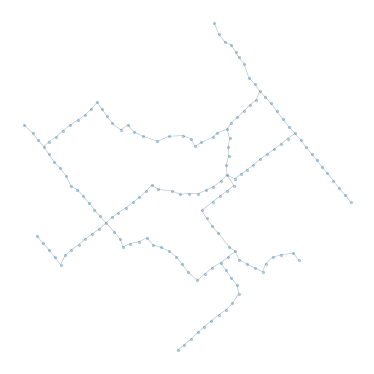

In [2]:
from matplotlib import pyplot as plt
import pickle5 as pickle
import networkx as nx

with open('small/4_cen_3_max_freq_2/vertexpos.pickle', 'rb') as handle:
    vertexpos = pickle.load(handle)
    
with open('small/4_cen_3_max_freq_2/in/depot_node.pickle', 'rb') as handle:
    depot_node = pickle.load(handle)

# with open('small/13_cen_3_max_freq_2/base_graph.gpickle', 'rb') as handle:
#     T = pickle5.load(handle)
    
T = nx.read_gpickle("small/4_cen_3_max_freq_2/base_graph.gpickle")

P = nx.read_gpickle("small/4_cen_3_max_freq_2/in/updated_path_graph.gpickle")

P_dh = nx.read_gpickle("small/4_cen_3_max_freq_2/in/deadhead_path_graph.gpickle")

print(depot_node)

plt.figure(figsize=(5,5))
nx.draw(P, vertexpos, node_size=5, font_size=8, alpha=0.3, width=0.5)

In [3]:
import math
from itertools import combinations
from copy import deepcopy
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

In [6]:
# def create_stop_dists(lcon, T, P_dh, depot_node):
end_dh = []
stops = []
starts = []

added = []
for t in lcon.values():
#                 print(added)
    start,stop=t[0],t[1]
    pair=(start,stop)
    if stop in P_dh.nodes() and pair not in added and pair[::-1] not in added:           
        starts.append(stop)
        stops.append(start)
        added.append(pair)
        end_dh.append(nx.shortest_path(P_dh, depot_node[0], stop))
    elif start in P_dh.nodes() and pair not in added and pair[::-1] not in added:
        starts.append(start)
        stops.append(stop)
        added.append(pair)
        end_dh.append(nx.shortest_path(P_dh, depot_node[0], start))

def create_dh_starts(act_path, end_dh):

    b = act_path
    a = end_dh
    
    if a[0] != b[0] and a[-1] != b[-1]:
        b = b[::-1]

    s = SequenceMatcher(None, a, b)
    alo, blo, size = s.find_longest_match(0, len(a), 0, len(b))
    c = a[alo:alo+size]

    return b[:blo] + a[:alo+1][::-1]

        
# for dh in end_dh:
#     print(dh)
# print(P_dh.nodes())
    
act_path = []
for i in range(len(stops)):
    act_path.append(nx.shortest_path(T, stops[i], starts[i]))

start_dh = []
for i in range(len(act_path)):
    start_dh.append(create_dh_starts(act_path[i], end_dh[i]))

# return start_dh, end_dh

# for dh in end_dh:
#     print(dh)
#     c = deepcopy(act_path)
#     d = deepcopy(end_dh)
#     a = c[::-1]
#     b = d[::-1]
    
# #     print(a)
# #     print('-'*100)
# #     print(b)
# #     print('-'*100)
    
#     temp = []
#     check = 0
#     marker = 0
    
#     for i in range(len(c)):
#         for j in range(len(b)):
#             if a[i] != b[j]:
#                 if a[i] not in temp:
#                     temp.append(a[i])
#             else:
#                 marker = a[i]
#                 check= 1
#                 break
                
#         if check == 1:
#             break
    
# #     print(temp)
# #     print('-'*100)
#     id = b.index(marker)
#     if id == 0:
#         id = -1
    
#     temp2 = []
#     for i in range(id+1, len(b)):
#         temp2.append(b[i])
#     temp += temp2
# #     print(temp2)
# #     print('-'*100)
    
# #     print(temp)
#     return temp

start_dh = []

for i in range(len(act_path)):
    start_dh.append(create_dh_starts(act_path[i], end_dh[i]))


for path in start_dh:
    path_length = 0
    for i in range(1,len(path)):
        dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
        path_length += dist
#     print(round(path_length/20,2), path[0], path[-1])#, depot_node[0], starts[j], round(path_length/20,2))
# print('-'*50)

# for st in starts:
#     if st in P_dh.nodes():
#         print(st)

In [649]:
# '''
# ('l1', [1474, 922, 7.0, 0.4, 2, (10.270294005766662, 191.33147757008302), 13.94])
# ('l2', [922, 1474, 6.75, 0.4, 2, (157.7209928066743, 50.57922575446275), 13.94])
# ('l3', [1146, 1035, 7.33, 0.36, 2, (55.3591353026933, 188.9890401884978), 12.5])
# ('l4', [1035, 1146, 7.08, 0.36, 2, (139.53823157924185, 28.160680040432588), 12.5])
# ('l5', [1193, 1057, 7.0, 0.33, 1, (8.21297043946478, 140.50693369878195), 11.4])
# ('l6', [1057, 1193, 7.25, 0.33, 1, (169.61619864956, 64.36188141645461), 11.4])
# ('l7', [1353, 1411, 7.33, 0.34, 1, (6.185844166896037, 10.290334856094837), 11.86])
# ('l8', [1411, 1353, 7.58, 0.34, 1, (143.2634169752559, 136.63366080296575), 11.86])
# '''

# c = deepcopy(act_path[0])
# d = deepcopy(end_dh[0])
# a = c[::-1]
# b = d[::-1]
# print(a)
# print(b)
# temp = []
# check = 0
# marker = 0
# for i in range(len(c)):
#     for j in range(len(b)):
# #         print(a[i], b[j])
#         if a[i] != b[j]:
#             if a[i] not in temp:
#                 temp.append(a[i])
#         else:
#             print('same',a[i])
#             marker = a[i]
#             check= 1
#             break
#     if check == 1:
#         break
# print('a', temp)
# print('hh', marker)
# id = b.index(marker)
# print('gg', id)
# if id == 0:
#     id = -1
# temp2 = []
# for i in range(id+1, len(b)):
#     temp2.append(b[i])
# temp += temp2
# print('Fin', temp)

In [7]:
def station_dist(line_pool, T, P_dh, scale, start_dh, depot):
    dists = {}
#     print(depot)
#     stations = [depot]
    stations = []
    for line in line_pool.values():
#         print(line)
        if line[0] not in stations:
            stations.append([line[0], line[5]])
    
#     print(stations)
    for s1, s2 in combinations(stations, 2):
#         print(s1)
        if s1[0] not in dists.keys():
            path = nx.shortest_path(T, s1[0], s2[0])
            path_length = 0
            for i in range(1,len(path)):
                dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
                path_length += dist

            dists[s1[0]] = [(s2[0], path_length/scale)]

        else:
            path = nx.shortest_path(T, s1[0], s2[0])
            path_length = 0
            for i in range(1,len(path)):
                dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
                path_length += dist
                    
            if (s2[0], path_length/scale) not in dists[s1[0]]:
                dists[s1[0]].append((s2[0], path_length/scale))
            
#             dists[s1[0]].append([s2[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0), 2)])
        
        if s2[0] not in dists.keys():
            path = nx.shortest_path(T, s1[0], s2[0])
            path_length = 0
            for i in range(1,len(path)):
                dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
                path_length += dist
                    
            dists[s2[0]] = [(s1[0], path_length/scale)]
            
#             if [[s1[0], path_length/scale]] not in dists[s2[0]]:
#                 dists[s2[0]] = [[s1[0], path_length/scale]]
            
#             dists[s2[0]] = [[s1[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0), 2)]]
        else:
            path = nx.shortest_path(T, s1[0], s2[0])
            path_length = 0
            for i in range(1,len(path)):
                dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
                path_length += dist
                    
#             dists[s2[0]].append([s1[0], path_length/scale])
            
            if (s1[0], path_length/scale) not in dists[s2[0]]:
                dists[s2[0]].append((s1[0], path_length/scale))
            
#             dists[s2[0]].append([s1[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0), 2)])
    
    for node in dists.keys():
        if (node, 0.0) not in dists[node]:
            dists[node].append((node, 0.0))
    
    dists[depot_node[0]] = []
    
    for path in start_dh:
        path_length = 0
        for i in range(1,len(path)):
            dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
            path_length += dist
        
        dists[depot_node[0]].append((path[0], path_length/scale))
        dists[path[0]].append((depot_node[0], path_length/scale))
    
    for st in stations:
        if st[0] in P_dh.nodes():
            path = nx.shortest_path(P_dh, st[0], depot_node[0])
            path_length = 0
            for i in range(1,len(path)):
                dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
                path_length += dist
            if (depot_node[0], path_length/scale) not in dists[st[0]]:
                dists[st[0]].append((depot_node[0], path_length/scale))
            if (st[0], path_length/scale) not in dists[depot_node[0]]:
                dists[depot_node[0]].append((st[0], path_length/scale))
    
#     dist_no_dup = {}
#     for dist in dists.items():
#         dist_no_dup[dist[0]] = []
#         for pair in dist[1]:
#             if pair[0] not in dist_no_dup:
#                 dist_no_dup[dist[0]].append(pair)
    
    return dists

# temp_lp = {}
# for line in line_pool.items():
#     if line[0] == 'l2' or line[0] == 'l4':
#         temp_lp[line[0]] = line[1]
        
# print(temp_lp)
# print(depot)

# with open('v_pos.pickle', 'rb') as handle:
#     vertexpos = pickle.load(handle)

# MN = nx.read_gpickle("test_path_graph.gpickle")
# print(MN)
# plt.figure(figsize=(10,10))
# nx.draw(MN, vertexpos, node_size=10, font_size=8, alpha=0.3, width=0.5)
print(depot_node)
print('-'*100)

stop_dist = station_dist(lcon, P, P_dh, 20, start_dh, depot_node)   #)#, depot))
for st in stop_dist.items():
    print(st[0])
    print('*'*20)
    for d in st[1]:
        print(d)
    print('-'*20)

[52654, (97.84678590287886, 123.00984380731046)]
----------------------------------------------------------------------------------------------------
53075
********************
(53236, 12.019541628555794)
(53045, 6.424283299108252)
(52868, 11.844102810282903)
(52571, 11.766234590674989)
(52842, 1.28994637652234)
(52983, 12.868793246260736)
(52633, 10.290662553673494)
(53075, 0.0)
(52654, 8.555918119611974)
--------------------
53236
********************
(53075, 12.019541628555794)
(53045, 10.302058026462428)
(52868, 10.522313321829207)
(52571, 5.626625540987725)
(52842, 10.729595252033457)
(52983, 0.8492516177049421)
(52633, 10.020264061225998)
(53236, 0.0)
(52654, 4.98589492533828)
--------------------
53045
********************
(53075, 6.424283299108252)
(53236, 10.302058026462428)
(52868, 12.046709752100302)
(52571, 11.968841532492387)
(52842, 5.134336922585911)
(52983, 11.151309644167366)
(52633, 10.49326949549089)
(53045, 0.0)
(52654, 4.502607643134759)
--------------------
52868


In [73]:
from copy import deepcopy

def create_trips(start, end, line_pool = {}):
    num_trips = 0
    trips = []
    latest = 0
    for line in line_pool.keys():
        num_trips_line = 0
        if start <= line_pool[line][2]:
            earliest = line_pool[line][2]
        else:
            earliest = line_pool[line][2] + math.ceil((start - line_pool[line][2]) * line_pool[line][4])/line_pool[line][4]
        latest = round(earliest + 1/line_pool[line][4],2)
        while latest <= end:
            num_trips += 1
            trips.append([line, round(earliest,2), round(earliest + line_pool[line][3],2), line_pool[line][6]])
            earliest = latest
#             latest = earliest + line_pool[line][3]
            latest = round(earliest + 1/line_pool[line][4],2)
    return sorted(trips, key=lambda y: y[1])

# def station_dist(line_pool , depot = None):
#     dists = {}
#     stations = [depot]
#     for line in line_pool.values():
#         if line[0] not in stations:
#             stations.append([line[0], line[5]])
#     for s1, s2 in combinations(stations, 2):
#         if s1[0] not in dists.keys():
#             dists[s1[0]] = [[s2[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0), 2)]]
#         else:
#             dists[s1[0]].append([s2[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0), 2)])
#         if s2[0] not in dists.keys():
#             dists[s2[0]] = [[s1[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0), 2)]]
#         else:
#             dists[s2[0]].append([s1[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0), 2)])
    
#     for node in dists.keys():
#         dists[node].append([node, 0.05])
#     return dists

def possible_swap(end_st, stop_dist):
    next_st = stop_dist[end_st]
    next_st.sort(key = lambda tup: tup[1])
    return next_st

'''

'''

def new_stop(line_pool, trips, buses, cov):
    deadhead = []
#     print(depot_node[0])
    lines = deepcopy(line_pool)
    rem_trips = []
    for bus in buses.keys():
        if trips == []:
            for i in range(len(buses)):
                if buses[i+1] == []:
                    del buses[i+1]
            return (buses, cov, deadhead)
            break
        
        if buses[bus] == []:
            buses[bus] = [trips[0]]
            
            for st in stop_dist[first_stop]:
                if st[0] == depot_node[0]:
                    first_dh = st[1]
            
            buses[bus][-1][-1] = round(b_range - trips[0][-1] - first_dh)
            curr_stop = lines[trips[0][0]][1]
            trips.pop(0)
            cov += 1

        curr_time_new = 0
        
        charge_check = 0
        
        new_trav = 0
        
        t = 0
        trip_num = len(trips)
        while t < trip_num:
            if charge_check == 0:
                trav = buses[bus][-1][-1]
                curr_time = buses[bus][-1][2]
            else:
                curr_time = curr_time_new
                trav = new_trav
                charge_check = 0
            
            curr_stop = lines[buses[bus][-1][0]][1]
            nxt_stop = lines[buses[bus][-1][0]][0]
            next_stop_dist = lines[buses[bus][-1][0]][-1]
            dists = possible_swap(curr_stop, stop_dist)
            
            for line in lines.values():
                if line[0] == curr_stop:
                    next_dists = possible_swap(nxt_stop, stop_dist)

            for d in dists:
                if d[0] == depot_node[0]:
                    charge_trip_curr = d[1]
            
            for d in next_dists:
#                 print(nxt_stop)
                if d[0] == depot_node[0]:
                    charge_trip_next = d[1]
#                 print('/'*100)
            
            for st in dists:
                if st[1]/speed <= trips[t][1] - curr_time:
                    if curr_stop == lines[trips[t][0]][0]:
                        nxt_stop_dist = trips[t][-1]
                        proj_trip = next_stop_dist + charge_trip_next
                        if trav - charge_trip_curr > 0: #REDUNDANT
                            if trav - proj_trip > 0:
                                rem_trips.append(trips[t])
                                trips[t][-1] = round(trav-trips[t][-1],2)
                                buses[bus].append(trips[t])
                                cov += 1
                                curr_time_new = trips[t][-2]
                                break
                            else:
                                charge_check = 1
#                                 if bus == 2:
#                                     print(curr_stop, depot_node[0], curr_time, charge_trip_curr)
                                trip_to_depot = [bus, curr_stop, depot_node[0], curr_time, round(curr_time + (charge_trip_curr/speed),2), round(trav - charge_trip_curr,2)]
                                if trip_to_depot not in deadhead:
                                    deadhead.append(trip_to_depot)
#                                 refuel_time = round((b_range - trav + charge_trip_curr) /batt_cap, 2)
                                refuel_time = round((b_range - trav + charge_trip_curr) /b_range, 2)
                                curr_time_new = round(curr_time + (charge_trip_curr/speed) + refuel_time, 2)
                                new_trav = round(b_range - charge_trip_curr,2)
                                trip_from_depot = [bus, depot_node[0], curr_stop, curr_time_new, round(curr_time_new + (charge_trip_curr/speed),2), new_trav]
                                if trip_from_depot not in deadhead:
                                    deadhead.append(trip_from_depot)
                                curr_time_new += charge_trip_curr/speed
                                t -= 1
                                break
            t += 1

        for trip in rem_trips:
            if trip in trips:
                trips.remove(trip)
    
    return (buses, cov, deadhead)


def eval(schedule):
    print('Schedule stats: ')
    print('Number of buses: ', len(buses.keys()))
#     print('Distance travelled: ', )
    print('-'*100)

# lines = {'l1' :(1, 2, 9, 0.5, 2, (1.0, 1.0), 1.41), 'l2': (2, 1, 9.25, 0.5, 2, (2.0, 2.0), 1.41), 'l3': (3, 4, 9.4, 0.5, 1, (2.2, 2.0), 1.0), 'l4': (4, 3, 9.65, 0.5, 1, (2.2, 1.0), 1.0)}


# depot_node = [0,(2.25, 2.25)]

speed = 35
lines = lcon
temp = deepcopy(lcon)

# del temp['l3']
# del temp['l4']
for id in lcon.keys():
    if int(id[1]) > 4 or len(id) > 2:
        del temp[id]

# print(possible_swap(922, stop_dist))
print(stop_dist.keys())
# for line in temp.values():
#     print(line)
# print(depot_node)

# stop_dist = station_dist(temp, depot_node)
# stop_dist = station_dist(lcon, MN, depot)
# print(depot_node)

# stop_dist = deepcopy(st_dist)

# for s in stop_dist.items():
#     print(s)
# print('-'*100)

b_range = 60

op_start = 9
op_end = 12

print('Lines in use: ', temp)
print('-'*100)

print('Operation time range: ', op_start, '-', op_end)
print('-'*100)

trips = create_trips(op_start, op_end, temp)
trip_copy = deepcopy(trips)
rem_trips = len(trips)

print('Number of trips: ', rem_trips)
print('-'*100)

print('Trips: ')
for t in trips:
    print(t)
print('-'*100)

# next_st = possible_swap(1, stop_dist)
# print('-'*100)

buses = {}
ctr = 0

deadhead_trips = []

for i in range(rem_trips):
    buses[i+1] = []

first_stop = temp[trips[0][0]][0]
for st in stop_dist[first_stop]:
#     print(st)
    if st[0] == depot_node[0]:
        first_dh = st[1]
print('-'*100)

while ctr < rem_trips:
    if buses[1] == []:
        buses[ctr+1] = [trips[0]]
        first_stop = temp[trips[0][0]][0]
        
        for st in stop_dist[first_stop]:
            if st[0] == depot_node[0]:
                first_dh = st[1]
        
        buses[ctr+1][-1][-1] = round(b_range - trips[0][-1] - first_dh)
        trips.pop(0)
        ctr += 1
    else:
        buses, ctr, dh_trips = new_stop(temp, trips, buses, ctr)
        deadhead_trips.extend(dh_trips)

print('Bus schedule: ')
for bus in buses.items():
    print('*'*50)
    print('Bus ' + str(bus[0]) + ' : ')
    for t in bus[1]:
        print(t)
print('-'*100)

print('Deadhead trips: ')
for dh in deadhead_trips:
    print(dh)

bus_schedule = deepcopy(buses)

dict_keys([53075, 53236, 53045, 52868, 52571, 52842, 52983, 52633, 52654])
Lines in use:  {'l1': [53075, 53236, 7.0, 0.34, 1, (194.00691515079646, 93.99472149346109), 12.02], 'l2': [53236, 53075, 7.25, 0.34, 1, (19.017648654639345, 125.34851758346348), 12.02], 'l3': [53045, 52868, 7.25, 0.34, 1, (116.16572406141877, 194.62938123552058), 12.05], 'l4': [52868, 53045, 7.5, 0.34, 1, (95.21282520957327, 10.952576634548462), 12.05]}
----------------------------------------------------------------------------------------------------
Operation time range:  9 - 12
----------------------------------------------------------------------------------------------------
Number of trips:  9
----------------------------------------------------------------------------------------------------
Trips: 
['l1', 9.0, 9.34, 12.02]
['l2', 9.25, 9.59, 12.02]
['l3', 9.25, 9.59, 12.05]
['l4', 9.5, 9.84, 12.05]
['l1', 10.0, 10.34, 12.02]
['l2', 10.25, 10.59, 12.02]
['l3', 10.25, 10.59, 12.05]
['l4', 10.5, 10.84, 12.

In [193]:
# def create_trips(start, end, line_pool = {}):
#     num_trips = 0
#     trips = []
#     latest = 0
#     for line in line_pool.keys():
#         num_trips_line = 0
#         if start <= line_pool[line][2]:
#             earliest = line_pool[line][2]
#         else:
#             earliest = line_pool[line][2] + math.ceil((start - line_pool[line][2]) * line_pool[line][4])/line_pool[line][4]
#         latest = round(earliest + 1/line_pool[line][4],2)
# #         print(latest)
#         while latest <= end:
#             num_trips += 1
#             trips.append([line, round(earliest,2), round(earliest + line_pool[line][3],2), line_pool[line][6]])
#             earliest = latest
#             latest = round(earliest + 1/line_pool[line][4],2)
#     return sorted(trips, key=lambda y: y[1])

# single_line = {}
# single_line['l1'] = lcon['l1']
# print(single_line)

# trp = create_trips(op_start, op_end, single_line)
# # print(possible_swap(5002, stop_dist))
# for trip in trp:
# #     if trip[0] == 'l1':# or trip[0] == 'l2':
#     print(trip)

{'l1': [5166, 5002, 6.0, 0.29, 2, (149.26850641105148, 64.73946778581829), 10.25]}
['l1', 9.0, 9.29, 10.25]
['l1', 9.5, 9.79, 10.25]
['l1', 10.0, 10.29, 10.25]
['l1', 10.5, 10.79, 10.25]
['l1', 11.0, 11.29, 10.25]
['l1', 11.5, 11.79, 10.25]
['l1', 12.0, 12.29, 10.25]
['l1', 12.5, 12.79, 10.25]
['l1', 13.0, 13.29, 10.25]
['l1', 13.5, 13.79, 10.25]
['l1', 14.0, 14.29, 10.25]
['l1', 14.5, 14.79, 10.25]


{1: (1, 9.0), 2: (2, 9.25), 3: (3, 9.25), 4: (4, 9.5), 5: (1, 10.0), 6: (2, 10.25), 7: (3, 10.25), 8: (4, 10.5), 9: (1, 11.0)}


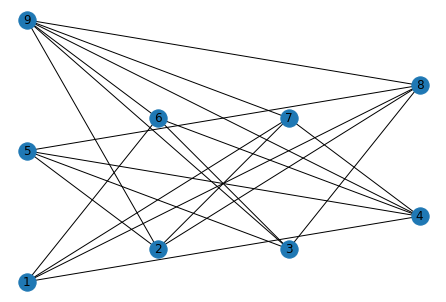

In [74]:
import networkx as nx

# lines = {'l1' :(1, 2, 9, 0.5, 2, (1.0, 1.0), 1.41), 'l2': (2, 1, 9.25, 0.5, 2, (2.0, 2.0), 1.41), 'l3': (3, 4, 9.4, 0.5, 1, (2.2, 2.0), 1.0), 'l4': (4, 3, 9.65, 0.5, 1, (2.2, 1.0), 1.0)}
# temp = deepcopy(lines)
# del temp['l3']
# del temp['l4']

tripz = create_trips(9, 12, temp)
# print(tripz)
trip_x = []
trip_y = []
serv_trip = {}
VS = nx.Graph()
deadhead = []
trip_id = {}
ctr= 1
for t in tripz:
    line_id = int(t[0][1])

    serv_trip[ctr] = (line_id, t[1])
    VS.add_node(ctr, pos = (line_id, t[1]))
    trip_id[str(t)] = ctr
    ctr += 1

print(serv_trip)
deadhead = []

'''
Fix deadhead trips not showing in schedule
Visualise bus schedule
'''

for t in tripz:
    for s in serv_trip.items():
        n1 = serv_trip[trip_id[str(t)]]
        if n1[0] != s[1][0] :
            if t[2] <= s[1][1]:# and n1[0] = s[0]:
                deadhead.append([trip_id[str(t)], s[0]])

VS.add_edges_from(deadhead)
nx.draw(VS, serv_trip, with_labels = True)#)
plt.savefig('dummy_')

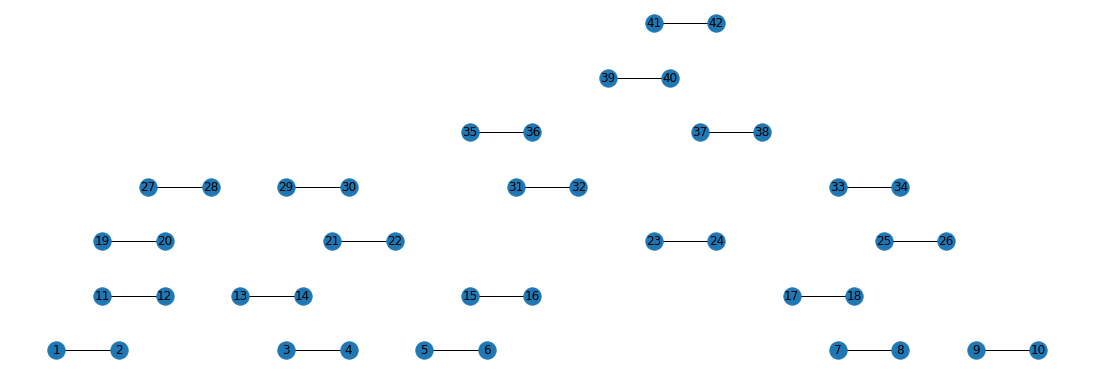

In [345]:
'''
SCHEDULE VISUALISATION
'''

ctr = 1
pos = {}
edges = []
edge_color = []
Trip_graph = nx.Graph()
for bus in bus_schedule.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        
fig = plt.figure(figsize=(15,5))
Trip_graph.add_nodes_from(pos)
Trip_graph.add_edges_from(edges)
nx.draw(Trip_graph, pos, with_labels = True)
plt.savefig('schedule_basic.png')
        
# fig, ax = plt.subplots(figsize=(15, 5))
# Trip_graph.add_nodes_from(pos)
# Trip_graph.add_edges_from(edges)
# nx.draw(Trip_graph, pos, with_labels = True,ax=ax)
# # ax.set_axis_on()
# # ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
# # nx.draw_networkx(Trip_graph, pos, with_labels = True, node_size = 0, width = 10.0, edge_color = 'red', alpha = 0.5)
# plt.savefig('schedule_basic.png')

21


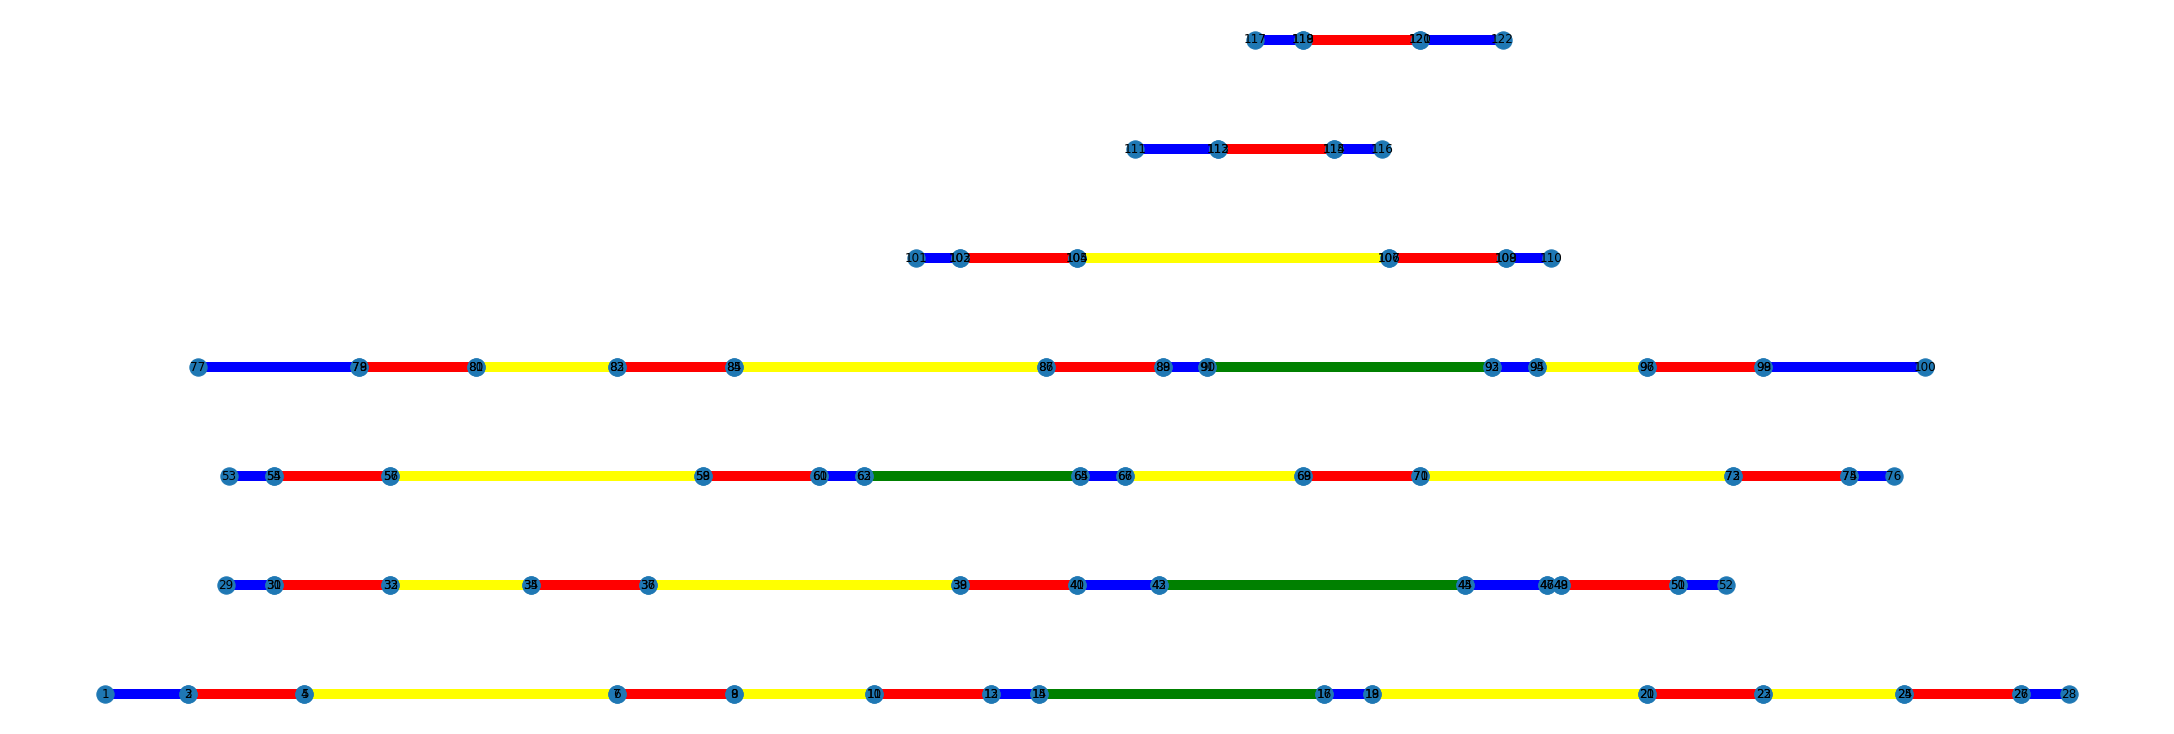

In [346]:
'''
REVISED: COMPLETE SCHEDULE
'''

new_schedule = {}

dh_tripz = adjusted_dh(bus_schedule, deadhead_trips)
# dh_tripz = deepcopy(deadhead_trips)
# print(dh_tripz)
trip_num = 0
for bus in bus_schedule.keys():
    new_sch = []
    for trip in bus_schedule[bus]:
        new_sch.append([('t', trip[0]), trip[1], trip[2], trip[3]])
        trip_num += 1
    
    for dh in dh_tripz:
            if dh[0] == bus:
                new_sch.append([('d', None), dh[3], dh[4], dh[5]])
    
    new_schedule[bus] = sorted(new_sch, key=lambda y: y[1])

print(trip_num)
# for bus in new_schedule.values():
#     print(bus)
#     print('-'*100)
# trav = 0
for bus in new_schedule.keys():
    charging_trips = []
    for t in range(1,len(new_schedule[bus])):
        if new_schedule[bus][t][1] != new_schedule[bus][t-1][2]:
            if new_schedule[bus][t-1][0][0] == 'd' and new_schedule[bus][t-1][0][0] == new_schedule[bus][t][0][0]:
                label = 'c'
                trav = b_range
            else:
                label = 's'
                trav = new_schedule[bus][t-1][3]
            charging_trips.append([(label, None), new_schedule[bus][t-1][2], new_schedule[bus][t][1], trav])
#     for trip in charging_trips:
    new_schedule[bus].extend(charging_trips)
    new_schedule[bus].sort(key=lambda y: y[1])

# print(new_schedule[1])
# print('-'*100)

ctr = 1
pos = {}
edges = []
edge_color = []

new_trip_graph = nx.Graph()
for bus in new_schedule.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        if seq[0][0] == 't':
            edge_color.append('red')
        elif seq[0][0] == 'd':
            edge_color.append('blue')
        elif seq[0][0] == 'c':
            edge_color.append('green')
        else:
            edge_color.append('yellow')

fig = plt.figure(figsize=(30,10))
new_trip_graph.add_nodes_from(pos)
new_trip_graph.add_edges_from(edges)
nx.draw(new_trip_graph, pos, with_labels = True, edge_color = edge_color, width = 10.0)
plt.savefig('schedule.png')

In [132]:
# for dh in dh_tripz:
#     if dh[0] == 12:
#         print(dh)

    
# def swap_all(init_sch, dh_trips, lines, trip_copy):
    
#     sch_check = 1
    
#     while sch_check == 1:
#         bus_sch = deepcopy(init_sch)
#         dht = deepcopy(dh_trips)

#         check_bus_1 = 1
#         check_bus_2 = 1

#         while check_bus_1 == 1 and check_bus_2 == 1:
#             bus_1_id, bus_2_id, new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, temp_dht_new, rem_trips_bus_1, rem_trips_bus_2 = swap_check_all(bus_sch, dht)
#             check_bus_1 = len(new_bus_1)
#             check_bus_2 = len(new_bus_2)

#         temp_dht = []
#         for dh in temp_dht_new:
#             if dh is not None:
#                 temp_dht.append(dh)
        
#         upd_sch = deepcopy(new_schd)
                
#         dummy_sch_1 = {}
#         dummy_sch_2 = {}
#         dummy_sch_1[1] = new_bus_1
#         dummy_sch_2[1] = new_bus_2

#         dummy_dh_1 = []
#         dummy_dh_2 = []

#         for dh in temp_dht:
#             if dh == new_schd[bus_1_id]:
#                 dummy_dh_1.append(dh)
#             elif dh == new_schd[bus_2_id]:
#                 dummy_dh_2.append(dh)

#         add_check_sch_1 = check_added(dummy_sch_1, dummy_dh_1, rem_trips_bus_2, lines)
#         add_check_sch_2 = check_added(dummy_sch_2, dummy_dh_2, rem_trips_bus_1, lines)
        
#         if add_check_sch_1[0] == 1 and add_check_sch_2[0] == 1:
# #             print(bus_1_id, bus_2_id)
            
# #             print(add_check_sch_1[1])
# #             print(add_check_sch_2[1])

#             upd_sch[bus_1_id] = list(add_check_sch_1[1][1])
#             upd_sch[bus_2_id] = list(add_check_sch_2[1][1])
            
#             temp_dht.extend(add_check_sch_1[2])
#             temp_dht.extend(add_check_sch_2[2])

#             return (new_bus_1, new_bus_2, upd_sch, rem_trips, old_bus_1, old_bus_2, temp_dht_new)
#         else:
#             sch_check = 1

# # trip_ct_org = 0
# # for bus in bus_sch.values():
# #     trip_ct_org += len(bus)
# # print(trip_ct_org)
# # print('-'*100)

# # for el in bus_sch.items():
# #     print(el)

# # test_swap = swap_all(bus_sch, dht, temp, trip_copy)


[12, 53505, 54063, 14.05, 14.5, 44.23]


In [39]:
def sched_block(bus_schedule, deadhead_trips):
    new_schedule = {}
    dh_tripz = adjusted_dh(bus_schedule, deadhead_trips)

    for bus in bus_schedule.keys():
        new_sch = []
        for trip in bus_schedule[bus]:
            new_sch.append([('t', trip[0]), trip[1], trip[2], trip[3]])

        for dh in dh_tripz:
                if dh[0] == bus:
                    new_sch.append([('d', None), dh[3], dh[4], dh[5]])

        new_schedule[bus] = sorted(new_sch, key=lambda y: y[1])

    for bus in new_schedule.keys():
        charging_trips = []
        for t in range(1,len(new_schedule[bus])):
            if new_schedule[bus][t][1] != new_schedule[bus][t-1][2]:
                if new_schedule[bus][t-1][0][0] == 'd' and new_schedule[bus][t-1][0][0] == new_schedule[bus][t][0][0]:
                    label = 'c'
                    trav = b_range
                else:
                    label = 's'
                    trav = new_schedule[bus][t-1][3]
                charging_trips.append([(label, None), new_schedule[bus][t-1][2], new_schedule[bus][t][1], trav])
        
        new_schedule[bus].extend(charging_trips)
        new_schedule[bus].sort(key=lambda y: y[1])
    
    for bus in new_schedule.keys():
        for t in range(2,len(new_schedule[bus])):
            if new_schedule[bus][t][0][0] == 'c' and new_schedule[bus][t-2][0][0] == new_schedule[bus][t][0][0]:
                print('HAHAHAAH')
                new_schedule[bus][t][0] = ('s', None)
                
    return new_schedule


In [45]:
'''
genetic algorithm
'''
def convert_to_blocks(new_schedule):
    blocks = {}
    ins_pts = []
    id = 1
    for bus in new_schedule.items():
        blocks[(id, bus[0])] = []
        for t in range(len(bus[1])):
            if bus[1][t][0][0] != 'c':
                blocks[(id, bus[0])].append(bus[1][t])
            else:
                id += 1
                blocks[(id, bus[0])] = []
        id += 1
    
    id_del = None
    for block in blocks.items():
        if block[1] == []:
            id_del = block[0]
            
    if id_del is not None:
        del blocks[id_del]
    
    for bus in new_schedule.items():
        for t in range(2,len(bus[1])):
            if bus[1][t-2][0][0] == 'c' and bus[1][t][0][0] == 's':
                ins_pts.append([bus[0],[bus[1][t-2][2], bus[1][t][1]]])
    
    blocks_red = {}
    for bl in blocks.items():
        blocks_red[bl[0]] = []
        for trip in bl[1]:
            if trip[0][0] == 't':
                blocks_red[bl[0]].append([trip[0][1], trip[1], trip[2], trip[3]])

#     for trip in blocks_red.items():
#         print(trip)
#         print('-'*100)
    
#     for pt in ins_pts:
#         print(pt)
    
    return (blocks_red, ins_pts)

# new_s
# ndht_t

# dumm_dh = adjusted_dh(new_s, ndh_t)

# gga_sch = full_sch_vis(new_s, dumm_dh, 0)

# for trip in gga_sch.values():
#     print(trip)

In [69]:
def conv_blocks(bus_sch, dht):
    
    dht_adj = adjusted_dh(bus_sch, dht)
    upd_sch = full_sch_scoring(bus_sch, dht_adj)
    blocks = {}
    insertion_pt = {}
    id = 1
    blocks[id] = []
    for bus in upd_sch.items():
        insertion_pt[bus[0]] = []
        for trip in bus[1]:
            if trip[0] != 'c':
                blocks[id].append(trip)
            else:
                insertion_pt[bus[0]].append(trip)
                id += 1
                blocks[id] = []
        id += 1
        blocks[id] = []
    
    id_del = None
    for bus in blocks.items():
        if bus[1] == []:
            id_del = bus[0]
    
    if id_del is not None:
        del blocks[id_del]

    id_pt = []
    for pt in insertion_pt.items():
        if pt[1] == []:
            id_pt.append(pt[0])
    
    if id_pt != []:
        for pt in id_pt:
            del insertion_pt[pt]

    print(blocks.keys())
    print(insertion_pt.keys())
    
    for pt in insertion_pt.items():
        print(pt)
conv_blocks(bus_schedule, deadhead_trips)

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
dict_keys([1, 2, 3, 4])
(1, [['c', 11.48, 12.31]])
(2, [['c', 11.83, 12.72]])
(3, [['c', 10.97, 11.6]])
(4, [['c', 11.97, 12.8]])


In [41]:
def crossover(init_sch, init_dh, new_sch, new_dh, trip_copy):
    
    new_schedule = sched_block(init_sch, init_dh)
    gga_sch = sched_block(new_sch, new_dh)
    
    schd = {}
    cotr = 1
    check = 1
    while check == 1 and cotr < 3:
        prob = random.uniform(0,1)
        if prob > 0.5:
            blocks_1_red, insertion_pts_1 = convert_to_blocks(new_schedule)
            blocks_2_red, insertion_pts_2 = convert_to_blocks(gga_sch)
            schd = init_sch
            dh_tr = init_dh
        else:
            blocks_1_red, insertion_pts_1 = convert_to_blocks(gga_sch)
            blocks_2_red, insertion_pts_2 = convert_to_blocks(new_schedule)
            schd = new_sch
            dh_tr = new_dh

        crossover_pt = random.choice(insertion_pts_1)
#         print(crossover_pt)
        # ADDING FROM 2 TO 1

        block_choice = []
        
#         print(blocks_2_red.values())
        for block in blocks_2_red.values():
            print(block[0])
            if block[0][1] > crossover_pt[1][1]:
                block_choice.append(block)
        print('-'*100)

        block_to_add = random.choice(block_choice)
#         print(block_to_add)

        dummy_sch = {}
        dummy_sch[1] = []
        for trip in schd[crossover_pt[0]]:
            dummy_sch[1].append(trip)
        
#         print(dummy_sch[1])
        rem_trips = []
        for bus in dummy_sch.values():
            for trip in bus:
                if trip[1] > crossover_pt[1][1]:
                    rem_trips.append(trip)

#         print(rem_trips)
#         print(block_to_add)
        for trip in rem_trips:
            dummy_sch[1].remove(trip)
        
        for t in trip_copy:
            for trip in block_to_add:
                if trip[0] == t[0] and trip[1] == t[1] and trip[2] == t[2]:
#                     print(trip, t)
                    trip[-1] = t[-1]
            for trip in rem_trips:
                if trip[0] == t[0] and trip[1] == t[1] and trip[2] == t[2]:
                    trip[-1] = t[-1]

        dummy_dh = []
        for dh in dh_tr:
            if dh[0] == crossover_pt[0]:
                dummy_dh.append(dh)

        add_check_sch_1 = check_added(dummy_sch, dummy_dh, block_to_add, lines)
        
        if add_check_sch_1[0] == 1:
            
            schd[crossover_pt[0]] = list(add_check_sch_1[1][1])
            dh_tr.extend(add_check_sch_1[2])

#             for trip in rem_trips:
#                 print(trip)
            
            return (1, schd, dh_tr, rem_trips)
            
            
#             break
        else:
            print(cotr)
            check = 1
            cotr += 1
        
    if cotr == 3:
        return (0, None, None, None)

#     if add_check_sch_1[0] == 1 and add_check_sch_2[0] == 1:

#         upd_sch[bus_1_id] = list(add_check_sch_1[1][1])
#         upd_sch[bus_2_id] = list(add_check_sch_2[1][1])

#         temp_dht.extend(add_check_sch_1[2])
#         temp_dht.extend(add_check_sch_2[2])    

cross_check, cross_s, cross_dh, cross_rem = crossover(bus_schedule, deadhead_trips, new_s, ndh_t, trip_copy)

print(cross_check)
# for trip in trip_copy:
#     print(trip)

['l1', 9.0, 9.34, 39]
['l4', 13.5, 13.84, 31.4]
['l2', 9.25, 9.59, 39]
['l1', 13.0, 13.34, 12.02]
['l3', 9.25, 9.59, 39]
['l3', 12.25, 12.59, 12.05]
['l4', 9.5, 9.84, 39]
['l3', 13.25, 13.59, 12.05]
['l3', 11.25, 11.59, 39]
['l1', 12.0, 12.34, 39]
['l2', 12.25, 12.59, 39]
----------------------------------------------------------------------------------------------------
1
['l1', 9.0, 9.34, 39]
['l4', 13.5, 13.84, 31.4]
['l2', 9.25, 9.59, 39]
['l1', 13.0, 13.34, 12.02]
['l3', 9.25, 9.59, 39]
['l3', 12.25, 12.59, 12.05]
['l4', 9.5, 9.84, 39]
['l3', 13.25, 13.59, 12.05]
['l3', 11.25, 11.59, 39]
['l1', 12.0, 12.34, 39]
['l2', 12.25, 12.59, 39]
----------------------------------------------------------------------------------------------------
2
0


In [49]:
def GGA(init_sch, init_dh, iters, lines, trips):
    scores = []
    best_sch = deepcopy(init_sch)
    dht = deepcopy(dh_trips)
    dht_adj = adjusted_dh(bus_sch, dht)
    
    scored_sch = full_sch_scoring(bus_sch, dht_adj)
    
    solutions = [(best_sch, dht, scored_sch)]
    
    for i in range(3):
        trip_copy = deepcopy(trips)
        check_bus_1 = 1
        check_bus_2 = 1
        while check_bus_1 == 1 and check_bus_2 == 1:
            new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, temp_dht_new = swap_all(best_sch, dht, lines, trip_copy)
            check_bus_1 = len(new_bus_1)
            check_bus_2 = len(new_bus_2)
        
        ndh_t = deepcopy(temp_dht_new)
        new_s = deepcopy(new_schd)
        
        ndh_t_adj = adjusted_dh(new_s, ndh_t)
        new_schedule = full_sch_scoring(new_s, ndh_t_adj)
        
        solutions.append((new_s, ndh_t, new_schedule))
    
    imp = 1000
    i = 0
    while i < iters or imp < 0.01:
        cross_check = 0
        while cross_check == 0:
            random.shuffle(solutions)
            parent_1 = solutions[0]
            parent_2 = solutions[1]
            cross_check, cross_sch, cross_dh, cross_rem = crossover(parent_1[0], parent_1[1], parent_2[0], parent_2[1], trip_copy)
        
        
        ctr = 0
        
        cross_rem.sort(key=lambda y: y[1])        
        if cross_rem != []:
            while ctr < len(cross_rem):
                new_s, new_ctr, dh_t = new_stops(lines, cross_rem, cross_sch, cross_dh, ctr)
                if new_ctr == ctr:
                    new_s[len(new_s.keys())+1] = []
                    ctr = new_ctr
                for dh in dh_t:
                    if dh not in ndh_t:
                        ndh_t.append(dh_t)
        else:
            new_s = deepcopy(cross_sch)
            
        ndh_t_adj = adjusted_dh(new_s, ndh_t)
        new_schedule = full_sch_scoring(new_s, ndh_t_adj)
        score_new = stats(new_schedule)
        
        solutions.append((new_s, ndh_t, new_schedule))
        
        score_old = stats(scored_sch)
        
        if score_new < score_old:
            best_sch = new_s
            scored_sch = new_schedule
            dht = deepcopy(ndh_t)
        
        imp = score_new/score_old
        scores.append([i, score_old])
    
    return (best_sch, scored_sch, dht, scores)

best, best_score_sch, ndh, score_plot = GGA(bus_sch, dht, 2, lcon, trip_copy)

['l1', 9.0, 9.34, 39]
['l2', 13.25, 13.59, 42.99]
['l2', 9.25, 9.59, 39]
['l1', 13.0, 13.34, 39.42]
['l3', 9.25, 9.59, 39]
['l3', 12.25, 12.59, 43.45]
['l4', 9.5, 9.84, 39]
['l3', 13.25, 13.59, 43.45]
['l3', 11.25, 11.59, 39]
['l1', 12.0, 12.34, 39]
['l2', 12.25, 12.59, 39]
----------------------------------------------------------------------------------------------------
1
['l1', 9.0, 9.34, 39]
['l2', 9.25, 9.59, 39]
['l1', 13.0, 13.34, 39.42]
['l3', 9.25, 9.59, 39]
['l3', 12.25, 12.59, 43.45]
['l4', 9.5, 9.84, 39]
['l3', 13.25, 13.59, 43.45]
['l2', 10.25, 10.59, 42.99]
['l1', 12.0, 12.34, 39]
['l2', 12.25, 12.59, 39]
----------------------------------------------------------------------------------------------------
2
['l1', 9.0, 9.34, 39]
['l2', 13.25, 13.59, 42.99]
['l2', 9.25, 9.59, 39]
['l1', 13.0, 13.34, 39.42]
['l3', 9.25, 9.59, 39]
['l3', 12.25, 12.59, 43.45]
['l4', 9.5, 9.84, 39]
['l3', 13.25, 13.59, 12.05]
['l3', 11.25, 11.59, 39]
['l1', 12.0, 12.34, 39]
['l2', 12.25, 12.59

IndexError: list index out of range

[['l1', 9.0, 9.34, 39], ['l2', 10.25, 10.59, 26.98], ['l1', 11.0, 11.34, 14.96], ['l2', 13.25, 13.59, 42.99], ['l1', 14.0, 14.34, 30.97]]
[['l4', 9.5, 9.84, 39], ['l3', 10.25, 10.59, 26.95], ['l4', 11.5, 11.84, 14.9], ['l3', 13.25, 13.59, 43.45]]
----------------------------------------------------------------------------------------------------
[['l1', 9.0, 9.34, 39], ['l3', 10.25, 10.59, 26.95], ['l4', 11.5, 11.84, 14.9], ['l3', 13.25, 13.59, 43.45]]
[['l4', 9.5, 9.84, 39], ['l2', 10.25, 10.59, 26.98], ['l1', 11.0, 11.34, 14.96], ['l2', 13.25, 13.59, 42.99], ['l1', 14.0, 14.34, 30.97]]


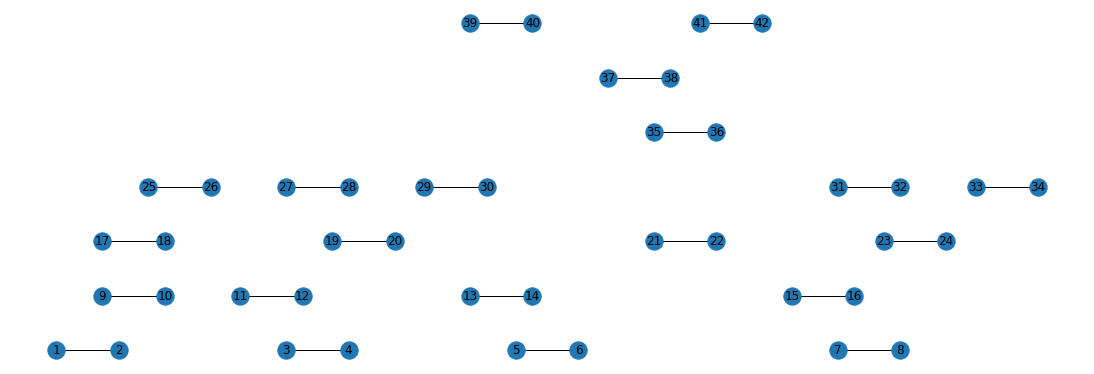

In [537]:
import random
from itertools import combinations

'''
RANDOM FEASIBLE SWAPS: MOVE ALL AFTER SWAP TIME
'''
trip_copy = create_trips(op_start, op_end, temp)

def trip_check(bus_1, bus_2, swap_time):
    trip_1 = None
    trip_2 = None
    temp_1 = None
    temp_2 = None
    
    for t in range(len(bus_1)):
        if bus_1[t][1] > swap_time:
            temp_1 =  bus_1[t]
            break

    for t in range(len(bus_2)):
        if bus_2[t][1] > swap_time:
            trip_2 = bus_2[t]
            temp_2 = bus_2[t]
    
    if temp_1 != None:
        for trip in trip_copy:
            if temp_1[0] == trip[0] and temp_1[1] == trip[1]:
                trip_1 = trip
                break

    if temp_2 != None:
        for trip in trip_copy:
            if temp_2[0] == trip[0] and temp_2[1] == trip[1]:
                trip_2 = trip
                break
    
    return (trip_1, trip_2)

sch = range(len(bus_schedule))
bus_sch = deepcopy(bus_schedule)
bus_1 = sch[0]+1
bus_2 = sch[1]+2

def swap_check(bus_schedule, swap_time):
    check = 0
    bus_sch = deepcopy(bus_schedule)
    bus_num = list(bus_sch.keys())
    while check == 0:
        random.shuffle(bus_num)
        t = random.uniform(op_start, op_end)

        bus_1 = bus_sch[bus_num[0]]
        bus_2 = bus_sch[bus_num[1]]
        old_bus_1 = deepcopy(bus_1)
        old_bus_2 = deepcopy(bus_2)
        trip_1, trip_2 = trip_check(bus_1, bus_2, t)

        if trip_1 != None and trip_2 != None:
            to_bus_1 = []
            to_bus_2 = []
            for trip in bus_1:
                if trip[1] > t:
                    to_bus_2.append(trip)
            for trip in bus_2:
                if trip[1] > t:
                    to_bus_1.append(trip)

            for el in to_bus_2:
                bus_1.remove(el)
            for el in to_bus_1:
                bus_2.remove(el)

            bus_1.extend(to_bus_1)
            bus_2.extend(to_bus_2)
            
            if new_sch_feas(bus_1, bus_2) == 0:
                t = random.uniform(op_start, op_end)
            else:
                if bus_1 != old_bus_2 and bus_2 != old_bus_1:
#                     bus_1, bus_2 = fix_trav(bus_1, bus_2, t)
                    print(old_bus_1)
                    print(old_bus_2)
                    print('-'*100)
                    return (bus_1, bus_2, bus_sch)
        else:
#             print('a'*20)
            t = random.uniform(op_start, op_end)

def new_sch_feas(bus_1, bus_2):
    for t in range(1,len(bus_1)):
        if bus_1[t][0] == bus_1[t-1][0]:
            return 0
    
    for t in range(1,len(bus_2)):
        if bus_2[t][0] == bus_2[t-1][0]:
            return 0
    
    return 1

def fix_trav(bus_1, bus_2, swap_time):
    for trip in range(len(bus_1)):
        if bus_1[trip][1] > swap_time:
            for t in trip_copy:
                if bus_1[trip][1] == t[1] and bus_1[trip][0] == t[0]:
                    bus_1[trip][-1] == bus_1[trip-1][-1] - t[-1]
    for trip in range(len(bus_2)):
        if bus_2[trip][1] > swap_time:
            for t in trip_copy:
                if bus_2[trip][1] == t[1] and bus_2[trip][0] == t[0]:
                    bus_2[trip][-1] == bus_2[trip-1][-1] - t[-1]
    
    return(bus_1, bus_2)
            
new_bus_1, new_bus_2, new_schd = swap_check(bus_sch, t)
print(new_bus_1)
print(new_bus_2)

ctr = 1
pos = {}
edges = []
edge_color = []
Trip_graph = nx.Graph()
for bus in new_schd.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        
fig = plt.figure(figsize=(15,5))
Trip_graph.add_nodes_from(pos)
Trip_graph.add_edges_from(edges)
nx.draw(Trip_graph, pos, with_labels = True)
plt.savefig('schedule_basic_all.png')

In [252]:
# new_schedule = {}

# dh_tripz = adjusted_dh(new_schd, deadhead_trips)

# trip_num = 0
# for bus in bus_schedule.keys():
#     new_sch = []
#     for trip in bus_schedule[bus]:
#         new_sch.append([('t', trip[0]), trip[1], trip[2], trip[3]])
#         trip_num += 1
    
#     for dh in dh_tripz:
#             if dh[0] == bus:
#                 new_sch.append([('d', None), dh[3], dh[4], dh[5]])
    
#     new_schedule[bus] = sorted(new_sch, key=lambda y: y[1])

# print(trip_num)
# # for bus in new_schedule.values():
# #     print(bus)
# #     print('-'*100)
# # trav = 0
# for bus in new_schedule.keys():
#     charging_trips = []
#     for t in range(1,len(new_schedule[bus])):
#         if new_schedule[bus][t][1] != new_schedule[bus][t-1][2]:
#             if new_schedule[bus][t-1][0][0] == 'd' and new_schedule[bus][t-1][0][0] == new_schedule[bus][t][0][0]:
#                 label = 'c'
#                 trav = b_range
#             else:
#                 label = 's'
#                 trav = new_schedule[bus][t-1][3]
#             charging_trips.append([(label, None), new_schedule[bus][t-1][2], new_schedule[bus][t][1], trav])
# #     for trip in charging_trips:
#     new_schedule[bus].extend(charging_trips)
#     new_schedule[bus].sort(key=lambda y: y[1])

# # print(new_schedule[1])
# # print('-'*100)

# ctr = 1
# pos = {}
# edges = []
# edge_color = []

# new_trip_graph = nx.Graph()
# for bus in new_schedule.items():
#     for seq in bus[1]:
#         pos[ctr] = (seq[1], bus[0])
#         ctr += 1
#         pos[ctr] = (seq[2], bus[0])
#         ctr += 1
#         edges.append((ctr-2,ctr-1))
#         if seq[0][0] == 't':
#             edge_color.append('red')
#         elif seq[0][0] == 'd':
#             edge_color.append('blue')
#         elif seq[0][0] == 'c':
#             edge_color.append('green')
#         else:
#             edge_color.append('yellow')

# fig = plt.figure(figsize=(30,10))
# new_trip_graph.add_nodes_from(pos)
# new_trip_graph.add_edges_from(edges)
# nx.draw(new_trip_graph, pos, with_labels = True, edge_color = edge_color, width = 10.0)
# plt.savefig('schedule_all.png')

In [612]:
import random
from itertools import combinations

'''
RANDOM FEASIBLE SWAPS: MOVE THE FIRST TRIPS AFTER SWAP TIME;
INSERT REST GREEDILY

'''

def trip_check(bus_1, bus_2, swap_time):
    trip_copy = create_trips(op_start, op_end, temp)
    trip_1 = None
    trip_2 = None
    temp_1 = None
    temp_2 = None
    
    for t in range(len(bus_1)):
        if bus_1[t][1] > swap_time:
            temp_1 =  bus_1[t]
            break

    for t in range(len(bus_2)):
        if bus_2[t][1] > swap_time:
            temp_2 = bus_2[t]
            break
    
    if temp_1 != None:
        for trip in trip_copy:
            if temp_1[0] == trip[0] and temp_1[1] == trip[1]:
                trip_1 = trip
                break

    if temp_2 != None:
        for trip in trip_copy:
            if temp_2[0] == trip[0] and temp_2[1] == trip[1]:
                trip_2 = trip
                break
    
    return (trip_1, trip_2)

sch = range(len(bus_schedule))
bus_sch = deepcopy(bus_schedule)
bus_1 = sch[0]+1
bus_2 = sch[1]+2

def swap_check(bus_schedule, dh_trips):
    check = 0
#     dh_trips_new = deepcopy(dh_trips)
#     bus_sch = deepcopy(bus_schedule)
#     bus_num = list(bus_sch.keys())
    while check == 0:
        dh_trips_new = deepcopy(dh_trips)
        bus_sch = deepcopy(bus_schedule)
        bus_num = list(bus_sch.keys())
        random.shuffle(bus_num)
        t = random.uniform(op_start, op_end)
        bus_1 = bus_sch[bus_num[0]]
        bus_2 = bus_sch[bus_num[1]]
        old_bus_1 = deepcopy(bus_1)
        old_bus_2 = deepcopy(bus_2)
        
        trip_1, trip_2 = trip_check(bus_1, bus_2, t)

        if trip_1 != None and trip_2 != None:
            temp_1 = None
            temp_2 = None
            rem_trips = []

            for trip in bus_1:
                if trip[1] == trip_1[1] and trip[2] == trip_1[2]:
                    temp_1 = trip
                if trip[1] > trip_1[2]:
                    rem_trips.append(trip)
            
            for trip in bus_2:
                if trip[1] == trip_2[1] and trip[2] == trip_2[2]:
                    temp_2 = trip
                if trip[1] > trip_2[2]:
                    rem_trips.append(trip)
            
            bus_1.remove(temp_1)
            bus_2.remove(temp_2)
            for el in rem_trips:
                if el in bus_1:
                    bus_1.remove(el)
                if el in bus_2:
                    bus_2.remove(el)
            
            bus_1.append(trip_2)
            bus_2.append(trip_1)
            
            # delete deadheads for buses 1,2 after swap
            # in particular, delete deadheads if their end time exceeds swapped trip's start time
            for dh in dh_trips:
#                 if dh[0] == bus_num[0] or dh[0] == bus_num[1]:
#                     dh_trips_new.remove(dh)
                if dh[0] == bus_num[0]:
#                     if dh[-2] > bus_1[-1][1]:
                    dh_trips_new.remove(dh)
                elif dh[0] == bus_num[1]:
#                     if dh[-2] > bus_2[-1][1]:
                    dh_trips_new.remove(dh)
            
            # remove last from depot
            max_1 = 0
            max_2 = 0
            max_1_dh = []
            max_2_dh = []
            for dh in dh_trips_new:
                if dh[0] == bus_num[0]:
                    if dh[-2] > max_1:
                        max_1 = dh[-2]
                        max_1_dh = dh
                if dh[0] == bus_num[1]:
                    if dh[-2] > max_2:
                        max_2 = dh[-2]
                        max_2_dh = dh
            
            last_1 = None
            last_2 = None
            
#             print(max_1_dh)
#             print(max_2_dh)
#             print('A'*100)
            if  max_1_dh != []:
                if max_1_dh[-2] > bus_1[-1][-2]:
                    last_1 = max_1_dh
            if max_2_dh != []:
                if max_2_dh[-2] > bus_2[-1][-2]:
                    last_2 = max_2_dh

            nsf1 = new_sch_feas_test(bus_1, bus_num[0], last_1)
            nsf2 = new_sch_feas_test(bus_2, bus_num[1], last_2)
            if nsf1[0] == 0 or nsf2[0] == 0:
#                 t = random.uniform(op_start, op_end)
                continue
            else:
                if bus_1 != old_bus_2 and bus_2 != old_bus_1:
                    bus_1_dh = nsf1[1]
                    bus_2_dh = nsf2[1]
#                     print(bus_1_dh, ' & ', bus_2_dh)
                    if bus_1_dh is None and bus_2_dh is None:
                        continue
                    else:
                        # SOMETHING WRONG WITH DEADHEAD; THERE ARE EXTRAS/DUPLICATES
                        if bus_1_dh is not None:
                            dh_trips_new.extend(bus_1_dh)
                            
                        if bus_2_dh is not None:
                            dh_trips_new.extend(bus_2_dh)
                            
                        for trip in rem_trips:
                            for orig_trip in trip_copy:
                                if trip[0] == orig_trip[0] and trip[1] == orig_trip[1] and trip[2] == orig_trip[2]:
                                    trip[-1] = orig_trip[-1]
                            
                        return (bus_1, bus_2, bus_sch, rem_trips, old_bus_1, old_bus_2, dh_trips_new)

        else:
            t = random.uniform(op_start, op_end)

def new_sch_feas_test(bus, bus_id, last):
#     print(bus)
    if len(bus) > 1:
        if bus[-1][0] == bus[-2][0]:
#             print('a')
            return [0, None]
            # CAN'T HAVE CONSECUTIVE TRIPS WITH THE SAME LABEL
        else:
            # FIGURE OUT LAST TRIP; DEADHEAD OR SERVICE
            start_stop = lines[bus[-1][0]][0]
            end_stop = lines[bus[-1][0]][1]
            
            if last is None:
                prev_stop = lines[bus[-2][0]][1]
                prev_trip_end = bus[-2][2]
                prev_trip_start = bus[-2][1]
                rem_fuel = bus[-2][-1]
                prev_stop_dists = possible_swap(prev_stop, stop_dist)
                for d in prev_stop_dists:
                    if d[0] == depot_node[0]:
                        charge_trip_next = d[1]
            else:
#                 print(last)

                prev_stop = last[2]
                prev_trip_end = last[-2]
                prev_trip_start = last[-3]
                rem_fuel = last[-1]
                charge_trip_next = 0
            
            curr_trip_start = bus[-1][1]

            for st in stop_dist[prev_stop]:
#                 print(st)
                if start_stop == st[0]:
                    if round(curr_trip_start - prev_trip_end, 2) < round(st[1]/speed, 2):
                        return [0, None]
                        # TIME REQUIRED FOR DEADHEAD IS MORE THAN THE TIME WINDOW B/W 2 TRIPS
                    else:
                        
                        start_stop_dists = possible_swap(start_stop, stop_dist)
                        for d in start_stop_dists:
                            if d[0] == depot_node[0]:
                                charge_trip_to = d[1]
                        
                        # CHECKING IF BUS CAN MAKE THE NEWLY ADDED TRIP
                        # NEXT CONDITION CHECKS FOR FUEL; SECOND LAST + DEADHEAD TO LAST + LAST
                        if rem_fuel - st[1] - bus[-1][-1] <= 0:
                            # ADD CHARGING TIME
#                             refuel_time = round((b_range - trav + charge_trip_curr) /batt_cap, 2)
                            refuel_time = round((b_range - trav + charge_trip_curr) /b_range, 2)
                            if prev_trip_end + refuel_time + (charge_trip_next + charge_trip_to)/speed > curr_trip_start:
                                return [0, None]
                                # NOT ENOUGH FUEL FOR THE LAST TRIP AND NO TIME IN BETWEEN TO CHARGE
                            else: #CHECK IF TIME FRAME ENOUGH FOR CHARGING
                                new_dh = insert_charging_trip(bus_id, bus[-2], bus[-1])
#                                 print('a', new_dh)
#                                 print(bus[-1][-1])
                                bus[-1][-1] = round(b_range - bus[-1][-1] - charge_trip_to, 2)
                                return [1, new_dh]
                                # CHARGING POSSIBLE IN BETWEEN

                        else:
                            if rem_fuel - st[1] - bus[-1][-1] - charge_trip_to <= 0:
                                return [0, None]
                            else:
                                new_dh = insert_charging_trip(bus_id, bus[-1], None)
                                if new_dh is None:
                                    return [0, None]
                                else:
                                    bus[-1][-1] = b_range #round(rem_fuel - bus[-1][-1] - st[1], 2)
                                    return [1, new_dh]
                            # LAST TRIP POSSIBLE
    else:
        bus[-1][-1] = round(b_range - bus[-1][-1], 2)
        return [1, None]
        # SWAPPED TRIP IS THE FIRST POSSIBLE

def insert_charging_trip(bus_id, second_last_trip, last_trip):
    new_dh_trips = []
    trav = second_last_trip[-1]
    curr_stop = lines[second_last_trip[0]][1]
    curr_time = second_last_trip[2]

    for d in stop_dist[curr_stop]:
        if d[0] == depot_node[0]:
            charge_trip_curr = d[1]

    trip_to_depot = [bus_id, curr_stop, depot_node[0], curr_time, round(curr_time + (charge_trip_curr/speed),2), round(trav - charge_trip_curr,2)]
    
    new_dh_trips.append(trip_to_depot)
    
#     refuel_time = round((b_range - trav + charge_trip_curr) * 0.1, 2)
    refuel_time = round((b_range - trav + charge_trip_curr)/b_range, 2)
    # CONSIDER PARTIAL CHARGING: max(?)
    
    curr_time_new = round(curr_time + (charge_trip_curr/speed) + refuel_time, 2)
    
    if last_trip is not None:
        nxt_stop_dists = possible_swap(lines[last_trip[0]][0], stop_dist)
        for d in nxt_stop_dists:
            if d[0] == depot_node[0]:
                charge_trip_next = d[1]
        
        new_trav = round(b_range - charge_trip_next, 2)
#         if curr_time_new + (charge_trip_curr/speed) <= op_end:
        
        trip_from_depot = [bus_id, depot_node[0], lines[last_trip[0]][0], curr_time_new, round(curr_time_new + (charge_trip_next/speed),2), new_trav]
#         if trip_from_depot[-2] > last_trip[1]:
#             return None
#         else:
        new_dh_trips.append(trip_from_depot)
#         print(new_trav)
        return new_dh_trips
#         else:
#             l
    else:
        if trip_to_depot[-1] < 0:
            return None, None
        else:
            return new_dh_trips

# CAN POSSIBLY REMOVE DEADHEAD TRIPS LEAVING DEPOT

check = 0
dht = deepcopy(deadhead_trips)

new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, temp_dht_new = swap_check(bus_sch, dht)


# for i in range(1000):
#     if check == 1:
#         break
#     bus_sch = deepcopy(bus_schedule)
#     new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2 = swap_check(bus_sch, t)
#     for i in range(1,len(new_bus_1)):
#         if new_bus_1[i-1][0] == new_bus_1[i][0]:
#             print(new_bus_1, new_bus_2, old_bus_1, old_bus_2)
#             check == 1
#             break
#     if check == 1:
#         break
#     for i in range(1,len(new_bus_2)):
#         if new_bus_2[i-1][0] == new_bus_2[i][0]:
#             print(new_bus_1, new_bus_2, old_bus_1, old_bus_2)
#             check == 1
#             break
# print('-'*100)

# print(old_bus_1)
# print(old_bus_2)
# print('^'*50)
# print(new_bus_1)
# print(new_bus_2)
# print('-'*50)
# for dh in dht:
#     print(dh)

# print(len(deadhead_trips),', ', len(dht_new))

# for i in range(1,len(new_bus_1)):
#     if new_bus_1[i-1][0] == new_bus_1[i][0]:
#         print(new_bus_1)
#         break

# for i in range(1,len(new_bus_2)):
#     if new_bus_2[i-1][0] == new_bus_2[i][0]:
#         print(new_bus_2)
#         break

'''
ADD DEADHEADS FOR WHEN BUS CHANGES LINES
'''

# print(rem_trips)
# print('-'*50)

# print(new_bus_1)
# print('-'*50)

temp_sch = {}
for bus in bus_sch.items():
    if old_bus_1 == bus[1]:
        temp_sch[bus[0]] = new_schd[bus[0]]
    elif old_bus_2 == bus[1]:
        temp_sch[bus[0]] = new_schd[bus[0]]


for bus in temp_sch.items():
    print(bus[0])
    print('^'*5)
    for t in bus[1]:
        print(t)
    print('-'*50)

temp_dht = []

for dh in temp_dht_new:
    if dh is not None:
        print(dh)
        if dh[0] in temp_sch.keys():
#             if dh not in temp_dht:
            temp_dht.append(dh)
print('-'*50)

for dh in temp_dht:
    print(dh)
# print('-'*50)

dht_new = deepcopy(temp_dht)
# for dh in dht_new:
#     if dh[0] in temp_sch.keys()
#         print(dh)  

ctr = 1
pos = {}
edges = []
edge_color = []
Trip_graph = nx.Graph()
for bus in new_schd.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))      
        
fig = plt.figure(figsize=(15,5))
Trip_graph.add_nodes_from(pos)
Trip_graph.add_edges_from(edges)
nx.draw(Trip_graph, pos, with_labels = True)
plt.savefig('new_schedule_basic.png')

NameError: name 'charge_trip_curr' is not defined

In [190]:
# import random
# from itertools import combinations

# def trip_check(bus_1, bus_2, swap_time):
#     trip_copy = create_trips(op_start, op_end, temp)
    
#     trip_1 = None
#     trip_2 = None
#     temp_1 = None
#     temp_2 = None
    
#     for t in range(len(bus_1)):
#         if bus_1[t][1] > swap_time:
#             temp_1 =  bus_1[t]
#             break

#     for t in range(len(bus_2)):
#         if bus_2[t][1] > swap_time:
#             temp_2 = bus_2[t]
#             break
    
#     if temp_1 != None:
#         for trip in trip_copy:
#             if temp_1[0] == trip[0] and temp_1[1] == trip[1]:
# #                 print(trip)
#                 trip_1 = trip
#                 break

#     if temp_2 != None:
#         for trip in trip_copy:
#             if temp_2[0] == trip[0] and temp_2[1] == trip[1]:
# #                 print(trip)
#                 trip_2 = trip
#                 break
    
# #     print(bus_1)
# #     print(bus_2)
# #     print('%'*50)
#     return (trip_1, trip_2)

# def swap_check(bus_schedule, dh_trips):
#     check = 0
# #     dh_trips_new = deepcopy(dh_trips)
# #     bus_sch = deepcopy(bus_schedule)
# #     bus_num = list(bus_sch.keys())
#     iterat = 0
#     while check == 0:
#         dh_trips_new = deepcopy(dh_trips)
#         bus_sch = deepcopy(bus_schedule)
#         bus_num = list(bus_sch.keys())
#         random.shuffle(bus_num)
#         t = random.uniform(op_start, op_end)
#         bus_1 = bus_sch[bus_num[0]]
#         bus_2 = bus_sch[bus_num[1]]
#         old_bus_1 = deepcopy(bus_1)
#         old_bus_2 = deepcopy(bus_2)
        
#         trip_1, trip_2 = trip_check(bus_1, bus_2, t)
        
#         if trip_1 != None and trip_2 != None:
#             temp_1 = None
#             temp_2 = None
#             rem_trips = []

#             for trip in bus_1:
#                 if trip[1] == trip_1[1] and trip[2] == trip_1[2]:
#                     temp_1 = trip
#                 if trip[1] > trip_1[2]:
#                     rem_trips.append(trip)
            
#             for trip in bus_2:
#                 if trip[1] == trip_2[1] and trip[2] == trip_2[2]:
#                     temp_2 = trip
#                 if trip[1] > trip_2[2]:
#                     rem_trips.append(trip)
            
# #             print(iterat)
# #             print(temp_1)
# #             print(temp_2)
            
#             bus_1.remove(temp_1)
#             bus_2.remove(temp_2)
#             for el in rem_trips:
#                 if el in bus_1:
#                     bus_1.remove(el)
#                 if el in bus_2:
#                     bus_2.remove(el)
            
# #             print(trip_1, trip_2)
# #             print('%'*50)
            
#             bus_1.append(trip_2)
#             bus_2.append(trip_1)
            
# #             if bus_num[0] == 6 and bus_num[1] == 7:
# #                 print(bus_1)
# #                 print(bus_2)
# #                 break
#             # delete deadheads for buses 1,2 after swap
#             # in particular, delete deadheads if their end time exceeds swapped trip's start time
#             for dh in dh_trips:
# #                 if dh[0] == bus_num[0] or dh[0] == bus_num[1]:
# #                     dh_trips_new.remove(dh)
#                 if dh[0] == bus_num[0]:
#                     if dh[-2] > bus_1[-1][1]:
#                         dh_trips_new.remove(dh)
#                 elif dh[0] == bus_num[1]:
#                     if dh[-2] > bus_2[-1][1]:
#                         dh_trips_new.remove(dh)
            
#             # remove last from depot
#             max_1 = 0
#             max_2 = 0
#             max_1_dh = []
#             max_2_dh = []
            
#             for dh in dh_trips_new:
#                 if dh[0] == bus_num[0] and len(bus_1) > 1:
#                     if dh[-2] > max_1 and dh[1] != depot_node[0]:
#                         max_1 = dh[-2]
#                         max_1_dh = dh
#                 if dh[0] == bus_num[1] and len(bus_2) > 1:
#                     if dh[-2] > max_2 and dh[1] != depot_node[0]:
#                         max_2 = dh[-2]
#                         max_2_dh = dh
            
#             last_1 = None
#             last_2 = None
            
# #             print('[]'*50)
# #             print(bus_num[0], bus_1)
# #             print(bus_num[1], bus_2)
# #             print(max_1_dh)
# #             print(bus_1[-1][1])
# #             print(max_2_dh)
# #             print('{}'*50)
# #             print(bus_2[-1][1])
# #             print('A'*100)
#             if  max_1_dh != []:
#                 if max_1_dh[-2] < bus_1[-1][1] and max_1_dh[-2] > bus_1[-2][1]:
#                     last_1 = max_1_dh
#             if max_2_dh != []:
#                 if max_2_dh[-2] < bus_2[-1][1] and max_2_dh[-2] > bus_2[-2][1]:
#                     last_2 = max_2_dh
            
# #             for dh in dh_trips_new:
# #                 if dh[0] == bus_num[0]:
# #                     if last_1 is not None:
# #                         if dh[-2] > last_1[-2]:
# #                             dh_trips_new.remove(dh)
# #                     else:
# #                         dh_trips_new.remove(dh)
# #                 elif dh[0] == bus_num[1]:
# #                     if last_2 is not None:
# #                         if dh[-2] > last_2[-2]:
# #                             dh_trips_new.remove(dh)    
# #                     else:
# #                         dh_trips_new.remove(dh)
# #             print('a', last_1, '&', last_2)
            
#             nsf1 = new_sch_feas_test(bus_1, bus_num[0], last_1)
#             nsf2 = new_sch_feas_test(bus_2, bus_num[1], last_2)
#             if nsf1[0] == 0 or nsf2[0] == 0:
# #                 print('INFEASIBLE')
# #                 t = random.uniform(op_start, op_end)
#                 continue
#             else:
#                 if bus_1 != old_bus_2 and bus_2 != old_bus_1:
#                     bus_1_dh = nsf1[1]
#                     bus_2_dh = nsf2[1]
# #                     print(bus_1_dh, ' & ', bus_2_dh)
#                     if bus_1_dh is None and bus_2_dh is None:
# #                         print(t, 'HAKAKAKAKAKAKAK')
# #                         print(bus_1)
# #                         print(bus_2)
# #                         print('s')
# #                         continue
#                         return (bus_1, bus_2, bus_sch, rem_trips, old_bus_1, old_bus_2, [])
#                     else:
#                         # SOMETHING WRONG WITH DEADHEAD; THERE ARE EXTRAS/DUPLICATES
                        
#                         dh_to_rem = []
#                         if bus_1_dh is not None:
                            
# #                             for dh in dh_trips_new:
# #                                 if dh[0] == bus_num[0]:
# #                                     print(dh)
# #                             print('^'*30)
                            
# #                             print(bus_1_dh)
# #                             print('#'*30)
                            
#                             timer = bus_1_dh[0][-3]
                            
#                             for old_dht in dh_trips_new:
#                                 if old_dht[0] == bus_num[0]:
#                                     if old_dht[-3] >= timer:
#                                         dh_to_rem.append(old_dht)
                            
#                             for dh in dh_to_rem:
#                                 dh_trips_new.remove(dh)

#                             dh_trips_new.extend(bus_1_dh)
# #                             print('LKLKLK')
                        
#                         dh_to_rem = []
#                         if bus_2_dh is not None:
# #                             print('Nope')
# #                             for dh in dh_trips_new:
# #                                 if dh[0] == bus_num[1]:
# #                                     print(dh)
# #                             print('^'*30)
                            
# #                             print(bus_2_dh)
# #                             print('#'*30)
                            
# #                             print(bus_2_dh)
#                             timer = bus_2_dh[0][-3]
                            
#                             for old_dht in dh_trips_new:
#                                 if old_dht[0] == bus_num[1]:
#                                     if old_dht[-3] >= timer:
#                                         dh_to_rem.append(old_dht)
                            
#                             for dh in dh_to_rem:
#                                 dh_trips_new.remove(dh)

#                             dh_trips_new.extend(bus_2_dh)
                        
#                         print('GHGHGHGH')
#                         print(bus_num[0], last_1, bus_1, bus_1_dh)
#                         print(bus_num[1], last_2, bus_2, bus_2_dh)
                        
#                         for trip in rem_trips:
#                             for orig_trip in trip_copy:
#                                 if trip[0] == orig_trip[0] and trip[1] == orig_trip[1] and trip[2] == orig_trip[2]:
# #                                     print(orig_trip[-1])
#                                     trip[-1] = orig_trip[-1]
                                    
# #                         dh_trips_updated = []
# #                         for dh in dh_trips_new:
# #                             if dh not in dh_trips_updated:
# #                                 dh_trips_updated.append(dh)
# #                         print(bus_num[0], bus_num[1])
#                         return (bus_1, bus_2, bus_sch, rem_trips, old_bus_1, old_bus_2, dh_trips_new)

#         else:
#             t = random.uniform(op_start, op_end)
#             iterat += 1

# def new_sch_feas_test(bus, bus_id, last):  
#     buffer = 0.03
#     if len(bus) > 1:
#         if bus[-1][0] == bus[-2][0]:
# #             print('a')
#             return [0, None]
#             # CAN'T HAVE CONSECUTIVE TRIPS WITH THE SAME LABEL
#         else:
#             # FIGURE OUT LAST TRIP; DEADHEAD OR SERVICE
#             start_stop = lines[bus[-1][0]][0]
#             end_stop = lines[bus[-1][0]][1]
            
#             if last is None:
#                 prev_stop = lines[bus[-2][0]][1]
#                 prev_trip_end = bus[-2][2]
#                 prev_trip_start = bus[-2][1]
#                 rem_fuel = bus[-2][-1]
# #                 print('HAHAHAHA')
#                 prev_stop_dists = possible_swap(prev_stop, stop_dist)
#                 for d in prev_stop_dists:
#                     if d[0] == depot_node[0]:
#                         charge_trip_next = d[1]
                        
# #                 print(bus_id, bus)
#             else:
# #                 print('b', last)

#                 prev_stop = last[2]
#                 prev_trip_end = last[-2]
#                 prev_trip_start = last[-3]
#                 rem_fuel = last[-1]
#                 charge_trip_next = 0
            
#             curr_trip_start = bus[-1][1]

#             for st in stop_dist[prev_stop]:

#                 if start_stop == st[0]:
                    
#                     if round(curr_trip_start - prev_trip_end - buffer, 2) < round(st[1]/speed, 2):
#                         return [0, None]
#                         # TIME REQUIRED FOR DEADHEAD IS MORE THAN THE TIME WINDOW B/W 2 TRIPS
#                     else:
#                         start_stop_dists = possible_swap(start_stop, stop_dist)
#                         for d in start_stop_dists:
#                             if d[0] == depot_node[0]:
#                                 charge_trip_to = d[1]
                        
#                         # CHECKING IF BUS CAN MAKE THE NEWLY ADDED TRIP
#                         # NEXT CONDITION CHECKS FOR FUEL; SECOND LAST + DEADHEAD TO LAST + LAST
                        
#                         refuel_time = round((b_range - rem_fuel + charge_trip_next)/b_range , 2)
                        
#                         if rem_fuel - st[1] - bus[-1][-1] <= 0:

#                             if prev_trip_end + buffer + refuel_time + (charge_trip_next + charge_trip_to)/speed > curr_trip_start:
#                                 return [0, None]
#                                 # NOT ENOUGH FUEL FOR THE LAST TRIP AND NO TIME IN BETWEEN TO CHARGE
                            
#                             else:
# #                                 print('a')
# #                                 print('b', bus_id)
                                
#                                 new_dh = insert_charging_trip(bus, bus_id, bus[-2], bus[-1])

#                                 bus[-1][-1] = round(b_range - bus[-1][-1] - charge_trip_to, 2)

#                                 return [1, new_dh]
#                                 # CHARGING POSSIBLE IN BETWEEN

#                         else: #POSSIBLE TO DEADHEAD TO NEXT TRIP AND MAKE TRIP
#                             end_stop_dists = possible_swap(end_stop, stop_dist)
#                             for d in end_stop_dists:
#                                 if d[0] == depot_node[0]:
#                                     charge_trip_end = d[1]

#                             if rem_fuel - st[1] - bus[-1][-1] - charge_trip_end <= 0:
#                                 return [0, None]
                                
#                                 # NOT ENOUGH FUEL TO REACH DEPOT AFTER NEW TRIP

#                             else:
# #                                 print(curr_trip_start, prev_trip_end, refuel_time, (charge_trip_next + charge_trip_to)/speed)
#                                 if prev_trip_end + buffer + refuel_time + (charge_trip_next + charge_trip_to)/speed < curr_trip_start:
# #                                     print(bus[-1][-1], charge_trip_to)
                                    
#                                     new_dh = insert_charging_trip(bus, bus_id, bus[-2], bus[-1])
#                                     bus[-1][-1] = round(b_range - bus[-1][-1] - charge_trip_to, 2)
#                                     return [1, new_dh]
                                    
#                                     # ENOUGH TIME TO CHARGE BETWEEN LAST AND NEWLY ADDED TRIP
                
#                                 else:
# #                                     print('HELO')
# #                                     print(bus_id, prev_stop, start_stop)
#                                     if prev_stop != start_stop:
#                                         new_dh = [[bus_id, prev_stop, start_stop, prev_trip_end, round(prev_trip_end + (st[1]/speed),2), round(rem_fuel - st[1],2)]]
#                                         bus[-1][-1] = round(rem_fuel - st[1] - bus[-1][-1], 2)
#                                         return [1, new_dh]
#                                     else:
#                                         print('BAAAAAAJAJASJ')
#                                         bus[-1][-1] = round(rem_fuel - st[1] - bus[-1][-1], 2)
#                                         print(bus_id, bus)
#                                         return [1, None]
# #                                     new_dh = insert_charging_trip(bus, bus_id, bus[-1], None)
# #                                     if new_dh is None:
# #                                         return [0, None]
# #                                     else:
# #                                         print(prev_trip_end, rem_fuel, refuel_time, charge_trip_next, charge_trip_to)
# #                                         print(bus_id, bus)
# #                                         print(new_dh)
# #                                         print('-'*100)
# #                                         bus[-1][-1] = round(rem_fuel - bus[-1][-1] - st[1], 2)
# #                                         return [1, new_dh]
#                             # LAST TRIP POSSIBLE
#     else:
# #         print(last, bus[-1][-1])
#         bus[-1][-1] = round(b_range - bus[-1][-1], 2)
# #         print(bus[-1][-1])
#         return [1, None]
#         # SWAPPED TRIP IS THE FIRST POSSIBLE

# def insert_charging_trip(bus, bus_id, second_last_trip, last_trip):
#     new_dh_trips = []
#     trav = second_last_trip[-1]
#     curr_stop = lines[second_last_trip[0]][1]
#     curr_time = second_last_trip[2]

#     for d in stop_dist[curr_stop]:
#         if d[0] == depot_node[0]:
#             charge_trip_curr = d[1]

#     trip_to_depot = [bus_id, curr_stop, depot_node[0], curr_time, round(curr_time + (charge_trip_curr/speed),2), round(trav - charge_trip_curr,2)]
    
#     new_dh_trips.append(trip_to_depot)
    
# #     refuel_time = round((b_range - trav + charge_trip_curr) * 0.1, 2)
#     refuel_time = round((b_range - trav + charge_trip_curr)/b_range, 2)
#     # CONSIDER PARTIAL CHARGING: max(?)
    
#     curr_time_new = round(curr_time + (charge_trip_curr/speed) + refuel_time, 2)
    
#     if last_trip is not None:

#         nxt_stop_dists = possible_swap(lines[last_trip[0]][0], stop_dist)
#         for d in nxt_stop_dists:
#             if d[0] == depot_node[0]:
#                 charge_trip_next = d[1]
        
#         new_trav = round(b_range - charge_trip_next, 2)
        
#         trip_from_depot = [bus_id, depot_node[0], lines[last_trip[0]][0], curr_time_new, round(curr_time_new + (charge_trip_next/speed),2), new_trav]

#         new_dh_trips.append(trip_from_depot)
        
# #         print('Both', bus_id)
# #         print(new_dh_trips)

#         return new_dh_trips

#     else:
#         if trip_to_depot[-1] < 0:
#             return None
#         else:
# #             print('One', bus_id, bus)
# #             print(second_last_trip)
# #             print(trav, charge_trip_curr)
# #             print('$'*50)
            
#             return new_dh_trips

# bus_sch = deepcopy(bus_schedule)

# dht = deepcopy(deadhead_trips)
# # for dh in dht:
# #     print(dh)
# # print('-'*50)

# check_bus_1 = 1
# check_bus_2 = 1
# while check_bus_1 == 1 and check_bus_2 == 1:
# #     new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, dht_new = swap_check(bus_sch, dht)
#     new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, dht_new = swap_check(new_new_s, new_new_dht)
#     check_bus_1 = len(new_bus_1)
#     check_bus_2 = len(new_bus_2)


# temp_sch = {}
# trip_ct = 0

# for bus in new_schd.values():
#     trip_ct += len(bus)

# print('Trip count ', trip_ct)

# # for bus in bus_sch.items():
# #     if old_bus_1 == bus[1]:
# #         temp_sch[bus[0]] = new_schd[bus[0]]
# #     elif old_bus_2 == bus[1]:
# #         temp_sch[bus[0]] = new_schd[bus[0]]

# for bus in new_new_s.items():
#     if old_bus_1 == bus[1]:
#         temp_sch[bus[0]] = new_schd[bus[0]]
#     elif old_bus_2 == bus[1]:
#         temp_sch[bus[0]] = new_schd[bus[0]]

# # print(old_bus_1)
# # print('-'*50)
        
# for bus in temp_sch.items():
#     print(bus[0])
#     print('^'*5)
#     for t in bus[1]:
#         print(t)
#     print('-'*50)

# print('Rem trips ', len(rem_trips))
# # for t in rem_trips:
# #     print(t)

# # print(len(dht_new))
# # print('-'*50)

# for dh in dht_new:
#     if dh is not None:
#         if dh[0] in temp_sch.keys():
#             print(dh)

# ctr = 1
# pos = {}
# edges = []
# edge_color = []
# Trip_graph = nx.Graph()
# for bus in new_schd.items():
#     for seq in bus[1]:
#         pos[ctr] = (seq[1], bus[0])
#         ctr += 1
#         pos[ctr] = (seq[2], bus[0])
#         ctr += 1
#         edges.append((ctr-2,ctr-1))      
        
# fig = plt.figure(figsize=(15,5))
# Trip_graph.add_nodes_from(pos)
# Trip_graph.add_edges_from(edges)
# nx.draw(Trip_graph, pos, with_labels = True)
# plt.savefig('new_schedule_basic.png')

THIS IS THE CORRECT ONE

Trip count  19
1
^^^^^
['l1', 9.0, 9.34, 39]
['l2', 10.25, 10.59, 26.98]
['l1', 12.0, 12.34, 14.96]
--------------------------------------------------
6
^^^^^
['l1', 11.0, 11.34, 39.42]
--------------------------------------------------
Rem trips  2
['l2', 13.25, 13.59, 12.02]
['l1', 14.0, 14.34, 12.02]
Dh_trips  6
[2, 53075, 52654, 11.59, 11.83, 6.4]
[2, 52654, 53075, 12.72, 12.96, 51.44]
[3, 53045, 52654, 10.84, 10.97, 22.45]
[3, 52654, 53045, 11.6, 11.73, 55.5]
[4, 53045, 52654, 11.84, 11.97, 10.4]
[4, 52654, 53045, 12.8, 12.93, 55.5]


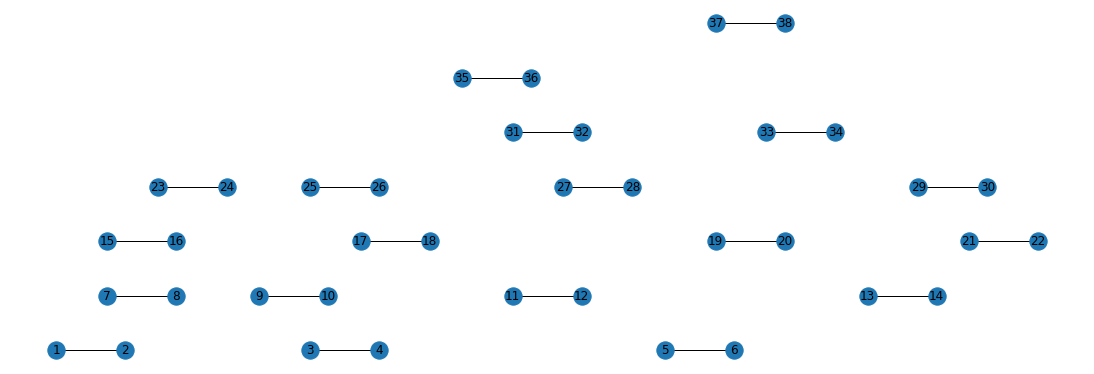

In [12]:
import random
from itertools import combinations

def trip_check(bus_1, bus_2, swap_time):
    trip_copy = create_trips(op_start, op_end, temp)
    
    trip_1 = None
    trip_2 = None
    temp_1 = None
    temp_2 = None
    
    for t in range(len(bus_1)):
        if bus_1[t][1] > swap_time:
            temp_1 =  bus_1[t]
            break

    for t in range(len(bus_2)):
        if bus_2[t][1] > swap_time:
            temp_2 = bus_2[t]
            break
    
    if temp_1 != None:
        for trip in trip_copy:
            if temp_1[0] == trip[0] and temp_1[1] == trip[1]:
#                 print(trip)
                trip_1 = trip
                break

    if temp_2 != None:
        for trip in trip_copy:
            if temp_2[0] == trip[0] and temp_2[1] == trip[1]:
#                 print(trip)
                trip_2 = trip
                break
    
#     print(bus_1)
#     print(bus_2)
#     print('%'*50)
    return (trip_1, trip_2)

def swap_check(bus_schedule, dh_trips):
    check = 0
#     dh_trips_new = deepcopy(dh_trips)
#     bus_sch = deepcopy(bus_schedule)
#     bus_num = list(bus_sch.keys())
    iterat = 0
    while check == 0:
        dh_trips_new = deepcopy(dh_trips)
        bus_sch = deepcopy(bus_schedule)
        bus_num = list(bus_sch.keys())
        random.shuffle(bus_num)
        t = random.uniform(op_start, op_end)
        bus_1 = bus_sch[bus_num[0]]
        bus_2 = bus_sch[bus_num[1]]
        old_bus_1 = deepcopy(bus_1)
        old_bus_2 = deepcopy(bus_2)
        
        trip_1, trip_2 = trip_check(bus_1, bus_2, t)
        
        if trip_1 != None and trip_2 != None:
            temp_1 = None
            temp_2 = None
            rem_trips = []

            for trip in bus_1:
                if trip[1] == trip_1[1] and trip[2] == trip_1[2]:
                    temp_1 = trip
                if trip[1] > trip_1[2]:
                    rem_trips.append(trip)
            
            for trip in bus_2:
                if trip[1] == trip_2[1] and trip[2] == trip_2[2]:
                    temp_2 = trip
                if trip[1] > trip_2[2]:
                    rem_trips.append(trip)
            
#             print(iterat)
#             print(temp_1)
#             print(temp_2)
            
            bus_1.remove(temp_1)
            bus_2.remove(temp_2)
            for el in rem_trips:
                if el in bus_1:
                    bus_1.remove(el)
                if el in bus_2:
                    bus_2.remove(el)
            
            bus_1.append(trip_2)
            bus_2.append(trip_1)

#             print(bus_num[0], bus_1)
#             print(bus_num[1], bus_2)
#             print('-'*100)
            

            for dh in dh_trips:
                if dh[0] == bus_num[0]:
#                     print(dh, len(bus_1), 'a')
                    if len(bus_1) > 1:
                        if dh[-3] > bus_1[-2][1]:
                            dh_trips_new.remove(dh)
                    else:
                        dh_trips_new.remove(dh)
                elif dh[0] == bus_num[1]:
#                     print(dh, len(bus_2), 'b')
                    if len(bus_2) > 1:
                        if dh[-3] > bus_2[-2][1]:
                            dh_trips_new.remove(dh)
                    else:
                        dh_trips_new.remove(dh)
            
            # delete deadheads for buses 1,2 after swap
            # in particular, delete deadheads if their end time exceeds swapped trip's start time
            
            nsf1 = new_sch_feas_test(bus_1, bus_num[0])
            nsf2 = new_sch_feas_test(bus_2, bus_num[1])
            
            if nsf1[0] == 0 or nsf2[0] == 0:
                continue
            else:
                if bus_1 != old_bus_2 and bus_2 != old_bus_1:
                    bus_1_dh = nsf1[1]
                    bus_2_dh = nsf2[1]

                    if bus_1_dh is None and bus_2_dh is None:
                        
#                         print('c', len(dh_trips_new))
                        for trip in rem_trips:
                            for orig_trip in trip_copy:
                                if trip[0] == orig_trip[0] and trip[1] == orig_trip[1] and trip[2] == orig_trip[2]:
                                    trip[-1] = orig_trip[-1]
                        
                        return (bus_1, bus_2, bus_sch, rem_trips, old_bus_1, old_bus_2, dh_trips_new)
                    
                    else:
#                         print('a', len(dh_trips_new))
                        
                        dh_to_rem = []
                        
                        if bus_1_dh is not None:
                            
                            timer = bus_1_dh[0][-3]
                            
                            for old_dht in dh_trips_new:
                                if old_dht[0] == bus_num[0]:
                                    if old_dht[-3] >= timer:
                                        dh_to_rem.append(old_dht)
                            
                            for dh in dh_to_rem:
                                dh_trips_new.remove(dh)

                            dh_trips_new.extend(bus_1_dh)

                        
                        dh_to_rem = []
                        if bus_2_dh is not None:
                            
                            timer = bus_2_dh[0][-3]
                            
                            for old_dht in dh_trips_new:
                                if old_dht[0] == bus_num[1]:
                                    if old_dht[-3] >= timer:
                                        dh_to_rem.append(old_dht)
                            
                            for dh in dh_to_rem:
                                dh_trips_new.remove(dh)

                            dh_trips_new.extend(bus_2_dh)
                        
#                         print(len(dh_trips_new))
                        
                        for trip in rem_trips:
                            for orig_trip in trip_copy:
                                if trip[0] == orig_trip[0] and trip[1] == orig_trip[1] and trip[2] == orig_trip[2]:
                                    trip[-1] = orig_trip[-1]
                                    
                        return (bus_1, bus_2, bus_sch, rem_trips, old_bus_1, old_bus_2, dh_trips_new)

        else:
            t = random.uniform(op_start, op_end)
            iterat += 1

def new_sch_feas_test(bus, bus_id):  
    buffer = 0.03
    if len(bus) > 1:
        if bus[-1][0] == bus[-2][0]:
#             print('a')
            return [0, None]
            # CAN'T HAVE CONSECUTIVE TRIPS WITH THE SAME LABEL
        else:
            # FIGURE OUT LAST TRIP; DEADHEAD OR SERVICE
            start_stop = lines[bus[-1][0]][0]
            end_stop = lines[bus[-1][0]][1]
            
            prev_stop = lines[bus[-2][0]][1]
            prev_trip_end = bus[-2][2]
            prev_trip_start = bus[-2][1]
            rem_fuel = bus[-2][-1]

            prev_stop_dists = possible_swap(prev_stop, stop_dist)
            for d in prev_stop_dists:
                if d[0] == depot_node[0]:
                    charge_trip_next = d[1]
            
            curr_trip_start = bus[-1][1]

            for st in stop_dist[prev_stop]:

                if start_stop == st[0]:
                    
                    if prev_trip_end + buffer + st[1]/speed > curr_trip_start:
                        return [0, None]
                        # TIME REQUIRED FOR DEADHEAD IS MORE THAN THE TIME WINDOW B/W 2 TRIPS
                    else:
                        start_stop_dists = possible_swap(start_stop, stop_dist)
                        for d in start_stop_dists:
                            if d[0] == depot_node[0]:
                                charge_trip_to = d[1]
                        
                        end_stop_dists = possible_swap(end_stop, stop_dist)
                        for d in end_stop_dists:
                            if d[0] == depot_node[0]:
                                charge_trip_end = d[1]
                        
                        refuel_time = round((b_range - rem_fuel + charge_trip_next)/b_range , 2)
                        
                        if rem_fuel - st[1] - bus[-1][-1] - charge_trip_end <= 0:

                            if prev_trip_end + buffer + refuel_time + (charge_trip_next + charge_trip_to)/speed > curr_trip_start:
                                
                                return [0, None]
                                
                                # NOT ENOUGH FUEL FOR THE LAST TRIP AND NO TIME IN BETWEEN TO CHARGE
                            
                            else:
                                charging_start_time = round(prev_trip_end + charge_trip_next/speed, 2)
                                trip_to_depot = [bus_id, prev_stop, depot_node[0], prev_trip_end, charging_start_time, round(rem_fuel - charge_trip_next,2)]
                                trip_from_depot = [bus_id, depot_node[0], start_stop, round(charging_start_time + refuel_time, 2), round(charging_start_time + refuel_time + (charge_trip_to/speed),2), round(b_range - charge_trip_to, 2)]
                                new_dh = [trip_to_depot, trip_from_depot]
                                bus[-1][-1] = round(b_range - bus[-1][-1] - charge_trip_to, 2)
                                return [1, new_dh]
                            
                                # CHARGING POSSIBLE IN BETWEEN

                        else: 
                            if prev_stop != start_stop:
#                                 print(bus_id, charge_trip_end)
                                new_dh = [[bus_id, prev_stop, start_stop, prev_trip_end, round(prev_trip_end + (st[1]/speed),2), round(rem_fuel - st[1],2)]]
                                bus[-1][-1] = round(rem_fuel - st[1] - bus[-1][-1], 2)
                                return [1, new_dh]
                            else:
#                                 print(bus_id, charge_trip_end)
                                bus[-1][-1] = round(rem_fuel - bus[-1][-1], 2)
                                return [1, None]
                            
    else:
        bus_st = lcon[bus[-1][0]][0]
        for d in stop_dist[bus_st]:
            if d[0] == depot_node[0]:
                depot_dist = d[1]
#         print(depot_dist)
        bus[-1][-1] = round(b_range - depot_dist - bus[-1][-1], 2)
        return [1, None]
        # SWAPPED TRIP IS THE FIRST POSSIBLE

bus_sch = deepcopy(bus_schedule)

dht = deepcopy(deadhead_trips)
# for dh in dht:
#     print(dh)
# print('-'*50)

check_bus_1 = 1
check_bus_2 = 1
while check_bus_1 == 1 and check_bus_2 == 1:
    new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, dht_new = swap_check(bus_sch, dht)
#     new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, dht_new = swap_check(new_new_s, new_new_dht)
    check_bus_1 = len(new_bus_1)
    check_bus_2 = len(new_bus_2)


temp_sch = {}
trip_ct = 0

for bus in new_schd.values():
    trip_ct += len(bus)

print('Trip count ', trip_ct)

for bus in bus_sch.items():
    if old_bus_1 == bus[1]:
        temp_sch[bus[0]] = new_schd[bus[0]]
    elif old_bus_2 == bus[1]:
        temp_sch[bus[0]] = new_schd[bus[0]]

# for bus in new_new_s.items():
#     if old_bus_1 == bus[1]:
#         temp_sch[bus[0]] = new_schd[bus[0]]
#     elif old_bus_2 == bus[1]:
#         temp_sch[bus[0]] = new_schd[bus[0]]

# print(old_bus_1)
# print('-'*50)
        
for bus in temp_sch.items():
    print(bus[0])
    print('^'*5)
    for t in bus[1]:
        print(t)
    print('-'*50)

print('Rem trips ', len(rem_trips))
for t in rem_trips:
    print(t)

# print(len(dht_new))
# print('-'*50)

print('Dh_trips ', len(dht_new))
for dh in dht_new:
#     if dh is not None:
#         if dh[0] in temp_sch.keys():
    print(dh)

ctr = 1
pos = {}
edges = []
edge_color = []
Trip_graph = nx.Graph()
for bus in new_schd.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))      
        
fig = plt.figure(figsize=(15,5))
Trip_graph.add_nodes_from(pos)
Trip_graph.add_edges_from(edges)
nx.draw(Trip_graph, pos, with_labels = True)
plt.savefig('new_schedule_basic.png')

Trip count  20
1
^^^^^
['l1', 9.0, 9.34, 39]
['l2', 10.25, 10.59, 26.98]
['l1', 11.0, 11.34, 14.96]
['l4', 13.5, 13.84, 31.4]
--------------------------------------------------
3
^^^^^
['l3', 9.25, 9.59, 39]
['l4', 10.5, 10.84, 26.95]
['l3', 12.25, 12.59, 43.45]
['l2', 13.25, 13.59, 20.91]
--------------------------------------------------
Rem trips  1
['l1', 14.0, 14.34, 12.02]
--------------------------------------------------
Rem trips bus 1  0
--------------------------------------------------
Rem trips bus 2  1
['l1', 14.0, 14.34, 12.02]
--------------------------------------------------
Dh_trips  9
[2, 53075, 52654, 11.59, 11.83, 6.4]
[2, 52654, 53075, 12.72, 12.96, 51.44]
[3, 53045, 52654, 10.84, 10.97, 22.45]
[3, 52654, 53045, 11.6, 11.73, 55.5]
[4, 53045, 52654, 11.84, 11.97, 10.4]
[4, 52654, 53045, 12.8, 12.93, 55.5]
[3, 52868, 53236, 12.59, 12.89, 32.93]
[1, 53236, 52654, 11.34, 11.48, 9.97]
[1, 52654, 52868, 12.31, 12.78, 43.45]


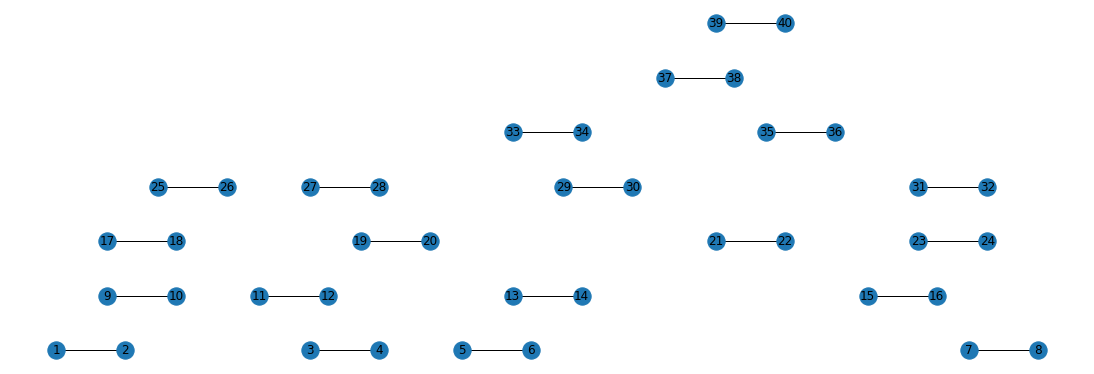

In [15]:
import random
from itertools import combinations

def trip_check(bus_1, bus_2, swap_time):
    trip_copy = create_trips(op_start, op_end, temp)
    
    trip_1 = None
    trip_2 = None
    temp_1 = None
    temp_2 = None
    
    for t in range(len(bus_1)):
        if bus_1[t][1] > swap_time:
            temp_1 =  bus_1[t]
            break

    for t in range(len(bus_2)):
        if bus_2[t][1] > swap_time:
            temp_2 = bus_2[t]
            break
    
    if temp_1 != None:
        for trip in trip_copy:
            if temp_1[0] == trip[0] and temp_1[1] == trip[1]:
#                 print(trip)
                trip_1 = trip
                break

    if temp_2 != None:
        for trip in trip_copy:
            if temp_2[0] == trip[0] and temp_2[1] == trip[1]:
#                 print(trip)
                trip_2 = trip
                break
    
#     print(bus_1)
#     print(bus_2)
#     print('%'*50)
    return (trip_1, trip_2)

def swap_check_all(bus_schedule, dh_trips):
    check = 0
    iterat = 0
    
    while check == 0:
        dh_trips_new = deepcopy(dh_trips)
        bus_sch = deepcopy(bus_schedule)
        bus_num = list(bus_sch.keys())
        random.shuffle(bus_num)
        t = random.uniform(op_start, op_end)
        bus_1 = bus_sch[bus_num[0]]
        bus_2 = bus_sch[bus_num[1]]
        old_bus_1 = deepcopy(bus_1)
        old_bus_2 = deepcopy(bus_2)
        
        trip_1, trip_2 = trip_check(bus_1, bus_2, t)
        
        if trip_1 != None and trip_2 != None:
            temp_1 = None
            temp_2 = None
            rem_trips = []
            rem_trips_bus_1 = []
            rem_trips_bus_2 = []

            for trip in bus_1:
                if trip[1] == trip_1[1] and trip[2] == trip_1[2]:
                    temp_1 = trip
                if trip[1] > trip_1[2]:
                    rem_trips.append(trip)
                    rem_trips_bus_1.append(trip)
            
            for trip in bus_2:
                if trip[1] == trip_2[1] and trip[2] == trip_2[2]:
                    temp_2 = trip
                if trip[1] > trip_2[2]:
                    rem_trips.append(trip)
                    rem_trips_bus_2.append(trip)
            
            bus_1.remove(temp_1)
            bus_2.remove(temp_2)
            for el in rem_trips:
                if el in bus_1:
                    bus_1.remove(el)
                if el in bus_2:
                    bus_2.remove(el)
            
            bus_1.append(trip_2)
            bus_2.append(trip_1)

            for dh in dh_trips:
                if dh[0] == bus_num[0]:
#                     print(dh, len(bus_1), 'a')
                    if len(bus_1) > 1:
                        if dh[-3] > bus_1[-2][1]:
                            dh_trips_new.remove(dh)
                    else:
                        dh_trips_new.remove(dh)
                elif dh[0] == bus_num[1]:
#                     print(dh, len(bus_2), 'b')
                    if len(bus_2) > 1:
                        if dh[-3] > bus_2[-2][1]:
                            dh_trips_new.remove(dh)
                    else:
                        dh_trips_new.remove(dh)
            
            # delete deadheads for buses 1,2 after swap
            # in particular, delete deadheads if their end time exceeds swapped trip's start time
            
            nsf1 = new_sch_feas_test(bus_1, bus_num[0])
            nsf2 = new_sch_feas_test(bus_2, bus_num[1])
            
            if nsf1[0] == 0 or nsf2[0] == 0:
                continue
            else:
                if bus_1 != old_bus_2 and bus_2 != old_bus_1:
                    bus_1_dh = nsf1[1]
                    bus_2_dh = nsf2[1]

                    if bus_1_dh is None and bus_2_dh is None:
                        
#                         print('c', len(dh_trips_new))
                        for trip in rem_trips:
                            for orig_trip in trip_copy:
                                if trip[0] == orig_trip[0] and trip[1] == orig_trip[1] and trip[2] == orig_trip[2]:
                                    trip[-1] = orig_trip[-1]
                        
                        return (bus_num[0], bus_num[1], bus_1, bus_2, bus_sch, rem_trips, old_bus_1, old_bus_2, dh_trips_new, rem_trips_bus_1, rem_trips_bus_2)
                    
                    else:
#                         print('a', len(dh_trips_new))
                        
                        dh_to_rem = []
                        
                        if bus_1_dh is not None:
                            
                            timer = bus_1_dh[0][-3]
                            
                            for old_dht in dh_trips_new:
                                if old_dht[0] == bus_num[0]:
                                    if old_dht[-3] >= timer:
                                        dh_to_rem.append(old_dht)
                            
                            for dh in dh_to_rem:
                                dh_trips_new.remove(dh)

                            dh_trips_new.extend(bus_1_dh)

                        
                        dh_to_rem = []
                        if bus_2_dh is not None:
                            
                            timer = bus_2_dh[0][-3]
                            
                            for old_dht in dh_trips_new:
                                if old_dht[0] == bus_num[1]:
                                    if old_dht[-3] >= timer:
                                        dh_to_rem.append(old_dht)
                            
                            for dh in dh_to_rem:
                                dh_trips_new.remove(dh)

                            dh_trips_new.extend(bus_2_dh)
                        
#                         print(len(dh_trips_new))
                        
                        for trip in rem_trips:
                            for orig_trip in trip_copy:
                                if trip[0] == orig_trip[0] and trip[1] == orig_trip[1] and trip[2] == orig_trip[2]:
                                    trip[-1] = orig_trip[-1]
                                    
                        return (bus_num[0], bus_num[1], bus_1, bus_2, bus_sch, rem_trips, old_bus_1, old_bus_2, dh_trips_new, rem_trips_bus_1, rem_trips_bus_2)

        else:
            t = random.uniform(op_start, op_end)
            iterat += 1

def new_sch_feas_test(bus, bus_id):  
    buffer = 0.03
    if len(bus) > 1:
        if bus[-1][0] == bus[-2][0]:
#             print('a')
            return [0, None]
            # CAN'T HAVE CONSECUTIVE TRIPS WITH THE SAME LABEL
        else:
            # FIGURE OUT LAST TRIP; DEADHEAD OR SERVICE
            start_stop = lines[bus[-1][0]][0]
            end_stop = lines[bus[-1][0]][1]
            
            prev_stop = lines[bus[-2][0]][1]
            prev_trip_end = bus[-2][2]
            prev_trip_start = bus[-2][1]
            rem_fuel = bus[-2][-1]

            prev_stop_dists = possible_swap(prev_stop, stop_dist)
            for d in prev_stop_dists:
                if d[0] == depot_node[0]:
                    charge_trip_next = d[1]
            
            curr_trip_start = bus[-1][1]

            for st in stop_dist[prev_stop]:

                if start_stop == st[0]:
                    
                    if prev_trip_end + buffer + st[1]/speed > curr_trip_start:
                        return [0, None]
                        # TIME REQUIRED FOR DEADHEAD IS MORE THAN THE TIME WINDOW B/W 2 TRIPS
                    else:
                        start_stop_dists = possible_swap(start_stop, stop_dist)
                        for d in start_stop_dists:
                            if d[0] == depot_node[0]:
                                charge_trip_to = d[1]
                        
                        end_stop_dists = possible_swap(end_stop, stop_dist)
                        for d in end_stop_dists:
                            if d[0] == depot_node[0]:
                                charge_trip_end = d[1]
                        
                        refuel_time = round((b_range - rem_fuel + charge_trip_next)/b_range , 2)
                        
                        if rem_fuel - st[1] - bus[-1][-1] - charge_trip_end <= 0:

                            if prev_trip_end + buffer + refuel_time + (charge_trip_next + charge_trip_to)/speed > curr_trip_start:
                                
                                return [0, None]
                                
                                # NOT ENOUGH FUEL FOR THE LAST TRIP AND NO TIME IN BETWEEN TO CHARGE
                            
                            else:
                                charging_start_time = round(prev_trip_end + charge_trip_next/speed, 2)
                                trip_to_depot = [bus_id, prev_stop, depot_node[0], prev_trip_end, charging_start_time, round(rem_fuel - charge_trip_next,2)]
                                trip_from_depot = [bus_id, depot_node[0], start_stop, round(charging_start_time + refuel_time, 2), round(charging_start_time + refuel_time + (charge_trip_to/speed),2), round(b_range - charge_trip_to, 2)]
                                new_dh = [trip_to_depot, trip_from_depot]
                                bus[-1][-1] = round(b_range - bus[-1][-1] - charge_trip_to, 2)
                                return [1, new_dh]
                            
                                # CHARGING POSSIBLE IN BETWEEN

                        else: 
                            if prev_stop != start_stop:
#                                 print(bus_id, charge_trip_end)
                                new_dh = [[bus_id, prev_stop, start_stop, prev_trip_end, round(prev_trip_end + (st[1]/speed),2), round(rem_fuel - st[1],2)]]
                                bus[-1][-1] = round(rem_fuel - st[1] - bus[-1][-1], 2)
                                return [1, new_dh]
                            else:
#                                 print(bus_id, charge_trip_end)
                                bus[-1][-1] = round(rem_fuel - bus[-1][-1], 2)
                                return [1, None]
                            
    else:
        bus_st = lcon[bus[-1][0]][0]
        for d in stop_dist[bus_st]:
            if d[0] == depot_node[0]:
                depot_dist = d[1]
#         print(depot_dist)
        bus[-1][-1] = round(b_range - depot_dist - bus[-1][-1], 2)
        return [1, None]
        # SWAPPED TRIP IS THE FIRST POSSIBLE

bus_sch = deepcopy(bus_schedule)

dht = deepcopy(deadhead_trips)
# for dh in dht:
#     print(dh)
# print('-'*50)

check_bus_1 = 1
check_bus_2 = 1
while check_bus_1 == 1 and check_bus_2 == 1:
    bus_1_id, bus_2_id, new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, dht_new, rem_trips_bus_1, rem_trips_bus_2 = swap_check_all(bus_sch, dht)
#     new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, dht_new = swap_check(new_new_s, new_new_dht)
    check_bus_1 = len(new_bus_1)
    check_bus_2 = len(new_bus_2)


temp_sch = {}
trip_ct = 0

for bus in new_schd.values():
    trip_ct += len(bus)

print('Trip count ', trip_ct)

for bus in bus_sch.items():
    if old_bus_1 == bus[1]:
        temp_sch[bus[0]] = new_schd[bus[0]]
    elif old_bus_2 == bus[1]:
        temp_sch[bus[0]] = new_schd[bus[0]]

# for bus in new_new_s.items():
#     if old_bus_1 == bus[1]:
#         temp_sch[bus[0]] = new_schd[bus[0]]
#     elif old_bus_2 == bus[1]:
#         temp_sch[bus[0]] = new_schd[bus[0]]

# print(old_bus_1)
# print('-'*50)
        
for bus in temp_sch.items():
    print(bus[0])
    print('^'*5)
    for t in bus[1]:
        print(t)
    print('-'*50)

print('Rem trips ', len(rem_trips))
for t in rem_trips:
    print(t)
print('-'*50)

print('Rem trips bus 1 ', len(rem_trips_bus_1))
for t in rem_trips_bus_1:
    print(t)
print('-'*50)

print('Rem trips bus 2 ', len(rem_trips_bus_2))
for t in rem_trips_bus_2:
    print(t)
print('-'*50)

print('Dh_trips ', len(dht_new))
for dh in dht_new:
#     if dh is not None:
#         if dh[0] in temp_sch.keys():
    print(dh)

ctr = 1
pos = {}
edges = []
edge_color = []
Trip_graph = nx.Graph()
for bus in new_schd.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))      
        
fig = plt.figure(figsize=(15,5))
Trip_graph.add_nodes_from(pos)
Trip_graph.add_edges_from(edges)
nx.draw(Trip_graph, pos, with_labels = True)
plt.savefig('new_schedule_basic.png')

In [331]:
# print(rem_trips)
'''
[4, 2, 0, 10.0, 10.12, 2.24]
[4, 0, 2, 10.3, 10.43, 3.65]
[4, 2, 0, 12.0, 12.12, 0.48]
[4, 0, 2, 12.47, 12.6, 3.65]

Bus 6 : 
['l2', 9.75, 10.25, 2.59]
['l1', 10.5, 11.0, 1.18]
['l2', 11.75, 12.25, 2.24]
['l1', 12.5, 13.0, 0.83]
['l2', 13.75, 14.25, 2.24]
['l1', 14.5, 15.0, 0.83]
**************************************************
Bus 8 : 
['l3', 11.4, 11.9, 3.0]
['l4', 12.15, 12.65, 2.0]
['l3', 13.4, 13.9, 2.75]
['l4', 14.15, 14.65, 1.75]
'''

# def new_sch_feas_test(bus, bus_id):  
#     buffer = 0.03
#     if len(bus) > 1:
#         if bus[-1][0] == bus[-2][0]:
# #             print('a')
#             return [0, None]
#             # CAN'T HAVE CONSECUTIVE TRIPS WITH THE SAME LABEL
#         else:
#             # FIGURE OUT LAST TRIP; DEADHEAD OR SERVICE
#             start_stop = lines[bus[-1][0]][0]
#             end_stop = lines[bus[-1][0]][1]
            
#             prev_stop = lines[bus[-2][0]][1]
#             prev_trip_end = bus[-2][2]
#             prev_trip_start = bus[-2][1]
#             rem_fuel = bus[-2][-1]
# #                 print('HAHAHAHA')
#             prev_stop_dists = possible_swap(prev_stop, stop_dist)
#             for d in prev_stop_dists:
#                 if d[0] == depot_node[0]:
#                     charge_trip_next = d[1]
                        
# #                 print(bus_id, bus)
# #             else:
# # #                 print('b', last)

# #                 prev_stop = last[2]
# #                 prev_trip_end = last[-2]
# #                 prev_trip_start = last[-3]
# #                 rem_fuel = last[-1]
# #                 charge_trip_next = 0
            
#             curr_trip_start = bus[-1][1]

#             for st in stop_dist[prev_stop]:

#                 if start_stop == st[0]:
                    
#                     if round(curr_trip_start - prev_trip_end - buffer, 2) < round(st[1]/speed, 2):
#                         return [0, None]
#                         # TIME REQUIRED FOR DEADHEAD IS MORE THAN THE TIME WINDOW B/W 2 TRIPS
#                     else:
#                         start_stop_dists = possible_swap(start_stop, stop_dist)
#                         for d in start_stop_dists:
#                             if d[0] == depot_node[0]:
#                                 charge_trip_to = d[1]
                        
#                         # CHECKING IF BUS CAN MAKE THE NEWLY ADDED TRIP
                        
                        
#                         # NEXT CONDITION CHECKS FOR FUEL; SECOND LAST + DEADHEAD TO LAST + LAST
                        
#                         refuel_time = round((b_range - rem_fuel + charge_trip_next)/b_range , 2)
                        
#                         if rem_fuel - st[1] - bus[-1][-1] <= 0:

#                             if prev_trip_end + buffer + refuel_time + (charge_trip_next + charge_trip_to)/speed > curr_trip_start:
#                                 return [0, None]
                                
#                                 # NOT ENOUGH FUEL FOR THE LAST TRIP AND NO TIME IN BETWEEN TO CHARGE
                            
#                             else:
                                
#                                 new_dh = insert_charging_trip(bus, bus_id, bus[-2], bus[-1])

#                                 bus[-1][-1] = round(b_range - bus[-1][-1] - charge_trip_to, 2)

#                                 return [1, new_dh]
                            
#                                 # CHARGING POSSIBLE IN BETWEEN

#                         else: #POSSIBLE TO DEADHEAD TO NEXT TRIP AND MAKE TRIP
                            
#                             end_stop_dists = possible_swap(end_stop, stop_dist)
#                             for d in end_stop_dists:
#                                 if d[0] == depot_node[0]:
#                                     charge_trip_end = d[1]

#                             if rem_fuel - st[1] - bus[-1][-1] - charge_trip_end <= 0:
#                                 return [0, None]
                                
#                                 # NOT ENOUGH FUEL TO REACH DEPOT AFTER NEW TRIP

#                             else:

#                                 if prev_trip_end + buffer + refuel_time + (charge_trip_next + charge_trip_to)/speed < curr_trip_start:
                                    
#                                     new_dh = insert_charging_trip(bus, bus_id, bus[-2], bus[-1])
#                                     bus[-1][-1] = round(b_range - bus[-1][-1] - charge_trip_to, 2)
#                                     return [1, new_dh]
                                    
#                                     # ENOUGH TIME TO CHARGE BETWEEN LAST AND NEWLY ADDED TRIP
                
#                                 else:

#                                     if prev_stop != start_stop:
#                                         new_dh = [[bus_id, prev_stop, start_stop, prev_trip_end, round(prev_trip_end + (st[1]/speed),2), round(rem_fuel - st[1],2)]]
#                                         bus[-1][-1] = round(rem_fuel - st[1] - bus[-1][-1], 2)
#                                         return [1, new_dh]
#                                     else:
#                                         print('BAAAAAAJAJASJ')
#                                         bus[-1][-1] = round(rem_fuel - st[1] - bus[-1][-1], 2)
#                                         print(bus_id, bus)
#                                         return [1, None]
                            
#                             # LAST TRIP POSSIBLE
#     else:
# #         print(last, bus[-1][-1])
#         bus[-1][-1] = round(b_range - bus[-1][-1], 2)
# #         print(bus[-1][-1])
#         return [1, None]
#         # SWAPPED TRIP IS THE FIRST POSSIBLE

[1, 922, 1260, 13.9, 14.11, 15.13]
[1, 1260, 922, 14.98, 15.19, 112.71]
[2, 1146, 1260, 12.44, 12.9, 41.34]
[2, 1260, 922, 13.56, 13.77, 112.71]


In [117]:
# dummy_sch = {}
# dummy_sch[1] = new_schd[7]

# dummy_dh = []
# for dh in dht_new:
#     if dh[0] == 7:
#         dummy_dh.append(dh)
        
# dummy_2 = deepcopy(new_schd)

# for bus in dummy_sch.items():
#     print(bus)

# for bus in dummy_2.items():
#     print(bus)
    
# ctr = 1
# pos = {}
# edges = []
# edge_color = []
# Trip_graph = nx.Graph()
# for bus in dummy_2.items():
#     for seq in bus[1]:
#         pos[ctr] = (seq[1], bus[0])
#         ctr += 1
#         pos[ctr] = (seq[2], bus[0])
#         ctr += 1
#         edges.append((ctr-2,ctr-1))      
        
# fig = plt.figure(figsize=(15,5))
# Trip_graph.add_nodes_from(pos)
# Trip_graph.add_edges_from(edges)
# nx.draw(Trip_graph, pos, with_labels = True)
# plt.savefig('dummy.png')

In [16]:
def check_added(dummy_sch, ndh_t, rem_trips, lines):
    ctr = 0
    nschd = deepcopy(dummy_sch)
    rem_tripzz = deepcopy(rem_trips)
    
#     print(dummy_sch.items())
#     print(rem_tripzz)
    
#     for bus in nschd.items():
#         print(bus)
#     print('-'*100)
    new_bus_dh = []
    if rem_tripzz != []:
        while ctr < len(rem_tripzz):
#             print(ctr)
            new_s, new_ctr, dh_t = new_stops(lines, rem_tripzz, nschd, ndh_t, ctr)
            for dh in dh_t:
                if dh not in ndh_t:
                    new_bus_dh.append(dh)
            if new_ctr == ctr:
                new_s[len(new_s.keys())+1] = []
#                 print(len(new_s.keys()))
#                 print(new_ctr)
                ctr = new_ctr
    else:
        new_s = nschd
    
    if len(new_s.keys()) == 1:
#         ctr = 1
#         pos = {}
#         edges = []
#         edge_color = []
#         Trip_graph = nx.Graph()
#         for bus in new_s.items():
#             for seq in bus[1]:
#                 pos[ctr] = (seq[1], bus[0])
#                 ctr += 1
#                 pos[ctr] = (seq[2], bus[0])
#                 ctr += 1
#                 edges.append((ctr-2,ctr-1))

#         fig = plt.figure(figsize=(15,5))
#         Trip_graph.add_nodes_from(pos)
#         Trip_graph.add_edges_from(edges)
#         nx.draw(Trip_graph, pos, with_labels = True)
#         plt.savefig('new_schedule_basic_rem_bus.png')
        
#         print(new_s.items())
#         print('-'*100)
#         print(rem_tripzz)
        return (1, new_s, new_bus_dh)
    
    else:
#         print(new_s)
        return (0, None)


# print(list(dummy_sch.values()))
# print(rem_trips_bus_1)
# print(dummy_dh)
# check_added(dummy_sch, dummy_dh, rem_trips_bus_1)

In [17]:
def swap_all(init_sch, dh_trips, lines, trip_copy):
    
    sch_check = 1
    
    while sch_check == 1:
        bus_sch = deepcopy(init_sch)
        dht = deepcopy(dh_trips)

        check_bus_1 = 1
        check_bus_2 = 1

        while check_bus_1 == 1 and check_bus_2 == 1:
            bus_1_id, bus_2_id, new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, temp_dht_new, rem_trips_bus_1, rem_trips_bus_2 = swap_check_all(bus_sch, dht)
            check_bus_1 = len(new_bus_1)
            check_bus_2 = len(new_bus_2)

        temp_dht = []
        for dh in temp_dht_new:
            if dh is not None:
                temp_dht.append(dh)
        
#         print('rem_trips', rem_trips)
#         print(rem_trips_bus_1)
#         print(rem_trips_bus_2)
#         print('-'*100)
        
        upd_sch = deepcopy(new_schd)
                
        dummy_sch_1 = {}
        dummy_sch_2 = {}
        dummy_sch_1[1] = new_bus_1
        dummy_sch_2[1] = new_bus_2

        dummy_dh_1 = []
        dummy_dh_2 = []

        for dh in temp_dht:
            if dh[0] == bus_1_id:
                dummy_dh_1.append(dh)
            elif dh[0] == bus_2_id:
                dummy_dh_2.append(dh)

        add_check_sch_1 = check_added(dummy_sch_1, dummy_dh_1, rem_trips_bus_2, lines)
        add_check_sch_2 = check_added(dummy_sch_2, dummy_dh_2, rem_trips_bus_1, lines)
        
        if add_check_sch_1[0] == 1 and add_check_sch_2[0] == 1:
#             print(bus_1_id, bus_2_id)
            
#             print(add_check_sch_1[1])
#             print(add_check_sch_2[1])

            upd_sch[bus_1_id] = list(add_check_sch_1[1][1])
            upd_sch[bus_2_id] = list(add_check_sch_2[1][1])
            
            temp_dht.extend(add_check_sch_1[2])
            temp_dht.extend(add_check_sch_2[2])
            
#             print('-'*100)
#             trip_ct = 0
#             for bus in upd_sch.values():
#                 trip_ct += len(bus)
#             print(trip_ct)
#             print('-'*100)
            
#             for bus in upd_sch.items():
#                 print(bus)
#             print('$'*100)
            
            return (new_bus_1, new_bus_2, upd_sch, rem_trips, old_bus_1, old_bus_2, temp_dht_new)
        else:
#             print('a')
            sch_check = 1

    
#     return (bus_1, bus_2, bus_sch, rem_trips, old_bus_1, old_bus_2, dh_trips_new)
# print(temp)
trip_ct_org = 0
# for bus in bus_sch.values():
#     trip_ct_org += len(bus)
# print(trip_ct_org)
# print('-'*100)

# for el in bus_sch.items():
#     print(el)

test_swap = swap_all(bus_sch, dht, temp, trip_copy)

# for el in test_swap[2].items():
#     print(el)

NameError: name 'new_stops' is not defined

4075.0
3824.0


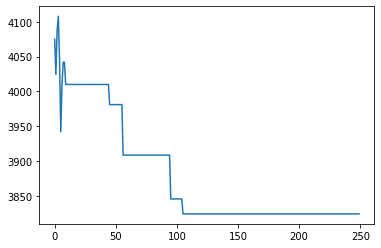

In [70]:
def best_sol_SA_all(init_sch, scored_sch, dh_trips, iters, T, lines, trip_copy):
    best_sch = deepcopy(init_sch)
    dht = deepcopy(dh_trips)
    scores = []

    T_old = 1
    
    for i in range(iters):
        if T/T_old < 0.000000001:
            print(i, T/T_old)
            break

        check_bus_1 = 1
        check_bus_2 = 1
        while check_bus_1 == 1 and check_bus_2 == 1:
#             new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, temp_dht_new = swap_check(best_sch, dht, lines, trip_copy)
            new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, temp_dht_new = swap_all(best_sch, dht, lines, trip_copy)
            check_bus_1 = len(new_bus_1)
            check_bus_2 = len(new_bus_2)
        
#         ctr = 0

        ndh_t = deepcopy(temp_dht_new)
        new_s = deepcopy(new_schd)
        
#         for dh in ndh_t:
#             print(dh)
#         print('-'*100)
        
#         rem_tripzz = deepcopy(rem_trips)
#         rem_tripzz.sort(key=lambda y: y[1])

#         if rem_tripzz != []:
#             while ctr < len(rem_tripzz):
#                 new_s, new_ctr, dh_t = new_stops(lines, rem_tripzz, nschd, ndh_t, ctr)
#                 if new_ctr == ctr:
#                     new_s[len(new_s.keys())+1] = []
#                     ctr = new_ctr
#                 for dh in dh_t:
#                     if dh not in ndh_t:
#                         ndh_t.append(dh_t)
#         else:
#             new_s = deepcopy(nschd)
        
        ndh_t_adj = adjusted_dh(new_s, ndh_t)
        
        new_schedule = full_sch_scoring(new_s, ndh_t_adj)

        score_new = stats(new_schedule)

        score_old = stats(scored_sch)
        
        if score_new < score_old:
            best_sch = new_s
            scored_sch = new_schedule
            dht = deepcopy(ndh_t)
        else:
            prob = random.uniform(0,1)
            if prob < math.exp((score_old - score_new)/T):
                best_sch = new_s
                scored_sch = new_schedule
                dht = deepcopy(ndh_t)
        
        T_old = T
        T = T/math.log(2+i)
        scores.append([i, score_old])
    
    return (best_sch, scored_sch, dht, scores)


dht = deepcopy(deadhead_trips)
bus_sch = deepcopy(bus_schedule)

dht_adj = adjusted_dh(bus_sch, dht)

scored_sch = full_sch_scoring(bus_sch, dht_adj)
print(stats(scored_sch))

# print(temp)

best, best_score_sch, ndh, score_plot = best_sol_SA_all(bus_sch, scored_sch, dht, 250, 10000, temp, trip_copy)

print(stats(best_score_sch))

sc = []
it = list(range(len(score_plot)))

for score in score_plot:
    sc.append(score[1])

plt.plot(it, sc)

In [19]:
def full_sch_scoring(new_s, ndh_t):
    swapped_schedule = {}
    # print(deadhead_trips)
    dh_tripz = deepcopy(ndh_t)
    
    trip_num = 0
    for bus in new_s.keys():
        new_sch = []
        for trip in new_s[bus]:
            new_sch.append(['t', trip[1], trip[2]])
            trip_num += 1

        for dh in dh_tripz:
                if dh[0] == bus:
                    new_sch.append(['d', dh[3], dh[4]])

        swapped_schedule[bus] = sorted(new_sch, key=lambda y: y[1])   

    for bus in swapped_schedule.keys():
        charging_trips = []
        for t in range(1,len(swapped_schedule[bus])):
            if swapped_schedule[bus][t][1] != swapped_schedule[bus][t-1][2]:
                if swapped_schedule[bus][t-1][0] == 'd' and swapped_schedule[bus][t-1][0] == swapped_schedule[bus][t][0]:
                    label = 'c'
                else:
                    label = 's'
                charging_trips.append([label, swapped_schedule[bus][t-1][2], swapped_schedule[bus][t][1]])

        swapped_schedule[bus].extend(charging_trips)
        swapped_schedule[bus].sort(key=lambda y: y[1])

    for bus in swapped_schedule.keys():
        for t in range(2,len(swapped_schedule[bus])):
            if swapped_schedule[bus][t][0] == 'c' and swapped_schedule[bus][t-2][0] == swapped_schedule[bus][t][0]:
#                 print(swapped_schedule[bus][t])
                swapped_schedule[bus][t][0] = 's'
    #     break
    
    swapped_schedule_copy = deepcopy(swapped_schedule)

#     ctr = 1
#     pos = {}
#     edges = []
#     edge_color = []

#     new_trip_graph = nx.Graph()
#     for bus in swapped_schedule.items():
#         for seq in bus[1]:
#             pos[ctr] = (seq[1], bus[0])
#             ctr += 1
#             pos[ctr] = (seq[2], bus[0])
#             ctr += 1
#             edges.append((ctr-2,ctr-1))
#             if seq[0] == 't':
#                 edge_color.append('red')
#             elif seq[0] == 'd':
#                 edge_color.append('blue')
#             elif seq[0] == 'c':
#                 edge_color.append('green')
#             else:
#                 edge_color.append('yellow')
    
#     fig = plt.figure(figsize=(15,5))
#     new_trip_graph.add_nodes_from(pos)
#     new_trip_graph.add_edges_from(edges)
#     nx.draw(new_trip_graph, pos, with_labels = True, edge_color = edge_color, width = 10.0)
#     plt.plot()
# #     plt.savefig(str(iter) + '_swapped_schedule.png')
    
    return swapped_schedule_copy

['l1', 14.0, 14.34, 12.02]
--------------------------------------------------
[]
**************************************************


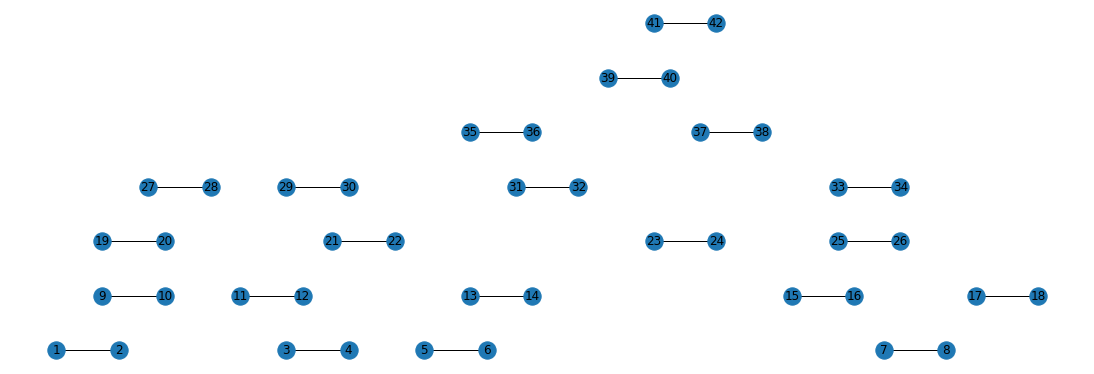

In [18]:
# def greedy_insert(schd, rem_tripz, dhT):

def new_stops(line_pool, trips, buses, deadhead, cov):
    lines = deepcopy(line_pool)
    rem_trips = []
    for bus in buses.keys():
        if trips == []:
            for i in range(len(buses)):
                if buses[i+1] == []:
                    del buses[i+1]
            return (buses, cov, deadhead)
            break
        
        if buses[bus] == []:
            buses[bus] = [trips[0]]
            buses[bus][-1][-1] = b_range - trips[0][-1]
            curr_stop = lines[trips[0][0]][1]
            trips.pop(0)
            cov += 1
            
        curr_time_new = 0
        
        charge_check = 0
        
        new_trav = 0
        
        t = 0
        trip_num = len(trips)
        
        while t < trip_num:
            
            curr_stop = lines[buses[bus][-1][0]][1]
            
            if charge_check == 0:
                trav = buses[bus][-1][-1]
                curr_time = buses[bus][-1][2]
            else:
                curr_time = round(curr_time_new, 2)
#                 trav = new_trav
#                 print('hello')
                charge_check = 0
       
            
#             nxt_stop = lines[buses[bus][-1][0]][0]
            nxt_start_stop = lines[trips[t][0]][0]
            nxt_end_stop = lines[trips[t][0]][1]
    
            dists = possible_swap(curr_stop, stop_dist)
            
            next_dists = possible_swap(nxt_end_stop, stop_dist)
            
            for d in dists:
                if d[0] == depot_node[0]:
                    charge_trip_curr = d[1]
            
            for d in next_dists:
                if d[0] == depot_node[0]:
                    charge_trip_next = d[1]


            for st in dists:
                if nxt_start_stop == st[0]:
                    if curr_time + st[1]/speed <= trips[t][1]:
                        
#                         nxt_stop_dist = trips[t][-1]
                        
#                         if bus == 11:
#                             print(curr_time, curr_stop, nxt_stop_dist, trips[t])
                            
                        proj_trip = st[1] + trips[t][-1] + charge_trip_next
#                         print(trav, trips[t][-1], nxt_start_stop, curr_stop, st[1], charge_trip_next)
                        if trav - proj_trip > 0:
                            rem_trips.append(trips[t])
                            trips[t][-1] = round(trav - trips[t][-1] - st[1],2)
                            buses[bus].append(trips[t])
                            if curr_stop != nxt_start_stop:
                                dh_tr = [bus, curr_stop, nxt_start_stop, curr_time, round(curr_time + (st[1]/speed),2), round(trav - st[1], 2)]
                                deadhead.append(dh_tr)
                            cov += 1
                            curr_time_new = trips[t][-2]
                            break
                        else:
#                             print(nxt_start_stop, curr_stop, st[1], charge_trip_next)
#                             print('ddd', bus, trips[t], proj_trip)
                            charge_check = 1
                            trip_to_depot = [bus, curr_stop, depot_node[0], curr_time, round(curr_time + (charge_trip_curr/speed),2), round(trav - charge_trip_curr,2)]
                            if trip_to_depot not in deadhead:
                                deadhead.append(trip_to_depot)
#                                 refuel_time = round((b_range - trav + charge_trip_curr) * 0.1, 2)
                            refuel_time = round((b_range - trav + charge_trip_curr)/b_range, 2)
                            curr_time_new = round(curr_time + (charge_trip_curr/speed) + refuel_time, 2)
                            new_trav = round(b_range - charge_trip_curr,2)
                            trip_from_depot = [bus, depot_node[0], curr_stop, curr_time_new, round(curr_time_new + (charge_trip_curr/speed),2), new_trav]
                            if trip_from_depot not in deadhead:
                                deadhead.append(trip_from_depot)
                            curr_time_new += charge_trip_curr/speed
                            t -= 1
                            break
#                         else:
#                             print('bbb')
            t += 1

        for trip in rem_trips:
            if trip in trips:
                trips.remove(trip)
    
    return (buses, cov, deadhead)    

ctr = 0

nschd = deepcopy(new_schd)
ndh_t = deepcopy(dht_new)

# for dh in ndh_t:
#     print(dh)
# print('*'*50)

rem_tripzz = deepcopy(rem_trips)
for trip in rem_tripzz:
    print(trip)#rem_tripzz)
print('-'*50)

if rem_tripzz != []:
    while ctr < len(rem_tripzz):
        new_s, new_ctr, dh_t = new_stops(lines, rem_tripzz, nschd, ndh_t, ctr)
        for dh in dh_t:
            if dh not in ndh_t:
                ndh_t.append(dh)
        if new_ctr == ctr:
            new_s[len(new_s.keys())+1] = []
            ctr = new_ctr
#         if new_s == nschd:
#             print(ctr)
#         for dh in dh_t:
#             if dh not in ndh_t:
#                 ndh_t.append(dh_t)

print(rem_tripzz)
print('*'*50)

# for bus in temp_sch.items():
#     print(bus[0])
#     print('^'*5)
#     for t in bus[1]:
#         print(t)
#     print('-'*50)

# print(new_s[3])
# print(new_s[9])
# print(new_s[10])

# for dh in ndh_t:
#     if dh[0] == 10:
#         print(dh)


ctr = 1
pos = {}
edges = []
edge_color = []
Trip_graph = nx.Graph()
for bus in new_s.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        
fig = plt.figure(figsize=(15,5))
Trip_graph.add_nodes_from(pos)
Trip_graph.add_edges_from(edges)
nx.draw(Trip_graph, pos, with_labels = True)
plt.savefig('new_schedule_basiczz.png')

['l1', 14.0, 14.34, 12.02]
--------------------------------------------------
[]
**************************************************
(1, [['l3', 10.25, 10.59, 43.45], ['l1', 14.0, 14.34, 19.59]])


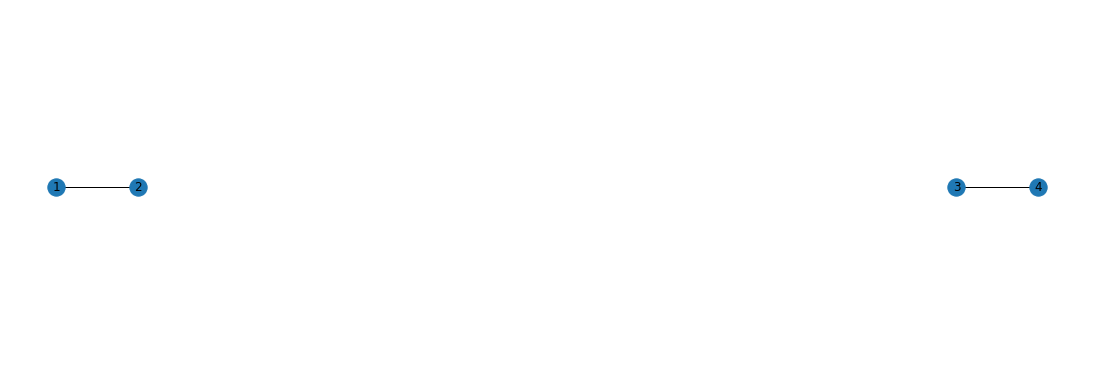

In [628]:
ctr = 0

nschd = deepcopy(dummy_sch)
ndh_t = deepcopy(dht_new)

rem_tripzz = deepcopy(rem_trips_bus_2)
for trip in rem_tripzz:
    print(trip)
print('-'*50)

if rem_tripzz != []:
    while ctr < len(rem_tripzz):
        new_s, new_ctr, dh_t = new_stops(lines, rem_tripzz, nschd, ndh_t, ctr)
        for dh in dh_t:
            if dh not in ndh_t:
                ndh_t.append(dh)
        if new_ctr == ctr:
            new_s[len(new_s.keys())+1] = []
            ctr = new_ctr

print(rem_tripzz)
print('*'*50)

for bus in new_s.items():
    print(bus)

# dummy_2[1] = new_s[1]
# dummy_2[4] = new_s[2]


ctr = 1
pos = {}
edges = []
edge_color = []
Trip_graph = nx.Graph()
for bus in new_s.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        
fig = plt.figure(figsize=(15,5))
Trip_graph.add_nodes_from(pos)
Trip_graph.add_edges_from(edges)
nx.draw(Trip_graph, pos, with_labels = True)
plt.savefig('new_schedule_basic_rem_bus_1.png')

In [21]:
def adjusted_dh(new_s, ndh_t):

    ndh_t_copy = deepcopy(ndh_t)
    for bus in new_s.items():
        first_bus_trip = bus[1][0]
        start_st = lcon[first_bus_trip[0]][0]
        for d in stop_dist[start_st]:
            if d[0] == depot_node[0]:
                first_dh = d[1]
        
        last_bus_trip = bus[1][-1]
        end_st = lcon[last_bus_trip[0]][1]
        for d in stop_dist[end_st]:
            if d[0] == depot_node[0]:
                last_dh = d[1]
        
        max_dh = None
        max_dh_time = 0
        for dh in ndh_t_copy:
            if dh[0] == bus[0]:
                if max_dh_time < dh[-2]:
                    max_dh = dh
                    max_dh_time = dh[-2]
        if max_dh is not None:
            if last_bus_trip[-2] < max_dh_time:
                ndh_t_copy.remove(max_dh)
            else:
                ndh_t_copy.append([bus[0], end_st, depot_node[0], last_bus_trip[2], round(last_bus_trip[2] + last_dh/speed, 2), round(last_bus_trip[-1] - last_dh, 2)])
        else:
            ndh_t_copy.append([bus[0], end_st, depot_node[0], last_bus_trip[2], round(last_bus_trip[2] + last_dh/speed, 2), round(last_bus_trip[-1] - last_dh, 2)])

        ndh_t_copy.append([bus[0], depot_node[0], start_st, round(first_bus_trip[1] - first_dh/speed, 2), first_bus_trip[1], round(b_range - first_dh, 2)])
    
    return ndh_t_copy

# ndh_t_copy = adjusted_dh(new_s, ndh_t)

In [249]:
new_new_s = deepcopy(new_s)
new_new_dht = deepcopy(ndh_t)

# a = [2]

# print(a == [2])

'''
            if deadhead != []:
                max_dh = 0
                temp_dh = None
                for dh in deadhead:
                    if dh[0] == bus:
                        if dh[-2] > max_dh:
                            max_dh = dh[-2]
                            temp_dh = dh
                if max_dh > buses[bus][-1][-2]:
                    curr_stop = temp_dh[2]
                    if curr_stop == depot_node[0]:
                        refuel_time = round((b_range - temp_dh[-1])/b_range, 2)
                        curr_stop = depot_node[0]
                        curr_time = curr_time + refuel_time
#                         print(curr_time)
                    else:
                        trav = temp_dh[-1]
#                     trav = temp_dh[-1]
                else:
                    curr_stop = lines[buses[bus][-1][0]][1]
            else:
                curr_stop = lines[buses[bus][-1][0]][1]
            
            # NEED TO CHANGE nxt_stop

            nxt_start_stop = lines[trips[t][0]][0]
            nxt_end_stop = lines[trips[t][0]][1]
            next_stop_dist = lines[buses[bus][-1][0]][-1]
#             if curr_stop 
            dists = possible_swap(curr_stop, stop_dist)
            
#             if bus == 1:
#             print(bus, curr_stop, curr_time, trav, nxt_stop, trips[t])
            
            for line in lines.values():
                if line[0] == curr_stop:
                    next_dists = possible_swap(nxt_end_stop, stop_dist)

            for d in dists:
#                 if d[0] == depot_node[0]:
#                     charge_trip_curr = d[1]                
                if curr_stop != depot_node[0]:
                    if d[0] == depot_node[0]:
                        charge_trip_curr = d[1]
                else:
                    if d[0] == nxt_start_stop:
                        curr_stop = nxt_start_stop
                        charge_trip_curr = 0
                        curr_time += d[1]/speed
            
            for d in next_dists:
                if d[0] == depot_node[0]:
                    charge_trip_next = d[1]
'''

'\n            if deadhead != []:\n                max_dh = 0\n                temp_dh = None\n                for dh in deadhead:\n                    if dh[0] == bus:\n                        if dh[-2] > max_dh:\n                            max_dh = dh[-2]\n                            temp_dh = dh\n                if max_dh > buses[bus][-1][-2]:\n                    curr_stop = temp_dh[2]\n                    if curr_stop == depot_node[0]:\n                        refuel_time = round((b_range - temp_dh[-1])/b_range, 2)\n                        curr_stop = depot_node[0]\n                        curr_time = curr_time + refuel_time\n#                         print(curr_time)\n                    else:\n                        trav = temp_dh[-1]\n#                     trav = temp_dh[-1]\n                else:\n                    curr_stop = lines[buses[bus][-1][0]][1]\n            else:\n                curr_stop = lines[buses[bus][-1][0]][1]\n            \n            # NEED TO CHANGE 

20


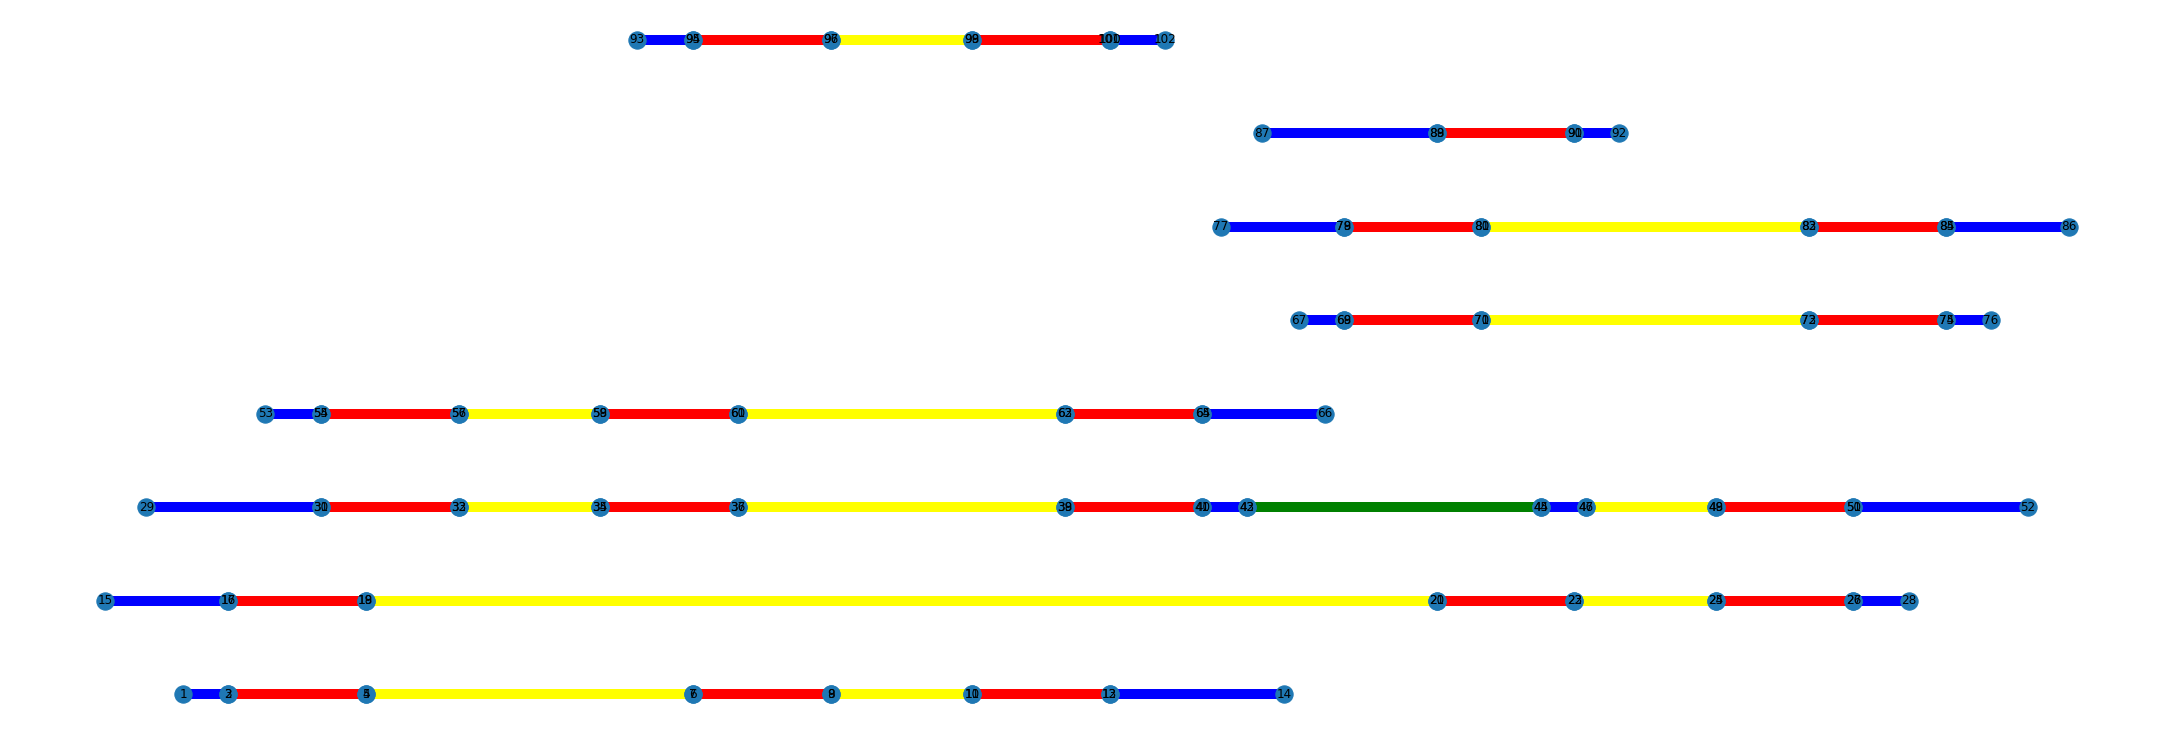

In [195]:
swapped_schedule = {}
# print(deadhead_trips)
dh_tripz = deepcopy(ndh_t_copy)

trip_ct = 0
for bus in new_s.values():
    trip_ct += len(bus)

print(trip_ct)

for bus in new_s.keys():
    new_sch = []
    for trip in new_s[bus]:
        new_sch.append(['t', trip[1], trip[2]])
    
    for dh in dh_tripz:
            if dh[0] == bus:
                new_sch.append(['d', dh[3], dh[4]])
    
    swapped_schedule[bus] = sorted(new_sch, key=lambda y: y[1])   

swapped_schedule_copy = deepcopy(swapped_schedule)

for bus in swapped_schedule.keys():
    charging_trips = []
    for t in range(1,len(swapped_schedule[bus])):
        if swapped_schedule[bus][t][1] != swapped_schedule[bus][t-1][2]:
            if swapped_schedule[bus][t-1][0] == 'd' and swapped_schedule[bus][t-1][0] == swapped_schedule[bus][t][0]:
                label = 'c'
            else:
                label = 's'
            charging_trips.append([label, swapped_schedule[bus][t-1][2], swapped_schedule[bus][t][1]])
        
    swapped_schedule[bus].extend(charging_trips)
    swapped_schedule[bus].sort(key=lambda y: y[1])
    
for bus in swapped_schedule.keys():
    for t in range(2,len(swapped_schedule[bus])):
        if swapped_schedule[bus][t][0] == 'c' and swapped_schedule[bus][t-2][0] == swapped_schedule[bus][t][0]:
            print(swapped_schedule[bus][t])
            swapped_schedule[bus][t][0] = 's'
#     break
    

ctr = 1
pos = {}
edges = []
edge_color = []

new_trip_graph = nx.Graph()
for bus in swapped_schedule.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        if seq[0] == 't':
            edge_color.append('red')
        elif seq[0] == 'd':
            edge_color.append('blue')
        elif seq[0] == 'c':
            edge_color.append('green')
        else:
            edge_color.append('yellow')

fig = plt.figure(figsize=(30,10))
new_trip_graph.add_nodes_from(pos)
new_trip_graph.add_edges_from(edges)
nx.draw(new_trip_graph, pos, with_labels = True, edge_color = edge_color, width = 10.0)
plt.savefig('swapped_schedule.png')

In [171]:
dummy_bus = deepcopy(new_s[5])
dummy_bus.pop(2)
print(dummy_bus)


[['l2', 9.5, 9.87, 41], ['l1', 10.25, 10.62, 28.03], ['l1', 12.75, 13.12, 27.76], ['l2', 14.5, 14.87, 40.73]]


In [23]:
def full_sch_vis(new_s, ndh_t, iter):
    swapped_schedule = {}
    # print(deadhead_trips)
    dh_tripz = deepcopy(ndh_t)
    
    trip_num = 0
    for bus in new_s.keys():
        new_sch = []
        for trip in new_s[bus]:
            new_sch.append(['t', trip[1], trip[2]])
            trip_num += 1

        for dh in dh_tripz:
                if dh[0] == bus:
                    new_sch.append(['d', dh[3], dh[4]])

        swapped_schedule[bus] = sorted(new_sch, key=lambda y: y[1])   

#     print(trip_num, len(dh_tripz))
    swapped_schedule_copy = deepcopy(swapped_schedule)

    for bus in swapped_schedule.keys():
        charging_trips = []
        for t in range(1,len(swapped_schedule[bus])):
            if swapped_schedule[bus][t][1] != swapped_schedule[bus][t-1][2]:
                if swapped_schedule[bus][t-1][0] == 'd' and swapped_schedule[bus][t-1][0] == swapped_schedule[bus][t][0]:
                    label = 'c'
                else:
                    label = 's'
                charging_trips.append([label, swapped_schedule[bus][t-1][2], swapped_schedule[bus][t][1]])

        swapped_schedule[bus].extend(charging_trips)
        swapped_schedule[bus].sort(key=lambda y: y[1])

    for bus in swapped_schedule.keys():
        for t in range(2,len(swapped_schedule[bus])):
            if swapped_schedule[bus][t][0] == 'c' and swapped_schedule[bus][t-2][0] == swapped_schedule[bus][t][0]:
#                 print(swapped_schedule[bus][t])
                swapped_schedule[bus][t][0] = 's'
    #     break


    ctr = 1
    pos = {}
    edges = []
    edge_color = []

    new_trip_graph = nx.Graph()
    for bus in swapped_schedule.items():
        for seq in bus[1]:
            pos[ctr] = (seq[1], bus[0])
            ctr += 1
            pos[ctr] = (seq[2], bus[0])
            ctr += 1
            edges.append((ctr-2,ctr-1))
            if seq[0] == 't':
                edge_color.append('red')
            elif seq[0] == 'd':
                edge_color.append('blue')
            elif seq[0] == 'c':
                edge_color.append('green')
            else:
                edge_color.append('yellow')
    
#     if iter == 0 or 49:
    fig = plt.figure(figsize=(20,5))
    new_trip_graph.add_nodes_from(pos)
    new_trip_graph.add_edges_from(edges)
    nx.draw(new_trip_graph, pos, with_labels = True, edge_color = edge_color, width = 10.0)
    plt.savefig(str(iter) + '_swapped_schedule.png')
    
    return swapped_schedule_copy

In [25]:
def stats(schedule):
    deadhead = 0
    charging = 0
    standing = 0
    ctr = 0
    for bus in schedule.items():
        for trip in bus[1]:
            if trip[0][0] == 'd':
                deadhead += trip[2] - trip[1]                   
            elif trip[0][0] == 'c':
                charging += trip[2] - trip[1]
            elif trip[0][0] == 's':
                standing  += trip[2] - trip[1]

#     print(len(buses.keys()), deadhead, charging, standing)
    return round(500*len(schedule.keys()) + 100*deadhead + 50*charging, 2)
    

# print(stats(new_schedule))

In [264]:
def best_sol(init_sch, scored_sch, dh_trips, iters, T):
    best_sch = deepcopy(init_sch)
    dht = deepcopy(dh_trips)
    scores = []

    T_old = 1
    
    for i in range(iters):
        if T/T_old < 0.01:
            break

#         new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, temp_dht_new = swap_check(best_sch, dht)
        check_bus_1 = 1
        check_bus_2 = 1
        while check_bus_1 == 1 and check_bus_2 == 1:
            new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, temp_dht_new = swap_check(best_sch, dht)
#             new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, dht_new = swap_check(new_new_s, new_new_dht)
            check_bus_1 = len(new_bus_1)
            check_bus_2 = len(new_bus_2)
        
        ctr = 0
        
#         print(len(temp_dht_new))

        temp_dht = []
        for dh in temp_dht_new:
            if dh is not None:
                temp_dht.append(dh)

        ndh_t = deepcopy(temp_dht)
        nschd = deepcopy(new_schd)
        
        rem_tripzz = deepcopy(rem_trips)
        rem_tripzz.sort(key=lambda y: y[1])

        if rem_tripzz != []:
#             print(len(ndh_t), 'f')
            while ctr < len(rem_tripzz):
                new_s, new_ctr, dh_t = new_stops(lines, rem_tripzz, nschd, ndh_t, ctr)
                if new_ctr == ctr:
                    new_s[len(new_s.keys())+1] = []
                    ctr = new_ctr
                for dh in dh_t:
                    if dh not in ndh_t:
                        ndh_t.append(dh_t)
#             print(len(ndh_t), 'h')
        else:
#             print('bbbbbbbbb', rem_tripzz)
#             print(len(ndh_t), 'g')
            new_s = deepcopy(nschd)
        
        new_schedule = full_sch_vis(new_s, ndh_t, i)

        score_new = stats(new_schedule)
#         print(score_1)
#         print('-'*50)

        score_old = stats(scored_sch)
        
        if score_new < score_old:
            best_sch = new_s
            scored_sch = new_schedule
            dht = deepcopy(ndh_t)
#             scores.append([i, score_2])
        else:
            prob = random.uniform(0,1)
            if prob < math.exp((score_old - score_new)/T):
#                 print('v', math.exp((score_old - score_new)/T))
                best_sch = new_s
                scored_sch = new_schedule
                dht = deepcopy(ndh_t)
        
        T_old = T
        T = 0.1*T/math.log(2+i)
        scores.append([i, score_old])
#         print(i)

    
    return (best_sch, scored_sch, dht, scores)


dht = deepcopy(deadhead_trips)
bus_sch = deepcopy(bus_schedule)

scored_sch = full_sch_vis(bus_sch, dht, 0)
print(stats(scored_sch))

best, best_score_sch, ndh, score_plot = best_sol(bus_sch, scored_sch, dht, 250, 10000)

NameError: name 'full_sch_vis' is not defined

6102.0
202


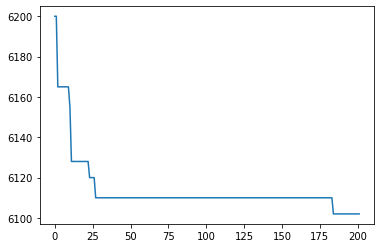

In [165]:
print(stats(best_score_sch))
sc = []
it = list(range(len(score_plot)))
print(len(it))
for score in score_plot:
    sc.append(score[1])

plt.plot(it, sc)
# plt.savefig('test_5.png')

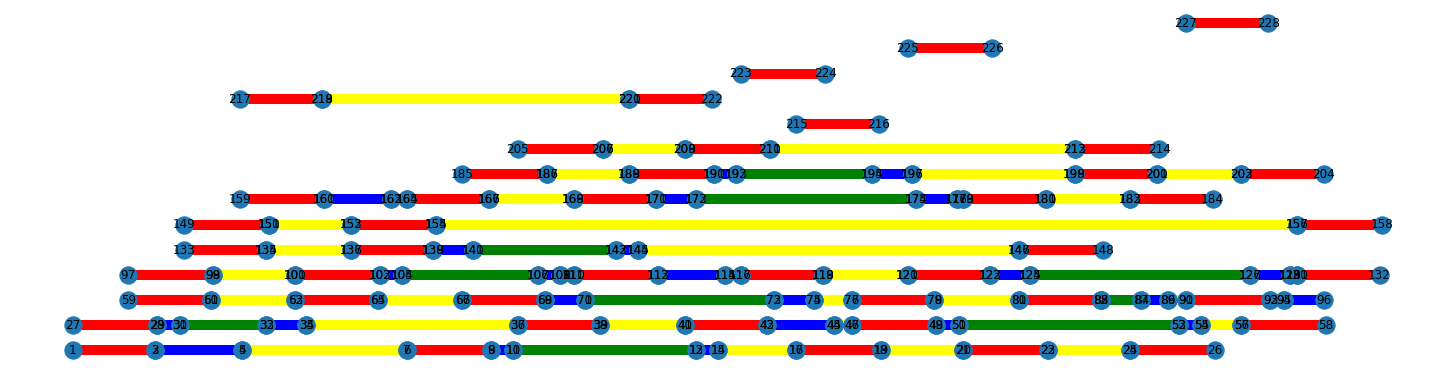

In [167]:
dummy = full_sch_vis(best, ndh, 0)

In [308]:
# print(score_plot)


num = 3
print(best[num])
print(best_score_sch[num])

for dh in ndh:
    if dh[0] == num:
        print(dh)

[['l2', 9.25, 9.65, 46.06], ['l1', 10.0, 10.4, 32.12], ['l4', 11.5, 11.86, 41.24], ['l1', 13.5, 13.9, 25.04]]
[['t', 9.25, 9.65], ['t', 10.0, 10.4], ['d', 10.4, 10.53], ['d', 11.07, 11.25], ['t', 11.5, 11.86], ['d', 11.86, 11.92], ['t', 13.5, 13.9], ['d', 13.9, 14.03], ['d', 14.69, 14.82]]
[3, 922, 996, 10.4, 10.53, 27.42]
[3, 996, 1035, 11.07, 11.25, 53.74]
[3, 1146, 1474, 11.86, 11.92, 38.98]
[3, 922, 996, 13.9, 14.03, 20.34]
[3, 996, 1474, 14.69, 14.82, 55.3]


In [ ]:
'''
graph for 
'''

[5, 922, 996, 9.9, 10.03, 41.36]
[5, 996, 1035, 10.34, 10.52, 53.74]
[5, 1474, 1146, 13.15, 13.21, 39.1]
['l1', 9.5, 9.9, 46.06]
['l2', 10.25, 10.65, 32.12]
['l1', 11.0, 11.4, 18.18]
['l2', 12.75, 13.15, 41.36]
['l1', 14.0, 14.4, 27.42]


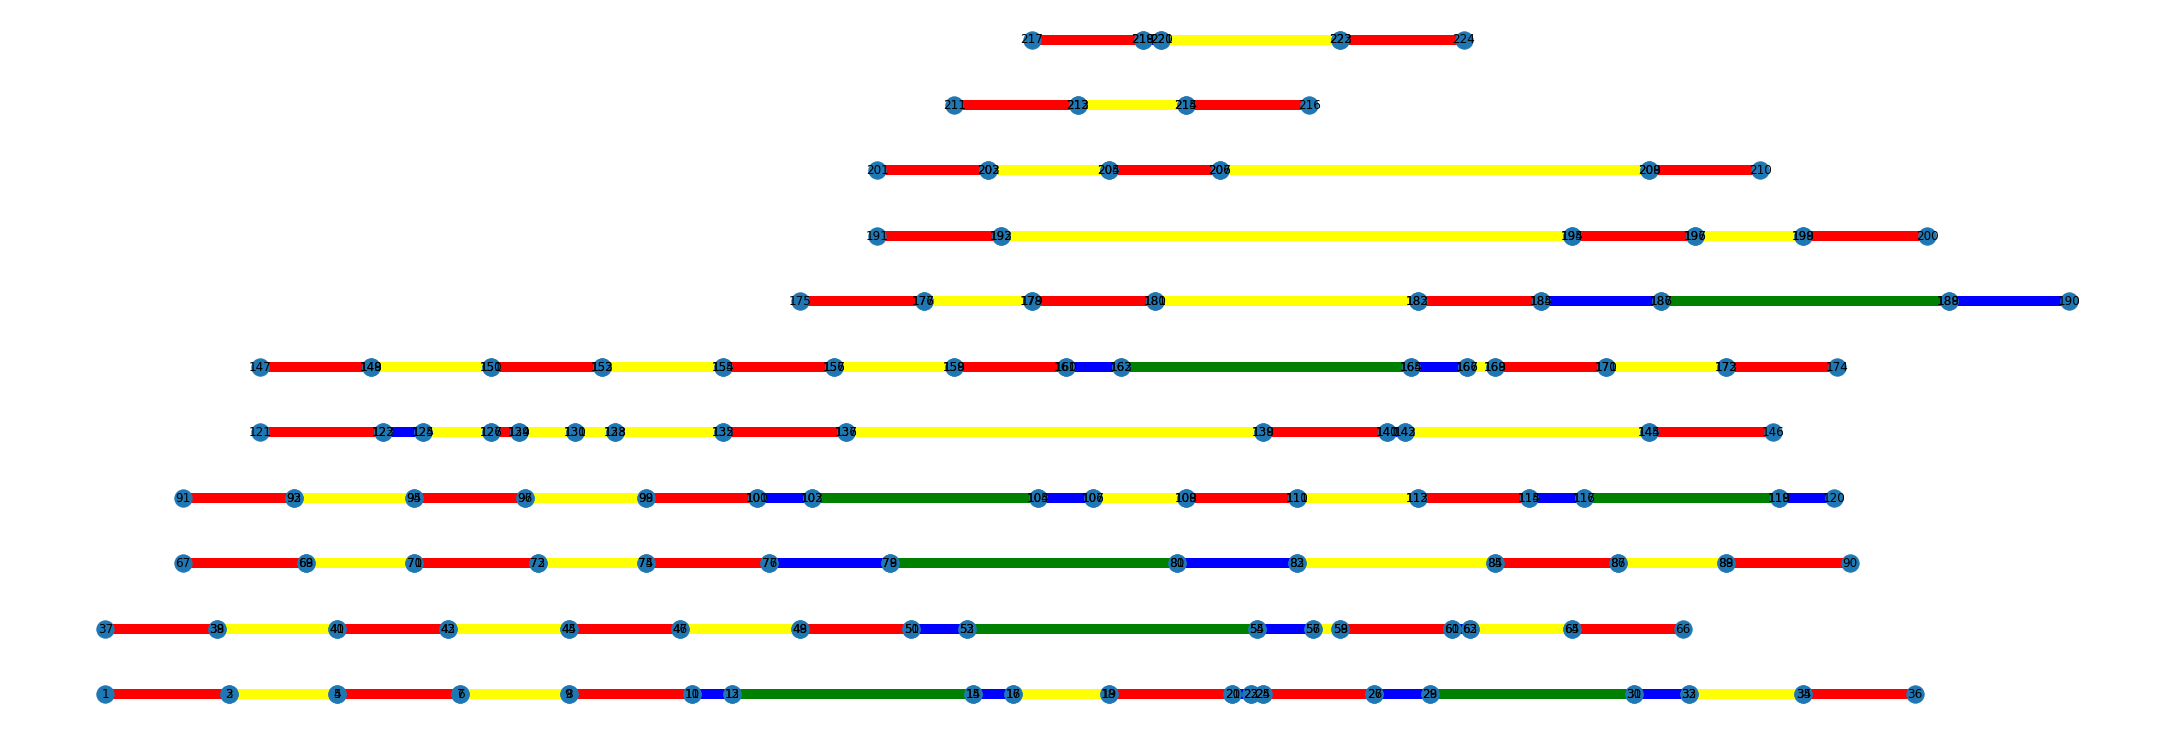

In [86]:
new_schedule = {}
# print(deadhead_trips)
dh_tripz = deepcopy(ndh)

for dh in dh_tripz:
    if dh[0] == 5:
        print(dh)

for trip in best[5]:
    print(trip)

for bus in best.keys():
    new_sch = []
    for trip in best[bus]:
        new_sch.append(['t', trip[1], trip[2]])
    
    for dh in dh_tripz:
            if dh[0] == bus:
                new_sch.append(['d', dh[3], dh[4]])
    
    new_schedule[bus] = sorted(new_sch, key=lambda y: y[1])

for bus in new_schedule.keys():
    charging_trips = []
    for t in range(1,len(new_schedule[bus])):
        if new_schedule[bus][t][1] != new_schedule[bus][t-1][2]:
            if new_schedule[bus][t-1][0] == 'd' and new_schedule[bus][t-1][0] == new_schedule[bus][t][0]:
                label = 'c'
            else:
                label = 's'
            charging_trips.append([label, new_schedule[bus][t-1][2], new_schedule[bus][t][1]])
#     for trip in charging_trips:
    new_schedule[bus].extend(charging_trips)
    new_schedule[bus].sort(key=lambda y: y[1])

ctr = 1
pos = {}
edges = []
edge_color = []

new_trip_graph = nx.Graph()
for bus in new_schedule.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        if seq[0] == 't':
            edge_color.append('red')
        elif seq[0] == 'd':
            edge_color.append('blue')
        elif seq[0] == 'c':
            edge_color.append('green')
        else:
            edge_color.append('yellow')

fig = plt.figure(figsize=(30,10))
new_trip_graph.add_nodes_from(pos)
new_trip_graph.add_edges_from(edges)
nx.draw(new_trip_graph, pos, with_labels = True, edge_color = edge_color, width = 10.0)
plt.savefig('best_schedule.png')

In [16]:
n = deepcopy(new_schd)
cov = len(rem_trips)
print(cov)
b, cov, dh_trips = new_stop(lines, rem_trips, n, cov)
print(rem_trips)

6
[['l1', 11.5, 12.0, 0.83], ['l2', 12.75, 13.25, 2.24], ['l1', 13.5, 14.0, 0.83], ['l3', 11.9, 12.4, 2.75], ['l4', 12.65, 13.15, 1.75], ['l3', 13.9, 14.4, 2.75]]


# Hello

In [11]:
# bus_sch = deepcopy(bus_schedule)
# dht = deepcopy(deadhead_trips)
# new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, dht_new = swap_check(bus_sch, dht)

for bus in bus_sch.items():
    print(bus[0])
    for trip in bus[1]:
        print(trip)
    print('^'*30)
print('-'*50)

for bus in new_schd.items():
    print(bus[0])
    for trip in bus[1]:
        print(trip)
    print('^'*30)
print('-'*50)

for dh in deadhead_trips:
    print(dh)
print('-'*50)

for dh in dht_new:
    print(dh)
print('-'*50)

1
['l1', 9, 9.5, 2.59]
['l2', 10.25, 10.75, 2.24]
['l1', 11.0, 11.5, 0.83]
['l2', 12.25, 12.75, 2.24]
['l1', 13.0, 13.5, 0.83]
['l2', 14.25, 14.75, 2.24]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
2
['l2', 9.25, 9.75, 2.59]
['l1', 10.0, 10.5, 1.18]
['l2', 11.25, 11.75, 2.24]
['l1', 12.0, 12.5, 0.83]
['l2', 13.25, 13.75, 2.24]
['l1', 14.0, 14.5, 0.83]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
3
['l3', 9.4, 9.9, 3.0]
['l4', 10.65, 11.15, 2.0]
['l3', 11.9, 12.4, 2.75]
['l4', 12.65, 13.15, 1.75]
['l3', 13.9, 14.4, 2.75]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
4
['l1', 9.5, 10.0, 2.59]
['l2', 10.75, 11.25, 2.24]
['l1', 11.5, 12.0, 0.83]
['l2', 12.75, 13.25, 2.24]
['l1', 13.5, 14.0, 0.83]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
5
['l4', 9.65, 10.15, 3.0]
['l3', 10.4, 10.9, 2.0]
['l4', 11.15, 11.65, 1.0]
['l3', 12.4, 12.9, 2.75]
['l4', 13.15, 13.65, 1.75]
['l3', 14.4, 14.9, 2.75]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
6
['l2', 9.75, 10.25, 2.59]
['l1', 10.5, 11.0, 1.18]
['l2', 11.75, 12.25, 2.24]
['l1', 12.5, 13.0, 0.83]
['l2', 13.75, 14.25

In [325]:

#dht_new.pop(-1)
# dht_new.pop(-1)
# for dh in dht_new:
#     print(dh)
# print('-'*50)

0.028571428571428206

In [337]:
'''
SCHEDULE SCORING:

minimize number of buses
minimize standing time
minimize
'''

stats(new_schedule)

Schedule stats: 
----------------------------------------------------------------------------------------------------
Number of buses:  8
----------------------------------------------------------------------------------------------------
Number of deadhead trips:  7
----------------------------------------------------------------------------------------------------
Time spent deadheading:  0.74
----------------------------------------------------------------------------------------------------
Number of charging trips:  7
----------------------------------------------------------------------------------------------------
Time spent charging:  1.99
----------------------------------------------------------------------------------------------------
Time spent standing:  8.17


In [292]:
for d in stop_dist.values():
    print(d)

'''
OLD FEAS FUNCTION:

# def new_sch_feas_test(bus):
# #     print(bus)
#     if len(bus) > 1:
#         if bus[-1][0] == bus[-2][0]:
# #             print('a')
#             return 0
#             # CAN'T HAVE CONSECUTIVE TRIPS WITH THE SAME LABEL
#         else:
#             curr_stop = lines[bus[-1][0]][0]
#             prev_stop = lines[bus[-2][0]][1]
#             curr_trip_start = bus[-1][1]
#             prev_trip_end = bus[-2][2]
#             prev_trip_start = bus[-2][1]
#             for st in stop_dist[prev_stop]:
#                 if curr_stop == st[0]:
#                     if round(curr_trip_start - prev_trip_end, 2) < round(st[1]/speed, 2):
#                         return 0
#                         # TIME REQUIRED FOR DEADHEAD IS MORE THAN THE TIME WINDOW B/W 2 TRIPS
#                     else:
#                         next_dists = possible_swap(curr_stop, stop_dist)
#                         for d in next_dists:
#                             if d[0] == depot_node[0]:
#                                 charge_trip_next = d[1]
#                         if bus[-2][-1] - st[1] - charge_trip_next <= 0:
#                             return 0
#                         else:
#                             print(bus[-2][-1], bus[-1][-1], st[1], charge_trip_next)
#                             bus[-1][-1] = round(bus[-2][-1] - bus[-1][-1], 2)
#                             print(charge_trip_next)
#                             print(curr_stop)
#                             return 1
'''
print('-'*100)
print(new_schd[5])
print(stop_dist[lines['l4'][1]])
print(lines[new_schd[5][-1][0]][0])

[[1, 1.77], [2, 0.35], [3, 0.25], [4, 1.25], [0, 0.05]]
[[1, 0.05], [4, 1.2], [2, 1.41], [3, 1.56], [0, 1.77]]
[[2, 0.05], [3, 0.2], [0, 0.35], [4, 1.02], [1, 1.41]]
[[3, 0.05], [2, 0.2], [0, 0.25], [4, 1.0], [1, 1.56]]
[[4, 0.05], [3, 1.0], [2, 1.02], [1, 1.2], [0, 1.25]]
----------------------------------------------------------------------------------------------------
[['l4', 9.65, 10.15, 3.0], ['l3', 10.4, 10.9, 2.0], ['l4', 11.15, 11.65, 1.0], ['l3', 12.4, 12.9, 2.75], ['l4', 13.15, 13.65, 1.75], ['l2', 13.75, 14.25, 0.34]]
[[3, 0.05], [2, 0.2], [0, 0.25], [4, 1.0], [1, 1.56]]
2
1.41


In [ ]:
# def new_sch_feas_test(bus):
# #     print(bus)
#     if len(bus) > 1:
#         if bus[-1][0] == bus[-2][0]:
# #             print('a')
#             return 0
#             # CAN'T HAVE CONSECUTIVE TRIPS WITH THE SAME LABEL
#         else:
#             curr_stop = lines[bus[-1][0]][0]
#             prev_stop = lines[bus[-2][0]][1]
#             curr_trip_start = bus[-1][1]
#             prev_trip_end = bus[-2][2]
#             prev_trip_start = bus[-2][1]
#             for st in stop_dist[prev_stop]:
#                 if curr_stop == st[0]:
#                     if round(curr_trip_start - prev_trip_end, 2) < round(st[1]/speed, 2):
#                         return 0
#                         # TIME REQUIRED FOR DEADHEAD IS MORE THAN THE TIME WINDOW B/W 2 TRIPS
#                     else:
#                         next_dists = possible_swap(curr_stop, stop_dist)
#                         for d in next_dists:
#                             if d[0] == depot_node[0]:
#                                 charge_trip_next = d[1]
#                         if bus[-2][-1] - st[1] - charge_trip_next <= 0:
#                             return 0
#                         else:
#                             print(bus[-2][-1], bus[-1][-1], st[1], charge_trip_next)
#                             bus[-1][-1] = round(bus[-2][-1] - bus[-1][-1], 2)
#                             print(charge_trip_next)
#                             print(curr_stop)
#                             return 1

In [9]:
n_bus_1 = deepcopy(new_bus_1)
n_bus_2 = deepcopy(new_bus_2)
nn_schd = deepcopy(new_schd)
remy = deepcopy(rem_trips)
print(remy)
print('-'*100)
print(old_bus_1)
print(old_bus_2)
print('-'*100)
for bus in nn_schd.items():
    print(bus)

[['l3', 10.4, 10.9, 2.0], ['l4', 11.15, 11.65, 1.0], ['l3', 12.4, 12.9, 2.75], ['l4', 13.15, 13.65, 1.75], ['l3', 14.4, 14.9, 2.75], ['l1', 10.0, 10.5, 1.18], ['l2', 11.25, 11.75, 2.24], ['l1', 12.0, 12.5, 0.83], ['l2', 13.25, 13.75, 2.24], ['l1', 14.0, 14.5, 0.83]]
----------------------------------------------------------------------------------------------------
[['l4', 9.65, 10.15, 3.0], ['l3', 10.4, 10.9, 2.0], ['l4', 11.15, 11.65, 1.0], ['l3', 12.4, 12.9, 2.75], ['l4', 13.15, 13.65, 1.75], ['l3', 14.4, 14.9, 2.75]]
[['l2', 9.25, 9.75, 2.59], ['l1', 10.0, 10.5, 1.18], ['l2', 11.25, 11.75, 2.24], ['l1', 12.0, 12.5, 0.83], ['l2', 13.25, 13.75, 2.24], ['l1', 14.0, 14.5, 0.83]]
----------------------------------------------------------------------------------------------------
(1, [['l1', 9, 9.5, 2.59], ['l2', 10.25, 10.75, 2.24], ['l1', 11.0, 11.5, 0.83], ['l2', 12.25, 12.75, 2.24], ['l1', 13.0, 13.5, 0.83], ['l2', 14.25, 14.75, 2.24]])
(2, [['l4', 9.65, 10.15, 1.0]])
(3, [['l3', 9.4

In [11]:
# for bus in new_schd.items():
#     print(bus)

# def insert_trip(bus, rem_trips):

# def adjust_trips(bus, rem_trips):

In [48]:
# (0, [[1, 1.77], [2, 0.35], [3, 0.25], [4, 1.25], [0, 0.05]])
# (1, [[1, 0.05], [4, 1.2], [2, 1.41], [3, 1.56], [0, 1.77]])
# (2, [[2, 0.05], [3, 0.2], [0, 0.35], [4, 1.02], [1, 1.41]])
# (3, [[3, 0.05], [2, 0.2], [0, 0.25], [4, 1.0], [1, 1.56]])
# (4, [[4, 0.05], [3, 1.0], [2, 1.02], [1, 1.2], [0, 1.25]])

In [49]:
# [['l4', 11.15, 11.65, 1.0]] [['l1', 9.5, 10.0, 2.59], ['l1', 10.5, 11.0, 1.41], ['l3', 11.4, 11.9, 1.0]] [['l3', 11.4, 11.9, 3.0]] [['l1', 9.5, 10.0, 2.59], ['l4', 11.15, 11.65, 1.0], ['l1', 10.5, 11.0, 1.41]]
# [['l3', 10.4, 10.9, 1.0]] [['l1', 9, 9.5, 2.59], ['l1', 10.0, 10.5, 1.41], ['l3', 10.9, 11.4, 1.0]] [['l3', 10.9, 11.4, 1.0]] [['l1', 9, 9.5, 2.59], ['l3', 10.4, 10.9, 1.0], ['l1', 10.0, 10.5, 1.41]]
# [['l4', 9.65, 10.15, 3.0], ['l4', 10.65, 11.15, 1.0], ['l3', 11.4, 11.9, 1.0]] [['l3', 10.4, 10.9, 1.0]] [['l4', 9.65, 10.15, 3.0], ['l3', 10.4, 10.9, 2.0], ['l4', 10.65, 11.15, 1.0]] [['l3', 11.4, 11.9, 3.0]]
# ----------------------------------------------------------------------------------------------------
# [['l4', 9.65, 10.15, 3.0], ['l3', 11.4, 11.9, 1.0]]
# [['l2', 11.25, 11.75, 1.41]]

In [266]:
def new_sch_feas_test(bus):
    if len(bus) > 1:
        if bus[-1][0] == bus[-2][0]:
            return 0
            # CAN'T HAVE CONSECUTIVE TRIPS WITH THE SAME LABEL
        else:
            curr_stop = lines[bus[-1][0]][0]
            prev_stop = lines[bus[-2][0]][1]
            curr_trip_start = bus[-1][1]
            prev_trip_end = bus[-2][2]
            prev_trip_start = bus[-2][1]
            for st in stop_dist[prev_stop]:
                if curr_stop == st[0]:
                    if round(curr_trip_start - prev_trip_end, 2) < round(st[1]/speed, 2):
                        return 0
                        # TIME REQUIRED FOR DEADHEAD IS MORE THAN THE TIME WINDOW B/W 2 TRIPS
                    else:
                        next_dists = possible_swap(curr_trip_start, stop_dist)
                        for d in next_dists:
                            if d[0] == depot_node[0]:
                                charge_trip_next = d[1]
                        if bus[-2][-1] - st[1] - charge_trip_next <= 0:
                            return 0
                        else:
                            return 1
    else:
        bus[-1][-1] = b_range - bus[-1][-1]
        return 1
#                     break
        #     print('^'*50)
    
#     return 1

for stop in stop_dist.items():
    print(stop)
print('-'*100)

id = [i+1 for i in range(len(bus_schedule.keys()))]

# print(lines)
# print('-'*100)

bus_test = {9: [['l1', 9, 9.5, 2.59], ['l2', 10.25, 10.75, 2.24], ['l4', 11.15, 11.65, 1.0]]}
busss = bus_test[9]
for t in range(1,len(busss)):
    print(busss[t])
    curr_stop = lines[busss[t][0]][0]
    prev_stop = lines[busss[t-1][0]][1]
#     print(prev_stop, curr_stop)
    for st in stop_dist[prev_stop]:
#         print(st)
        if curr_stop == st[0]:
            print(round(st[1]/speed, 2))
            print(round(busss[t][1] - busss[t-1][2], 2))
            break
    print('^'*50)

#     print(stop_dist[prev_stop])
#     print(bus_test[t], bus_test[t-1])

(0, [[1, 1.77], [2, 0.35], [3, 0.25], [4, 1.25], [0, 0.05]])
(1, [[1, 0.05], [4, 1.2], [2, 1.41], [3, 1.56], [0, 1.77]])
(2, [[2, 0.05], [3, 0.2], [0, 0.35], [4, 1.02], [1, 1.41]])
(3, [[3, 0.05], [2, 0.2], [0, 0.25], [4, 1.0], [1, 1.56]])
(4, [[4, 0.05], [3, 1.0], [2, 1.02], [1, 1.2], [0, 1.25]])
----------------------------------------------------------------------------------------------------
['l2', 10.25, 10.75, 2.24]
0.02
0.75
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
['l4', 11.15, 11.65, 1.0]
0.43
0.4
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [163]:
#         if bus[t][0] == bus[t-1][0]:
#             return 0
#             # CAN'T HAVE CONSECUTIVE TRIPS WITH THE SAME LABEL
#         else:
#             curr_stop = lines[bus[t][0]][0]
#             prev_stop = lines[bus[t-1][0]][1]
#             curr_trip_start = bus[t][1]
#             prev_trip_end = bus[t-1][2]
#             prev_trip_start = bus[t-1][1]
#             for st in stop_dist[prev_stop]:
#                 if curr_stop == st[0]:
#                     if round(curr_trip_start - prev_trip_end, 2) < round(st[1]/speed, 2):
#                         return 0
#                         # TIME REQUIRED FOR DEADHEAD IS MORE THAN THE TIME WINDOW B/W 2 TRIPS
#                     else:
#                         if bus[t-1][-1] - st[1] - bus[t][-2] <= 0:
#                             return 0
# #                         elif bus[t-1][-1] - st[1] - bus[t][-2] - stop_dist[bus[t][1]]
# #                         if bus[t-1] == 'n' and t-1 == 0:
# #                             del bus[t-1][-1]
# #                             bus[t-1][-1] = b_range - bus[t-1][-1]
# #                             if bus[t-1][-1] - st[1] < bus[t][-1]:
# #                                 return 0
#                     break
#         #     print('^'*50)
    
#     return 1

In [31]:
'''
MERGE AND INSERT
'''

n_schd = deepcopy(new_schd)

def to_be_merged(bus_sch):
    rem = []
    priority_buses = []
    for bus in bus_sch.items():
        if len(bus[1]) == 1:
#             print(bus[0])
            priority_buses.append(bus[1][0])
            rem.append(bus[0])
    
    for id in rem:
        del bus_sch[id]
    
    return priority_buses

def calc_time_slots(bus_sch):
    start = op_start
    end = op_end
    vacancies = {}
    for bus in bus_sch.items():
        time_slots = []
        for trip in bus[1]:
            if start != trip[1]:
                time_slots.append([start, trip[1]])
            start = trip[2]
        if end != trip[2]:
            time_slots.append([trip[2], end])

        vacancies[bus[0]] = time_slots
    
    insertion_points = {}
    for trip in pri_buses:
        insertion_points[tuple(trip)] = []
        for vac in vacancies.items():
            for slot in vac[1]:
                if trip[2] <= slot[1] and trip[1] >= slot[0]:
                    insertion_points[tuple(trip)].append([vac[0],slot]) 

    return insertion_points

'''
ADDING BUSES WITH SINGLE TRIPS TO THE REST
IF TRIP HAS NO AVAILABLE SLOTS; CREATE NEW BUS AND ASSIGN IT TO THE TRIP
IF THERE ARE MULTIPLE CHOOSE ONE AT RANDOM
'''
def merge_trips(bus_sch, slots):
    new_bus = None
    for trip in slots.items():
        if trip[1] != []:
            if len(trip[1]) > 1:
                t = random.choice(trip[1])
                print(t, 'a')
                bus_sch[t[0]].append(list(trip[0]))
                print(bus_sch[t[0]])
                bus_sch[t[0]].sort(key=lambda y: y[1])
                print(bus_sch[t[0]])
                new_bus = bus_sch[t[0]]
            else:
                bus_sch[trip[1][0][0]].append(list(trip[0]))
                bus_sch[trip[1][0][0]].sort(key=lambda y: y[1])
                new_bus = bus_sch[t[0]]
        else:
            id = len(list(bus_sch.keys()))
            bus_sch[id] = list(trip[0])
    
    return (bus_sch, new_bus)
                
# def schedule_feasibility_check(bus_sch):
#     for t in range(1,len(bus_1)):
#         if bus_1[t][0] == bus_1[t-1][0]:
#             return 0
    
#     for t in range(1,len(bus_2)):
#         if bus_2[t][0] == bus_2[t-1][0]:
#             return 0
    
#     return 1

pri_buses = to_be_merged(n_schd)
slots = calc_time_slots(n_schd)
new_new_sch, nn_bus = merge_trips(n_schd, slots)

for bus in new_schd.items():
    print(bus)
print('-'*100)

for bus in new_new_sch.items():
    print(bus)
print('-'*100)

print('a')

(1, [['l1', 9, 9.5, 2.59], ['l2', 10.25, 10.75, 2.24], ['l1', 11.0, 11.5, 0.83], ['l2', 12.25, 12.75, 2.24], ['l1', 13.0, 13.5, 0.83], ['l2', 14.25, 14.75, 2.24]])
(2, [['l2', 9.25, 9.75, 2.59], ['l1', 10.0, 10.5, 1.18], ['l2', 11.25, 11.75, 2.24], ['l1', 12.0, 12.5, 0.83], ['l2', 13.25, 13.75, 2.24], ['l1', 14.0, 14.5, 0.83]])
(3, [['l3', 9.4, 9.9, 3.0], ['l4', 10.65, 11.15, 2.0], ['l3', 11.9, 12.4, 2.75], ['l4', 12.65, 13.15, 1.75], ['l3', 13.9, 14.4, 2.75]])
(4, [['l1', 9.5, 10.0, 2.59], ['l2', 10.75, 11.25, 2.24], ['l1', 11.5, 12.0, 0.83], ['l2', 12.75, 13.25, 2.24], ['l1', 13.5, 14.0, 0.83]])
(5, [['l4', 9.65, 10.15, 3.0], ['l3', 10.4, 10.9, 2.0], ['l4', 11.15, 11.65, 1.0], ['l3', 12.4, 12.9, 2.75], ['l4', 13.15, 13.65, 1.75], ['l3', 14.4, 14.9, 2.75]])
(6, [['l2', 9.75, 10.25, 2.59], ['l1', 10.5, 11.0, 1.18], ['l2', 11.75, 12.25, 2.24], ['l1', 12.5, 13.0, 0.83], ['l3', 13.4, 13.9, -0.17]])
(7, [['l3', 10.9, 11.4, 3.0], ['l4', 11.65, 12.15, 2.0], ['l3', 12.9, 13.4, 2.75], ['l4', 1

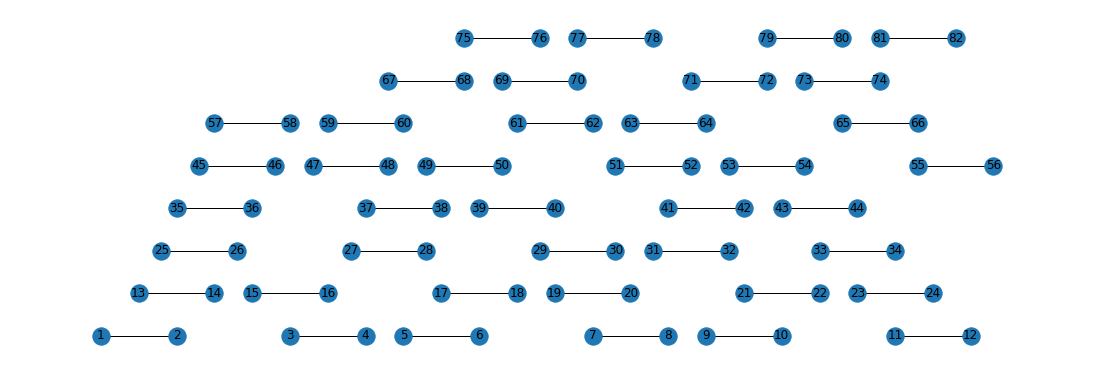

In [262]:
ctr = 1
pos = {}
edges = []
edge_color = []
Trip_graph = nx.Graph()
for bus in new_schd.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        
fig = plt.figure(figsize=(15,5))
Trip_graph.add_nodes_from(pos)
Trip_graph.add_edges_from(edges)
nx.draw(Trip_graph, pos, with_labels = True)
plt.savefig('new_schedule_basic.png')

[['t', 9.25, 9.75], ['s', 9.75, 10.0], ['t', 10.0, 10.5], ['d', 10.5, 10.62], ['c', 10.62, 10.95], ['d', 10.95, 11.07], ['s', 11.07, 11.25], ['t', 11.25, 11.75], ['s', 11.75, 12.0], ['t', 12.0, 12.5], ['d', 12.5, 12.62], ['c', 12.62, 12.97], ['d', 12.97, 13.1], ['s', 13.1, 13.25], ['t', 13.25, 13.75], ['s', 13.75, 14.0], ['t', 14.0, 14.5]]
----------------------------------------------------------------------------------------------------


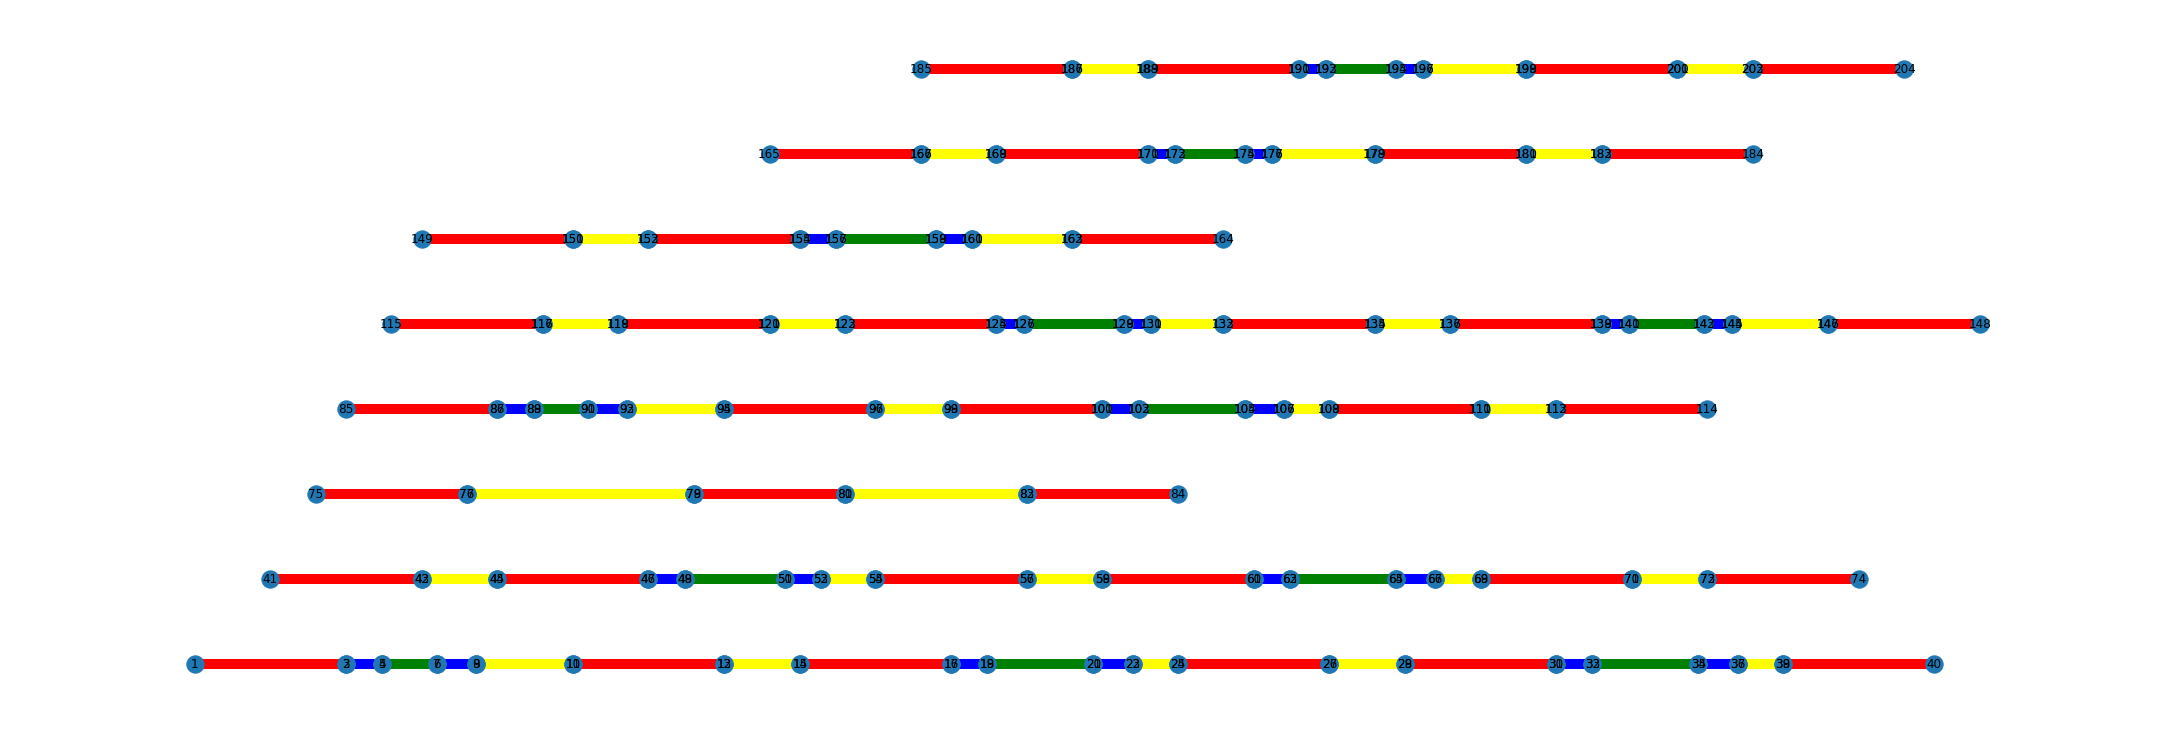

In [314]:
new_schedule = {}
# print(deadhead_trips)
dh_tripz = deepcopy(dht_new)

for bus in new_schd.keys():
    new_sch = []
    for trip in new_schd[bus]:
        new_sch.append(['t', trip[1], trip[2]])
    
    for dh in dh_tripz:
            if dh[0] == bus:
                new_sch.append(['d', dh[3], dh[4]])
    
    new_schedule[bus] = sorted(new_sch, key=lambda y: y[1])

for bus in new_schedule.keys():
    charging_trips = []
    for t in range(1,len(new_schedule[bus])):
        if new_schedule[bus][t][1] != new_schedule[bus][t-1][2]:
            if new_schedule[bus][t-1][0] == 'd' and new_schedule[bus][t-1][0] == new_schedule[bus][t][0]:
                label = 'c'
            else:
                label = 's'
            charging_trips.append([label, new_schedule[bus][t-1][2], new_schedule[bus][t][1]])
#     for trip in charging_trips:
    new_schedule[bus].extend(charging_trips)
    new_schedule[bus].sort(key=lambda y: y[1])

print(new_schedule[2])
print('-'*100)

ctr = 1
pos = {}
edges = []
edge_color = []

new_trip_graph = nx.Graph()
for bus in new_schedule.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        if seq[0] == 't':
            edge_color.append('red')
        elif seq[0] == 'd':
            edge_color.append('blue')
        elif seq[0] == 'c':
            edge_color.append('green')
        else:
            edge_color.append('yellow')

fig = plt.figure(figsize=(30,10))
new_trip_graph.add_nodes_from(pos)
new_trip_graph.add_edges_from(edges)
nx.draw(new_trip_graph, pos, with_labels = True, edge_color = edge_color, width = 10.0)
plt.savefig('new_schedule.png')

In [272]:
# bus_sch = deepcopy(bus_schedule)
# bus_num = list(bus_sch.keys())
# print(bus_num)
# random.shuffle(bus_num)
# print(bus_num)

# t = random.uniform(op_start, op_end)
# print(t)

# bus_1 = bus_sch[bus_num[0]]
# bus_2 = bus_sch[bus_num[1]]
# print(bus_1, bus_2)

# trip_1, trip_2 = trip_check(bus_1, bus_2, t)
# print(trip_1, '&', trip_2)

In [273]:
# def trip_check(bus_1, bus_2, swap_time):
#     trip_1 = None
#     trip_2 = None
#     temp_1 = None
#     temp_2 = None
#     for t in range(len(bus_1)):
#         if bus_1[t][1] > swap_time:
#             temp_1 =  bus_1[t]
#             break

#     for t in range(len(bus_2)):
#         if bus_2[t][1] > swap_time:
#             trip_2 = bus_2[t]
#             temp_2 = bus_2[t]    
    
#     if temp_1 != None:
#         for trip in trip_copy:
#             if temp_1[0] == trip[0] and temp_1[1] == trip[1]:
#                 trip_1 = trip
#                 break

#     if temp_2 != None:
#         for trip in trip_copy:
#             if temp_2[0] == trip[0] and temp_2[1] == trip[1]:
#                 trip_2 = trip
#                 break
    
#     return (trip_1, trip_2)

# print(t)
# trip_1, trip_2 = trip_check(bus_1, bus_2, t)
# print(trip_1, '&', trip_2)

# # bus_1 = bus_schedule[bus_1]
# # bus_2 = bus_schedule[bus_2]
# # print(bus_1)
# # print(bus_2)

In [274]:
'''
Pick random bus and time; Check if trips from 5 different buses can be inserted there
Rank them based on battery usage
'''

'''
For mergers, try to insert trip during standing time
'''



'\nFor mergers, try to insert trip during standing time\n'

"\n[['t', 9, 9.5], ['d', 9.5, 9.62], ['c', 9.62, 9.8], ['d', 9.8, 9.93], ['s', 9.93, 10.25], \n['t', 10.25, 10.75], ['s', 10.75, 11.0], ['t', 11.0, 11.5]]\n\n['l1', 9, 9.5, 2.59]\n['l2', 10.25, 10.75, 2.24]\n['l1', 11.0, 11.5, 0.83]\n\n[1, 2, 0, 9.5, 9.62, 2.24]\n[1, 0, 2, 9.8, 9.93, 3.65]\n"

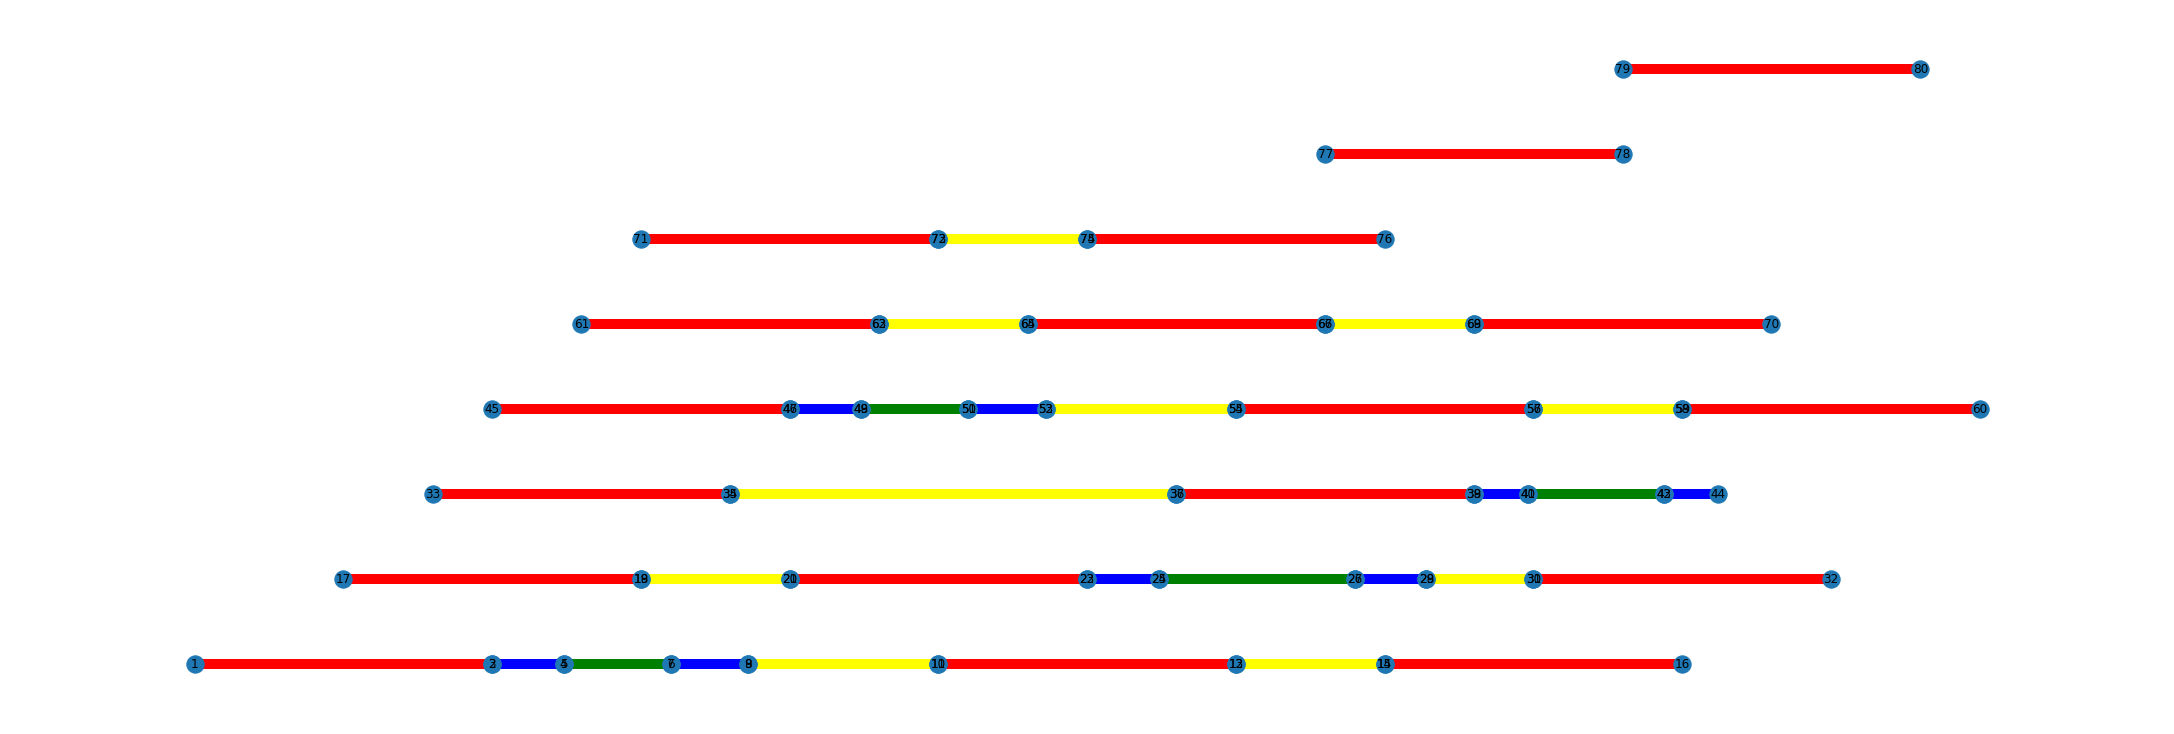

In [58]:
# '''
# REVISED: COMPLETE SCHEDULE
# '''

# new_schedule = {}
# dh_tripz = deepcopy(deadhead_trips)

# for bus in bus_schedule.keys():
#     new_sch = []
#     for trip in bus_schedule[bus]:
#         new_sch.append([('t', trip[0]), trip[1], trip[2], trip[3]])
    
#     for dh in dh_tripz:
#             if dh[0] == bus:
#                 new_sch.append([('d', None), dh[3], dh[4], dh[5]])
    
#     new_schedule[bus] = sorted(new_sch, key=lambda y: y[1])

# # for bus in new_schedule.values():
# #     print(bus)
# #     print('-'*100)
# # trav = 0
# for bus in new_schedule.keys():
#     charging_trips = []
#     for t in range(1,len(new_schedule[bus])):
#         if new_schedule[bus][t][1] != new_schedule[bus][t-1][2]:
#             if new_schedule[bus][t-1][0][0] == 'd' and new_schedule[bus][t-1][0][0] == new_schedule[bus][t][0][0]:
#                 label = 'c'
#                 trav = b_range
#             else:
#                 label = 's'
#                 trav = new_schedule[bus][t-1][3]
#             charging_trips.append([(label, None), new_schedule[bus][t-1][2], new_schedule[bus][t][1], trav])
# #     for trip in charging_trips:
#     new_schedule[bus].extend(charging_trips)
#     new_schedule[bus].sort(key=lambda y: y[1])

# # print(new_schedule[1])
# # print('-'*100)

# ctr = 1
# pos = {}
# edges = []
# edge_color = []

# new_trip_graph = nx.Graph()
# for bus in new_schedule.items():
#     for seq in bus[1]:
#         pos[ctr] = (seq[1], bus[0])
#         ctr += 1
#         pos[ctr] = (seq[2], bus[0])
#         ctr += 1
#         edges.append((ctr-2,ctr-1))
#         if seq[0][0] == 't':
#             edge_color.append('red')
#         elif seq[0][0] == 'd':
#             edge_color.append('blue')
#         elif seq[0][0] == 'c':
#             edge_color.append('green')
#         else:
#             edge_color.append('yellow')

# fig = plt.figure(figsize=(30,10))
# new_trip_graph.add_nodes_from(pos)
# new_trip_graph.add_edges_from(edges)
# nx.draw(new_trip_graph, pos, with_labels = True, edge_color = edge_color, width = 10.0)
# plt.savefig('schedule.png')

# '''
# [['t', 9, 9.5], ['d', 9.5, 9.62], ['c', 9.62, 9.8], ['d', 9.8, 9.93], ['s', 9.93, 10.25], 
# ['t', 10.25, 10.75], ['s', 10.75, 11.0], ['t', 11.0, 11.5]]

# ['l1', 9, 9.5, 2.59]
# ['l2', 10.25, 10.75, 2.24]
# ['l1', 11.0, 11.5, 0.83]

# [1, 2, 0, 9.5, 9.62, 2.24]
# [1, 0, 2, 9.8, 9.93, 3.65]
# '''

In [275]:
# '''
# TRY SWAP, THEN MERGE
# '''

# def stand_times(bus_1):
    
#     stand_times = []
#     for trip in bus_1:
#         if trip[0][0] == 's':
#             stand_times.append([trip[1], round(trip[2]-trip[1], 2)])
    
#     if stand_times == []:
#         return None
#     else:
#         stand_times.sort(key = lambda tup: tup[-1])
#     return stand_times
            
# def insert_trip(bus_1, st_times):
# #     ctr = 0
# #     print(bus_1)
# #     print('-'*20)
#     for bus in bus_sch.values():
# #         print(bus)
#         if bus == bus_1:
#             continue
#         else:
#             for trip in bus:
                
# #             ctr += 1
# #     return ctr

# bus_sch = deepcopy(new_schedule)
# bus_ids = list(bus_sch.keys())
# # random.shuffle(bus_ids)
# bus_num = bus_ids[2]#[0]

# print(bus_ids)
# print('-'*20)
# print(bus_num)
# print('-'*20)

# bus_1 = bus_sch[bus_num]
# print(bus_1)
# print('-'*20)

# st = stand_times(bus_1)
# print(st)
# print('-'*20)

# print(insert_trip(bus_1, st))
# # swap_time = round(random.uniform(op_start, op_end), 2)
# # print(swap_time)
# # print('-'*20)

# # trip_check(bus_1, swap_time)

In [86]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# df = pd.DataFrame(bus_schedule)
# df

# for bus in bus_schedule.items():
#     for trip in bus:
#         print(trip)
#     print('-'*20)
    
# # Start of run time
# proj_start = df.Start.min()
# # Bus trip duration
# # df['start_num'] = (df.Start-proj_start).dt.days
# # # number of days from project start to end of tasks
# # df['end_num'] = (df.End-proj_start).dt.days
# # # days between start and end of each task
# # df['days_start_to_end'] = df.end_num - df.start_num

# fig, ax = plt.subplots(1, figsize=(16,6))
# ax.barh(df.Task, df.days_start_to_end, left=df.start_num)
# plt.show()

In [32]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.patches import Patch
# from pandas import Timestamp

# ##### DATA #####
# data = {'Task': {0: 'TSK M',
#                  1: 'TSK N',
#                  2: 'TSK L',
#                  3: 'TSK K',
#                  4: 'TSK J',
#                  5: 'TSK H',
#                  6: 'TSK I',
#                  7: 'TSK G',
#                  8: 'TSK F',
#                  9: 'TSK E',
#                  10: 'TSK D',
#                  11: 'TSK C',
#                  12: 'TSK B',
#                  13: 'TSK A'},

#  'Department': {0: 'IT',
#                 1: 'MKT',
#                 2: 'ENG',
#                 3: 'PROD',
#                 4: 'PROD',
#                 5: 'FIN',
#                 6: 'MKT',
#                 7: 'FIN',
#                 8: 'MKT',
#                 9: 'ENG',
#                 10: 'FIN',
#                 11: 'IT',
#                 12: 'MKT',
#                 13: 'MKT'},
 
#  'Start': {0: Timestamp('2022-03-17 00:00:00'),
#            1: Timestamp('2022-03-17 00:00:00'),
#            2: Timestamp('2022-03-10 00:00:00'),
#            3: Timestamp('2022-03-09 00:00:00'),
#            4: Timestamp('2022-03-04 00:00:00'),
#            5: Timestamp('2022-02-28 00:00:00'),
#            6: Timestamp('2022-02-28 00:00:00'),
#            7: Timestamp('2022-02-27 00:00:00'),
#            8: Timestamp('2022-02-26 00:00:00'),
#            9: Timestamp('2022-02-23 00:00:00'),
#            10: Timestamp('2022-02-22 00:00:00'),
#            11: Timestamp('2022-02-21 00:00:00'),
#            12: Timestamp('2022-02-19 00:00:00'),
#            13: Timestamp('2022-02-15 00:00:00')},
 
#  'End': {0: Timestamp('2022-03-20 00:00:00'),
#          1: Timestamp('2022-03-19 00:00:00'),
#          2: Timestamp('2022-03-13 00:00:00'),
#          3: Timestamp('2022-03-13 00:00:00'),
#          4: Timestamp('2022-03-17 00:00:00'),
#          5: Timestamp('2022-03-02 00:00:00'),
#          6: Timestamp('2022-03-05 00:00:00'),
#          7: Timestamp('2022-03-03 00:00:00'),
#          8: Timestamp('2022-02-27 00:00:00'),
#          9: Timestamp('2022-03-09 00:00:00'),
#          10: Timestamp('2022-03-01 00:00:00'),
#          11: Timestamp('2022-03-03 00:00:00'),
#          12: Timestamp('2022-02-24 00:00:00'),
#          13: Timestamp('2022-02-20 00:00:00')},
 
#  'Completion': {0: 0.0,
#                 1: 0.0,
#                 2: 0.0,
#                 3: 0.0,
#                 4: 0.0,
#                 5: 1.0,
#                 6: 0.4,
#                 7: 0.7,
#                 8: 1.0,
#                 9: 0.5,
#                 10: 1.0,
#                 11: 0.9,
#                 12: 1.0,
#                 13: 1.0}}


# ##### DATA PREP ##### 
# df = pd.DataFrame(data)

# # project start date
# proj_start = df.Start.min()

# # number of days from project start to task start
# df['start_num'] = (df.Start-proj_start).dt.days

# # number of days from project start to end of tasks
# df['end_num'] = (df.End-proj_start).dt.days

# # days between start and end of each task
# df['days_start_to_end'] = df.end_num - df.start_num

# # days between start and current progression of each task
# df['current_num'] = (df.days_start_to_end * df.Completion)

# # create a column with the color for each department
# def color(row):
#     c_dict = {'MKT':'#E64646', 'FIN':'#E69646', 'ENG':'#34D05C', 'PROD':'#34D0C3', 'IT':'#3475D0'}
#     return c_dict[row['Department']]

# df['color'] = df.apply(color, axis=1)

# ##### PLOT #####
# fig, (ax, ax1) = plt.subplots(2, figsize=(16,6), gridspec_kw={'height_ratios':[6, 1]}, facecolor='#36454F')
# ax.set_facecolor('#36454F')
# ax1.set_facecolor('#36454F')
# # bars
# ax.barh(df.Task, df.current_num, left=df.start_num, color=df.color)
# ax.barh(df.Task, df.days_start_to_end, left=df.start_num, color=df.color, alpha=0.5)

# for idx, row in df.iterrows():
#     ax.text(row.end_num+0.1, idx, f"{int(row.Completion*100)}%", va='center', alpha=0.8, color='w')
#     ax.text(row.start_num-0.1, idx, row.Task, va='center', ha='right', alpha=0.8, color='w')


# # grid lines
# ax.set_axisbelow(True)
# ax.xaxis.grid(color='k', linestyle='dashed', alpha=0.4, which='both')

# # ticks
# xticks = np.arange(0, df.end_num.max()+1, 3)
# xticks_labels = pd.date_range(proj_start, end=df.End.max()).strftime("%m/%d")
# xticks_minor = np.arange(0, df.end_num.max()+1, 1)
# ax.set_xticks(xticks)
# ax.set_xticks(xticks_minor, minor=True)
# ax.set_xticklabels(xticks_labels[::3], color='w')
# ax.set_yticks([])

# plt.setp([ax.get_xticklines()], color='w')

# # align x axis
# ax.set_xlim(0, df.end_num.max())

# # remove spines
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['left'].set_position(('outward', 10))
# ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_color('w')


# plt.suptitle('PROJECT XYZ', color='w')

# ##### LEGENDS #####
# legend_elements = [Patch(facecolor='#E64646', label='Marketing'),
#                    Patch(facecolor='#E69646', label='Finance'),
#                    Patch(facecolor='#34D05C', label='Engineering'),
#                    Patch(facecolor='#34D0C3', label='Production'),
#                    Patch(facecolor='#3475D0', label='IT')]

# legend = ax1.legend(handles=legend_elements, loc='upper center', ncol=5, frameon=False)
# plt.setp(legend.get_texts(), color='w')

# # clean second axis
# ax1.spines['right'].set_visible(False)
# ax1.spines['left'].set_visible(False)
# ax1.spines['top'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)
# ax1.set_xticks([])
# ax1.set_yticks([])

# # Get "Today" value from sys date/ date.today()
# #from datetime import date
# #today = pd.Timestamp(date.today())
# #today = today - proj_start

# # Get "Today" value from custom timestamp
# today = Timestamp('2022-03-02 00:00:00') 
# today = today - proj_start

# # plot line for today
# ax.axvline(today.days, color='w', lw=1, alpha=0.7)
# ax.text(today.days, len(df)+0.5, 'Today', ha='center', color='w')

# plt.savefig('gantt.png', facecolor='#36454F')